# Importing Lines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from collections import Counter

from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Hyperparams

In [2]:
SEED = 43

# Read-in Data

In [3]:
PATH = '../res/npy_img/left/'
files = glob(PATH+'*.npy')

In [4]:
sample = torch.tensor(np.load(files[0]))
x, y, f = np.load(files[0]).shape

In [5]:
def data_loader(files):
    out = []
    x, y, f = np.load(files[0]).shape
    for file in tqdm(files):
        file = np.load(file)
        out.append(file.transpose(2, 0, 1))
    out = np.array(out)
    return torch.tensor(out, dtype=torch.float)

In [6]:
np.load(files[0]).shape

(307, 375, 6)

In [7]:
X = data_loader(files)

In [8]:
label = pd.read_csv('../res/age_balanced.csv', index_col=0)
y_multi = torch.tensor(label.multiclass.values)
y_binary = torch.tensor(label.binary.values)
y_reg = torch.tensor(label.age.values)

In [9]:
kfold = KFold(n_splits=10)

In [10]:
# Binary
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary,
                                                                  test_size=0.2, random_state=SEED)
train_binary_ds = TensorDataset(X_train, y_binary_train)
test_binary_ds = TensorDataset(X_test, y_binary_test)
train_binary_loader = DataLoader(train_binary_ds, batch_size=64, shuffle=True)
test_binary_loader = DataLoader(test_binary_ds, batch_size=64, shuffle=True)

sample_multi_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_multi_loader = DataLoader(sample_multi_ds)

In [11]:
# Binary
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi,
                                                                test_size=0.2, random_state=SEED)
train_multi_ds = TensorDataset(X_train, y_multi_train)
test_multi_ds = TensorDataset(X_test, y_multi_test)
train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
test_multi_loader = DataLoader(test_multi_ds, batch_size=128, shuffle=True)

sample_binary_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_binary_loader = DataLoader(sample_binary_ds)

In [14]:
# Binary
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg,
                                                            test_size=0.2, random_state=SEED)
train_reg_ds = TensorDataset(X_train, y_reg_train)
test_reg_ds = TensorDataset(X_test, y_reg_test)
train_reg_loader = DataLoader(train_reg_ds, batch_size=128, shuffle=True)
test_reg_loader = DataLoader(test_reg_ds, batch_size=128, shuffle=True)

sample_reg_ds = TensorDataset(X_train[2:4], y_reg_train[2:4])
sample_reg_loader = DataLoader(sample_reg_ds)

# Functions in Need

In [15]:
def count(y_pred, y_true):
    y_pred_ = y_pred.argmax(axis=1)
    
    corr = 0
    for p, t in zip(y_pred_, y_true):
        if p == t:
            corr += 1
            
    return corr

# Model Implementation

## Model

In [16]:
class ConvNet(nn.Module):
    def __init__(self, ctype):
        super(ConvNet, self).__init__()
        
        self.ctype = ctype
        if self.ctype=='binary':
            out_node = 1
            self.last_layer = F.sigmoid
        elif self.ctype=='multi':
            out_node = 10
            self.last_layer = F.softmax
        elif self.ctype=='regression':
            out_node = 1
            self.last_layer = nn.Identity(x)
        else:
            print("Put either 'binary' or 'multi'")
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(6, 10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(40),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(480, 100)
        self.fc2 = nn.Linear(100, out_node)

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.last_layer(out)
        return out

## Functions need in Future

In [17]:
def acc_multi(pred, true):
    result = 0
    cnt = 0
    for p, t in zip(pred.argmax(axis=1), true):
        cnt += 1
        if p == t:
            result += 1
            
    return result, cnt

In [18]:
def acc_binary(pred, true):
    correct, cnt = 0, 0
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, t in zip(pred, true):
        cnt += 1
        if (p >= 0.5) & (t == 1):
            correct += 1
            tp += 1
            
        elif (p >= 0.5) & (t == 0):
            fp += 1
            
        elif (p < 0.5) & (t == 1):
            tn += 1
            
        elif (p < 0.5) & (t == 0):
            correct += 1
            fn += 1
        
        else:
            pass
        
    return correct, cnt, np.array([tp, tn, fp, fn])

In [19]:
def to_binary(data):
    result = []
    for d in data:
        if d >= 0.5:
            result.append(1)
        elif d < 0.5:
            result.append(0)
    return result

## Debugging

In [20]:
conv = ConvNet(ctype='binary')
for x, y in sample_binary_loader:
    print(conv(x))

tensor([[0.3502]], grad_fn=<SigmoidBackward>)
tensor([[0.4517]], grad_fn=<SigmoidBackward>)


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [21]:
conv = ConvNet(ctype='multi')
for x, y in sample_multi_loader:
    print(conv(x).argmax(axis=1))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 1, 1, 9, 5, 9, 1, 9, 9, 7, 1, 7, 0, 5,
        1, 7, 9, 9, 9, 9, 5, 0, 5, 9, 9, 1, 9, 7, 9, 0, 9, 5, 9, 9, 9, 9, 9, 5,
        7, 0, 0, 9, 9, 5, 9, 9, 1, 9, 9, 9, 9, 1, 0, 1, 9, 9, 9, 7, 1, 9, 9, 9,
        9, 9, 7, 9, 1, 0, 0, 9, 9, 9, 9, 9, 7, 0, 9, 1, 0, 9, 9, 9, 9, 7, 9, 5,
        9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 5, 9, 0, 9, 9, 9, 9, 1, 9, 9, 9, 9, 5, 5,
        1, 1, 1, 9, 9, 5, 5, 9], grad_fn=<NotImplemented>)
tensor([7, 9, 0, 7, 9, 7, 9, 9, 9, 7, 9, 9, 0, 9, 9, 1, 9, 0, 9, 1, 0, 0, 5, 9,
        9, 0, 0, 9, 9, 3, 0, 1, 9, 1, 9, 9, 9, 7, 9, 9, 9, 9, 0, 9, 7, 9, 5, 9,
        1, 0, 0, 0, 9, 9, 9, 5, 9, 9, 9, 1, 1, 9, 9, 5, 9, 0, 9, 9, 1, 9, 9, 9,
        9, 9, 9, 9, 9, 5, 9, 0, 0, 9, 9, 9, 7, 9, 9, 0, 9, 0, 9, 9, 0, 9, 0, 9,
        9, 9, 9, 9, 9, 5, 5, 5, 9, 5, 1, 9, 9, 9, 9, 0, 9, 0, 9, 9, 0, 1, 0, 9,
        3, 9, 9, 9, 9, 7, 7, 0], grad_fn=<NotImplemented>)
tensor([9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 7, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9,
  

In [24]:
conv = ConvNet(ctype='regression')
for x, y in sample_reg_loader:
    print(conv(x))

tensor([[0.0081]], grad_fn=<AddmmBackward>)
tensor([[0.2678]], grad_fn=<AddmmBackward>)


## Weighting

In [25]:
multi_weight = sorted(Counter(label.multiclass).items(), key=(lambda x: x[0]))
multi_weight = 1 / np.array([w[1] for w in multi_weight])

In [26]:
binary_weight = sorted(Counter(label.binary).items(), key=(lambda x: x[0]))
binary_weight = 1 / np.array([w[1] for w in binary_weight])

## Training - Multiclass

In [26]:
conv = ConvNet(ctype='multi')

EPOCHS = range(200)
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(multi_weight))
optimizer = optim.Adam(conv.parameters(), lr=.001)

cv_loss_trn, cv_loss_val = [], []
cv_accs_trn, cv_accs_val = [], []
for i, (trn_idx, val_idx) in enumerate(kfold.split(X_train)):
    print("Working on {}th Fold".format(i))
    
    train_multi_ds = TensorDataset(X_train[trn_idx], y_multi_train[trn_idx])
    val_multi_ds = TensorDataset(X_train[val_idx], y_multi_train[val_idx])
    
    train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
    val_multi_loader = DataLoader(val_multi_ds, batch_size=128, shuffle=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in EPOCHS:

        train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
        conv.train()
        for x, y in train_multi_loader:

            optimizer.zero_grad()
            y_pred = conv(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            tmp_acc, tmp_t = acc_multi(y_pred, y)
            train_batch_acc += tmp_acc
            train_cnt += tmp_t

            train_batch_loss += loss.item()

        train_losses.append(train_batch_loss / train_cnt)
        train_accs.append(train_batch_acc / train_cnt * 100)

        val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
        conv.eval()
        for x, y in val_multi_loader:
            y_pred = conv(x)
            loss = loss_fn(y_pred, y)

            tmp_acc, tmp_t = acc_multi(y_pred, y)
            val_batch_acc += tmp_acc
            val_cnt += tmp_t

            val_batch_loss += loss.item()
            #print("Prediction: {}".format(y_pred.argmax(axis=1)))
            #print("Prediction: {}".format(y_pred[:3]))

        val_losses.append(val_batch_loss / val_cnt)
        val_accs.append(val_batch_acc / val_cnt * 100)

        print("EPOCH: {}".format(epoch))
        print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
        print("[ACC%] train: {}%, val: {}%"
              .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
        #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
        #print("True Value: {}".format(yy))
        
    cv_loss_trn.append(train_losses)
    cv_accs_trn.append(train_accs)
    
    cv_loss_val.append(val_losses)
    cv_accs_val.append(val_accs)
    print("\n")

Working on 0th Fold


C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH: 0
[LOSS] train: 11.538, val: 2.312
[ACC%] train: 10.59%, val: 5.71%
EPOCH: 1
[LOSS] train: 11.542, val: 2.315
[ACC%] train: 7.7%, val: 7.14%
EPOCH: 2
[LOSS] train: 11.588, val: 2.319
[ACC%] train: 8.99%, val: 7.14%
EPOCH: 3
[LOSS] train: 11.556, val: 2.31
[ACC%] train: 7.7%, val: 10.0%
EPOCH: 4
[LOSS] train: 11.539, val: 2.326
[ACC%] train: 9.15%, val: 4.29%
EPOCH: 5
[LOSS] train: 11.5, val: 2.317
[ACC%] train: 9.95%, val: 4.29%
EPOCH: 6
[LOSS] train: 11.51, val: 2.314
[ACC%] train: 9.79%, val: 5.71%
EPOCH: 7
[LOSS] train: 11.507, val: 2.301
[ACC%] train: 10.43%, val: 18.57%
EPOCH: 8
[LOSS] train: 11.521, val: 2.303
[ACC%] train: 10.11%, val: 18.57%
EPOCH: 9
[LOSS] train: 11.506, val: 2.32
[ACC%] train: 10.75%, val: 7.14%
EPOCH: 10
[LOSS] train: 11.491, val: 2.319
[ACC%] train: 10.91%, val: 4.29%
EPOCH: 11
[LOSS] train: 11.497, val: 2.315
[ACC%] train: 11.56%, val: 7.14%
EPOCH: 12
[LOSS] train: 11.502, val: 2.307
[ACC%] train: 10.27%, val: 7.14%
EPOCH: 13
[LOSS] train: 11.478, v

EPOCH: 109
[LOSS] train: 9.048, val: 2.353
[ACC%] train: 65.49%, val: 8.57%
EPOCH: 110
[LOSS] train: 9.011, val: 2.353
[ACC%] train: 66.61%, val: 8.57%
EPOCH: 111
[LOSS] train: 8.99, val: 2.306
[ACC%] train: 66.61%, val: 14.29%
EPOCH: 112
[LOSS] train: 8.934, val: 2.314
[ACC%] train: 67.42%, val: 12.86%
EPOCH: 113
[LOSS] train: 8.897, val: 2.358
[ACC%] train: 69.34%, val: 8.57%
EPOCH: 114
[LOSS] train: 8.96, val: 2.349
[ACC%] train: 65.97%, val: 8.57%
EPOCH: 115
[LOSS] train: 8.885, val: 2.331
[ACC%] train: 68.7%, val: 11.43%
EPOCH: 116
[LOSS] train: 8.883, val: 2.342
[ACC%] train: 69.18%, val: 10.0%
EPOCH: 117
[LOSS] train: 8.818, val: 2.32
[ACC%] train: 69.66%, val: 12.86%
EPOCH: 118
[LOSS] train: 8.901, val: 2.325
[ACC%] train: 68.7%, val: 11.43%
EPOCH: 119
[LOSS] train: 8.886, val: 2.318
[ACC%] train: 69.18%, val: 12.86%
EPOCH: 120
[LOSS] train: 8.82, val: 2.339
[ACC%] train: 70.47%, val: 10.0%
EPOCH: 121
[LOSS] train: 8.885, val: 2.35
[ACC%] train: 69.02%, val: 8.57%
EPOCH: 122
[L

EPOCH: 17
[LOSS] train: 8.57, val: 1.6
[ACC%] train: 75.12%, val: 85.71%
EPOCH: 18
[LOSS] train: 8.581, val: 1.637
[ACC%] train: 74.48%, val: 81.43%
EPOCH: 19
[LOSS] train: 8.562, val: 1.599
[ACC%] train: 73.68%, val: 85.71%
EPOCH: 20
[LOSS] train: 8.567, val: 1.929
[ACC%] train: 74.16%, val: 50.0%
EPOCH: 21
[LOSS] train: 8.45, val: 2.06
[ACC%] train: 77.53%, val: 35.71%
EPOCH: 22
[LOSS] train: 8.475, val: 2.082
[ACC%] train: 77.37%, val: 34.29%
EPOCH: 23
[LOSS] train: 8.627, val: 2.124
[ACC%] train: 73.03%, val: 28.57%
EPOCH: 24
[LOSS] train: 8.512, val: 2.101
[ACC%] train: 75.76%, val: 34.29%
EPOCH: 25
[LOSS] train: 8.496, val: 2.096
[ACC%] train: 76.08%, val: 32.86%
EPOCH: 26
[LOSS] train: 8.52, val: 2.088
[ACC%] train: 75.28%, val: 34.29%
EPOCH: 27
[LOSS] train: 8.435, val: 2.048
[ACC%] train: 77.05%, val: 37.14%
EPOCH: 28
[LOSS] train: 8.484, val: 2.036
[ACC%] train: 76.57%, val: 37.14%
EPOCH: 29
[LOSS] train: 8.477, val: 2.023
[ACC%] train: 76.73%, val: 40.0%
EPOCH: 30
[LOSS] tra

EPOCH: 126
[LOSS] train: 8.113, val: 2.173
[ACC%] train: 84.27%, val: 25.71%
EPOCH: 127
[LOSS] train: 8.11, val: 2.144
[ACC%] train: 84.11%, val: 27.14%
EPOCH: 128
[LOSS] train: 8.237, val: 1.83
[ACC%] train: 80.74%, val: 61.43%
EPOCH: 129
[LOSS] train: 8.134, val: 1.798
[ACC%] train: 83.31%, val: 65.71%
EPOCH: 130
[LOSS] train: 8.052, val: 1.814
[ACC%] train: 84.91%, val: 60.0%
EPOCH: 131
[LOSS] train: 8.119, val: 1.863
[ACC%] train: 83.63%, val: 58.57%
EPOCH: 132
[LOSS] train: 8.066, val: 1.847
[ACC%] train: 84.91%, val: 58.57%
EPOCH: 133
[LOSS] train: 8.129, val: 1.816
[ACC%] train: 83.31%, val: 64.29%
EPOCH: 134
[LOSS] train: 8.098, val: 1.874
[ACC%] train: 84.43%, val: 57.14%
EPOCH: 135
[LOSS] train: 8.067, val: 1.843
[ACC%] train: 84.91%, val: 60.0%
EPOCH: 136
[LOSS] train: 8.034, val: 1.847
[ACC%] train: 86.04%, val: 57.14%
EPOCH: 137
[LOSS] train: 8.013, val: 1.875
[ACC%] train: 85.55%, val: 54.29%
EPOCH: 138
[LOSS] train: 8.046, val: 1.831
[ACC%] train: 85.07%, val: 61.43%
EPO

EPOCH: 34
[LOSS] train: 8.011, val: 1.538
[ACC%] train: 85.39%, val: 91.43%
EPOCH: 35
[LOSS] train: 8.0, val: 1.522
[ACC%] train: 86.52%, val: 94.29%
EPOCH: 36
[LOSS] train: 8.166, val: 1.524
[ACC%] train: 82.83%, val: 92.86%
EPOCH: 37
[LOSS] train: 8.037, val: 1.518
[ACC%] train: 84.59%, val: 94.29%
EPOCH: 38
[LOSS] train: 7.953, val: 1.518
[ACC%] train: 86.68%, val: 94.29%
EPOCH: 39
[LOSS] train: 8.027, val: 1.522
[ACC%] train: 85.23%, val: 94.29%
EPOCH: 40
[LOSS] train: 8.014, val: 1.523
[ACC%] train: 86.52%, val: 94.29%
EPOCH: 41
[LOSS] train: 7.974, val: 1.527
[ACC%] train: 86.52%, val: 92.86%
EPOCH: 42
[LOSS] train: 8.011, val: 1.55
[ACC%] train: 85.71%, val: 90.0%
EPOCH: 43
[LOSS] train: 8.11, val: 1.573
[ACC%] train: 83.79%, val: 88.57%
EPOCH: 44
[LOSS] train: 8.017, val: 1.529
[ACC%] train: 85.87%, val: 92.86%
EPOCH: 45
[LOSS] train: 8.047, val: 1.519
[ACC%] train: 84.75%, val: 94.29%
EPOCH: 46
[LOSS] train: 8.061, val: 1.556
[ACC%] train: 85.23%, val: 90.0%
EPOCH: 47
[LOSS] t

EPOCH: 143
[LOSS] train: 7.776, val: 1.596
[ACC%] train: 90.53%, val: 87.14%
EPOCH: 144
[LOSS] train: 7.804, val: 1.619
[ACC%] train: 90.37%, val: 85.71%
EPOCH: 145
[LOSS] train: 7.869, val: 1.611
[ACC%] train: 88.28%, val: 84.29%
EPOCH: 146
[LOSS] train: 7.79, val: 1.593
[ACC%] train: 90.37%, val: 87.14%
EPOCH: 147
[LOSS] train: 7.852, val: 1.595
[ACC%] train: 88.76%, val: 88.57%
EPOCH: 148
[LOSS] train: 7.754, val: 1.703
[ACC%] train: 91.49%, val: 77.14%
EPOCH: 149
[LOSS] train: 7.837, val: 1.647
[ACC%] train: 89.89%, val: 82.86%
EPOCH: 150
[LOSS] train: 7.81, val: 1.559
[ACC%] train: 90.05%, val: 91.43%
EPOCH: 151
[LOSS] train: 7.76, val: 1.597
[ACC%] train: 90.53%, val: 85.71%
EPOCH: 152
[LOSS] train: 7.906, val: 1.573
[ACC%] train: 87.64%, val: 88.57%
EPOCH: 153
[LOSS] train: 7.838, val: 1.574
[ACC%] train: 89.25%, val: 88.57%
EPOCH: 154
[LOSS] train: 7.913, val: 1.585
[ACC%] train: 87.8%, val: 87.14%
EPOCH: 155
[LOSS] train: 7.773, val: 1.614
[ACC%] train: 90.53%, val: 84.29%
EPO

EPOCH: 51
[LOSS] train: 7.778, val: 1.591
[ACC%] train: 90.38%, val: 86.96%
EPOCH: 52
[LOSS] train: 7.833, val: 1.688
[ACC%] train: 89.42%, val: 76.81%
EPOCH: 53
[LOSS] train: 7.783, val: 1.748
[ACC%] train: 90.71%, val: 69.57%
EPOCH: 54
[LOSS] train: 7.742, val: 1.578
[ACC%] train: 91.19%, val: 88.41%
EPOCH: 55
[LOSS] train: 7.877, val: 1.67
[ACC%] train: 88.78%, val: 78.26%
EPOCH: 56
[LOSS] train: 7.846, val: 1.59
[ACC%] train: 88.46%, val: 86.96%
EPOCH: 57
[LOSS] train: 7.74, val: 1.705
[ACC%] train: 91.19%, val: 75.36%
EPOCH: 58
[LOSS] train: 7.884, val: 1.804
[ACC%] train: 88.3%, val: 65.22%
EPOCH: 59
[LOSS] train: 7.8, val: 1.594
[ACC%] train: 90.22%, val: 86.96%
EPOCH: 60
[LOSS] train: 7.922, val: 1.506
[ACC%] train: 87.82%, val: 95.65%
EPOCH: 61
[LOSS] train: 7.744, val: 1.514
[ACC%] train: 91.03%, val: 94.2%
EPOCH: 62
[LOSS] train: 7.776, val: 1.522
[ACC%] train: 90.87%, val: 94.2%
EPOCH: 63
[LOSS] train: 7.808, val: 1.527
[ACC%] train: 90.06%, val: 94.2%
EPOCH: 64
[LOSS] trai

EPOCH: 160
[LOSS] train: 7.76, val: 1.615
[ACC%] train: 90.87%, val: 84.06%
EPOCH: 161
[LOSS] train: 7.666, val: 1.525
[ACC%] train: 92.79%, val: 94.2%
EPOCH: 162
[LOSS] train: 7.672, val: 1.649
[ACC%] train: 92.63%, val: 79.71%
EPOCH: 163
[LOSS] train: 7.791, val: 1.597
[ACC%] train: 89.9%, val: 88.41%
EPOCH: 164
[LOSS] train: 7.745, val: 1.622
[ACC%] train: 91.51%, val: 82.61%
EPOCH: 165
[LOSS] train: 7.725, val: 1.566
[ACC%] train: 91.83%, val: 88.41%
EPOCH: 166
[LOSS] train: 7.756, val: 1.589
[ACC%] train: 90.71%, val: 88.41%
EPOCH: 167
[LOSS] train: 7.698, val: 1.591
[ACC%] train: 92.15%, val: 86.96%
EPOCH: 168
[LOSS] train: 7.676, val: 1.632
[ACC%] train: 92.63%, val: 82.61%
EPOCH: 169
[LOSS] train: 7.665, val: 1.609
[ACC%] train: 92.63%, val: 85.51%
EPOCH: 170
[LOSS] train: 7.66, val: 1.654
[ACC%] train: 93.11%, val: 81.16%
EPOCH: 171
[LOSS] train: 7.693, val: 1.611
[ACC%] train: 92.15%, val: 84.06%
EPOCH: 172
[LOSS] train: 7.719, val: 1.611
[ACC%] train: 92.15%, val: 85.51%
EPO

EPOCH: 68
[LOSS] train: 7.669, val: 1.473
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 69
[LOSS] train: 7.741, val: 1.461
[ACC%] train: 91.51%, val: 100.0%
EPOCH: 70
[LOSS] train: 7.664, val: 1.474
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 71
[LOSS] train: 7.691, val: 1.736
[ACC%] train: 92.15%, val: 71.01%
EPOCH: 72
[LOSS] train: 7.713, val: 1.591
[ACC%] train: 91.83%, val: 86.96%
EPOCH: 73
[LOSS] train: 7.658, val: 1.461
[ACC%] train: 92.95%, val: 100.0%
EPOCH: 74
[LOSS] train: 7.678, val: 1.472
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 75
[LOSS] train: 7.659, val: 1.476
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 76
[LOSS] train: 7.7, val: 1.465
[ACC%] train: 91.67%, val: 100.0%
EPOCH: 77
[LOSS] train: 7.711, val: 1.462
[ACC%] train: 91.51%, val: 100.0%
EPOCH: 78
[LOSS] train: 7.718, val: 1.478
[ACC%] train: 91.51%, val: 98.55%
EPOCH: 79
[LOSS] train: 7.675, val: 1.48
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 80
[LOSS] train: 7.675, val: 1.47
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 81
[LOSS]

EPOCH: 176
[LOSS] train: 7.615, val: 1.474
[ACC%] train: 94.07%, val: 98.55%
EPOCH: 177
[LOSS] train: 7.622, val: 1.633
[ACC%] train: 93.75%, val: 79.71%
EPOCH: 178
[LOSS] train: 7.681, val: 1.83
[ACC%] train: 92.79%, val: 60.87%
EPOCH: 179
[LOSS] train: 7.682, val: 1.612
[ACC%] train: 92.79%, val: 84.06%
EPOCH: 180
[LOSS] train: 7.665, val: 1.807
[ACC%] train: 92.63%, val: 62.32%
EPOCH: 181
[LOSS] train: 7.678, val: 1.887
[ACC%] train: 92.47%, val: 53.62%
EPOCH: 182
[LOSS] train: 7.694, val: 1.866
[ACC%] train: 91.99%, val: 56.52%
EPOCH: 183
[LOSS] train: 7.688, val: 1.95
[ACC%] train: 91.99%, val: 47.83%
EPOCH: 184
[LOSS] train: 7.666, val: 2.011
[ACC%] train: 92.47%, val: 43.48%
EPOCH: 185
[LOSS] train: 7.675, val: 1.744
[ACC%] train: 92.63%, val: 68.12%
EPOCH: 186
[LOSS] train: 7.674, val: 1.944
[ACC%] train: 92.31%, val: 49.28%
EPOCH: 187
[LOSS] train: 7.689, val: 2.133
[ACC%] train: 91.99%, val: 31.88%
EPOCH: 188
[LOSS] train: 7.647, val: 2.073
[ACC%] train: 93.11%, val: 37.68%
E

EPOCH: 84
[LOSS] train: 7.691, val: 1.587
[ACC%] train: 92.15%, val: 85.51%
EPOCH: 85
[LOSS] train: 7.649, val: 1.579
[ACC%] train: 93.11%, val: 86.96%
EPOCH: 86
[LOSS] train: 7.673, val: 1.544
[ACC%] train: 92.63%, val: 89.86%
EPOCH: 87
[LOSS] train: 7.675, val: 1.548
[ACC%] train: 92.63%, val: 89.86%
EPOCH: 88
[LOSS] train: 7.627, val: 1.572
[ACC%] train: 93.43%, val: 86.96%
EPOCH: 89
[LOSS] train: 7.606, val: 1.591
[ACC%] train: 93.75%, val: 84.06%
EPOCH: 90
[LOSS] train: 7.662, val: 1.559
[ACC%] train: 92.63%, val: 88.41%
EPOCH: 91
[LOSS] train: 7.581, val: 1.572
[ACC%] train: 94.39%, val: 86.96%
EPOCH: 92
[LOSS] train: 7.62, val: 1.564
[ACC%] train: 93.43%, val: 88.41%
EPOCH: 93
[LOSS] train: 7.575, val: 1.618
[ACC%] train: 94.55%, val: 82.61%
EPOCH: 94
[LOSS] train: 7.729, val: 1.684
[ACC%] train: 90.87%, val: 75.36%
EPOCH: 95
[LOSS] train: 7.65, val: 1.687
[ACC%] train: 92.95%, val: 73.91%
EPOCH: 96
[LOSS] train: 7.658, val: 1.615
[ACC%] train: 93.11%, val: 81.16%
EPOCH: 97
[LOS

EPOCH: 192
[LOSS] train: 7.596, val: 1.544
[ACC%] train: 94.23%, val: 91.3%
EPOCH: 193
[LOSS] train: 7.651, val: 1.541
[ACC%] train: 92.95%, val: 91.3%
EPOCH: 194
[LOSS] train: 7.666, val: 1.537
[ACC%] train: 92.79%, val: 92.75%
EPOCH: 195
[LOSS] train: 7.584, val: 1.524
[ACC%] train: 94.23%, val: 94.2%
EPOCH: 196
[LOSS] train: 7.597, val: 1.516
[ACC%] train: 94.39%, val: 94.2%
EPOCH: 197
[LOSS] train: 7.605, val: 1.504
[ACC%] train: 94.07%, val: 95.65%
EPOCH: 198
[LOSS] train: 7.61, val: 1.489
[ACC%] train: 93.91%, val: 97.1%
EPOCH: 199
[LOSS] train: 7.567, val: 1.496
[ACC%] train: 94.87%, val: 95.65%


Working on 6th Fold
EPOCH: 0
[LOSS] train: 7.713, val: 1.492
[ACC%] train: 91.51%, val: 97.1%
EPOCH: 1
[LOSS] train: 7.686, val: 1.492
[ACC%] train: 92.15%, val: 97.1%
EPOCH: 2
[LOSS] train: 7.756, val: 1.492
[ACC%] train: 90.87%, val: 97.1%
EPOCH: 3
[LOSS] train: 7.643, val: 1.492
[ACC%] train: 93.27%, val: 97.1%
EPOCH: 4
[LOSS] train: 7.671, val: 1.492
[ACC%] train: 92.47%, val: 97.1

EPOCH: 102
[LOSS] train: 7.622, val: 1.492
[ACC%] train: 93.43%, val: 97.1%
EPOCH: 103
[LOSS] train: 7.543, val: 1.5
[ACC%] train: 95.03%, val: 95.65%
EPOCH: 104
[LOSS] train: 7.622, val: 1.502
[ACC%] train: 93.91%, val: 95.65%
EPOCH: 105
[LOSS] train: 7.62, val: 1.508
[ACC%] train: 93.59%, val: 95.65%
EPOCH: 106
[LOSS] train: 7.69, val: 1.504
[ACC%] train: 92.31%, val: 95.65%
EPOCH: 107
[LOSS] train: 7.657, val: 1.497
[ACC%] train: 92.79%, val: 97.1%
EPOCH: 108
[LOSS] train: 7.671, val: 1.492
[ACC%] train: 92.47%, val: 97.1%
EPOCH: 109
[LOSS] train: 7.593, val: 1.492
[ACC%] train: 94.23%, val: 97.1%
EPOCH: 110
[LOSS] train: 7.58, val: 1.502
[ACC%] train: 94.23%, val: 95.65%
EPOCH: 111
[LOSS] train: 7.524, val: 1.506
[ACC%] train: 95.35%, val: 95.65%
EPOCH: 112
[LOSS] train: 7.605, val: 1.492
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 113
[LOSS] train: 7.572, val: 1.492
[ACC%] train: 94.55%, val: 97.1%
EPOCH: 114
[LOSS] train: 7.605, val: 1.501
[ACC%] train: 93.59%, val: 95.65%
EPOCH: 115

EPOCH: 10
[LOSS] train: 7.585, val: 1.477
[ACC%] train: 94.07%, val: 98.55%
EPOCH: 11
[LOSS] train: 7.573, val: 1.477
[ACC%] train: 94.71%, val: 98.55%
EPOCH: 12
[LOSS] train: 7.612, val: 1.477
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 13
[LOSS] train: 7.663, val: 1.477
[ACC%] train: 92.63%, val: 98.55%
EPOCH: 14
[LOSS] train: 7.646, val: 1.477
[ACC%] train: 92.95%, val: 98.55%
EPOCH: 15
[LOSS] train: 7.622, val: 1.477
[ACC%] train: 93.59%, val: 98.55%
EPOCH: 16
[LOSS] train: 7.634, val: 1.477
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 17
[LOSS] train: 7.625, val: 1.478
[ACC%] train: 93.75%, val: 98.55%
EPOCH: 18
[LOSS] train: 7.6, val: 1.478
[ACC%] train: 93.91%, val: 98.55%
EPOCH: 19
[LOSS] train: 7.652, val: 1.478
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 20
[LOSS] train: 7.64, val: 1.478
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 21
[LOSS] train: 7.614, val: 1.478
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 22
[LOSS] train: 7.631, val: 1.478
[ACC%] train: 93.75%, val: 98.55%
EPOCH: 23
[LOSS

EPOCH: 118
[LOSS] train: 7.624, val: 1.489
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 119
[LOSS] train: 7.613, val: 1.489
[ACC%] train: 93.75%, val: 97.1%
EPOCH: 120
[LOSS] train: 7.61, val: 1.489
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 121
[LOSS] train: 7.598, val: 1.489
[ACC%] train: 93.91%, val: 97.1%
EPOCH: 122
[LOSS] train: 7.562, val: 1.487
[ACC%] train: 94.55%, val: 97.1%
EPOCH: 123
[LOSS] train: 7.639, val: 1.478
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 124
[LOSS] train: 7.529, val: 1.478
[ACC%] train: 95.35%, val: 98.55%
EPOCH: 125
[LOSS] train: 7.56, val: 1.478
[ACC%] train: 94.71%, val: 98.55%
EPOCH: 126
[LOSS] train: 7.556, val: 1.478
[ACC%] train: 94.71%, val: 98.55%
EPOCH: 127
[LOSS] train: 7.593, val: 1.478
[ACC%] train: 93.91%, val: 98.55%
EPOCH: 128
[LOSS] train: 7.596, val: 1.478
[ACC%] train: 93.75%, val: 98.55%
EPOCH: 129
[LOSS] train: 7.589, val: 1.478
[ACC%] train: 94.07%, val: 98.55%
EPOCH: 130
[LOSS] train: 7.651, val: 1.477
[ACC%] train: 92.63%, val: 98.55%
EPOCH:

EPOCH: 26
[LOSS] train: 7.562, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 27
[LOSS] train: 7.569, val: 1.461
[ACC%] train: 94.71%, val: 100.0%
EPOCH: 28
[LOSS] train: 7.562, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 29
[LOSS] train: 7.652, val: 1.461
[ACC%] train: 92.79%, val: 100.0%
EPOCH: 30
[LOSS] train: 7.59, val: 1.461
[ACC%] train: 94.39%, val: 100.0%
EPOCH: 31
[LOSS] train: 7.645, val: 1.461
[ACC%] train: 92.95%, val: 100.0%
EPOCH: 32
[LOSS] train: 7.571, val: 1.461
[ACC%] train: 94.71%, val: 100.0%
EPOCH: 33
[LOSS] train: 7.646, val: 1.461
[ACC%] train: 92.95%, val: 100.0%
EPOCH: 34
[LOSS] train: 7.624, val: 1.471
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 35
[LOSS] train: 7.644, val: 1.47
[ACC%] train: 92.95%, val: 98.55%
EPOCH: 36
[LOSS] train: 7.657, val: 1.472
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 37
[LOSS] train: 7.571, val: 1.461
[ACC%] train: 94.55%, val: 100.0%
EPOCH: 38
[LOSS] train: 7.578, val: 1.461
[ACC%] train: 94.39%, val: 100.0%
EPOCH: 39
[LOS

EPOCH: 134
[LOSS] train: 7.538, val: 1.461
[ACC%] train: 95.19%, val: 100.0%
EPOCH: 135
[LOSS] train: 7.551, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 136
[LOSS] train: 7.55, val: 1.461
[ACC%] train: 95.03%, val: 100.0%
EPOCH: 137
[LOSS] train: 7.546, val: 1.461
[ACC%] train: 95.19%, val: 100.0%
EPOCH: 138
[LOSS] train: 7.566, val: 1.497
[ACC%] train: 94.71%, val: 95.65%
EPOCH: 139
[LOSS] train: 7.521, val: 1.501
[ACC%] train: 95.67%, val: 95.65%
EPOCH: 140
[LOSS] train: 7.553, val: 1.491
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 141
[LOSS] train: 7.612, val: 1.484
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 142
[LOSS] train: 7.556, val: 1.461
[ACC%] train: 94.55%, val: 100.0%
EPOCH: 143
[LOSS] train: 7.607, val: 1.461
[ACC%] train: 93.91%, val: 100.0%
EPOCH: 144
[LOSS] train: 7.546, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 145
[LOSS] train: 7.592, val: 1.461
[ACC%] train: 94.07%, val: 100.0%
EPOCH: 146
[LOSS] train: 7.582, val: 1.461
[ACC%] train: 94.39%, val: 100.0%
EP

EPOCH: 42
[LOSS] train: 7.56, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 43
[LOSS] train: 7.557, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 44
[LOSS] train: 7.58, val: 1.489
[ACC%] train: 94.39%, val: 97.1%
EPOCH: 45
[LOSS] train: 7.51, val: 1.488
[ACC%] train: 95.83%, val: 97.1%
EPOCH: 46
[LOSS] train: 7.546, val: 1.489
[ACC%] train: 95.35%, val: 97.1%
EPOCH: 47
[LOSS] train: 7.62, val: 1.488
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 48
[LOSS] train: 7.598, val: 1.488
[ACC%] train: 94.07%, val: 97.1%
EPOCH: 49
[LOSS] train: 7.583, val: 1.489
[ACC%] train: 94.07%, val: 97.1%
EPOCH: 50
[LOSS] train: 7.611, val: 1.488
[ACC%] train: 93.75%, val: 97.1%
EPOCH: 51
[LOSS] train: 7.558, val: 1.489
[ACC%] train: 94.87%, val: 97.1%
EPOCH: 52
[LOSS] train: 7.511, val: 1.5
[ACC%] train: 95.99%, val: 95.65%
EPOCH: 53
[LOSS] train: 7.521, val: 1.501
[ACC%] train: 95.67%, val: 95.65%
EPOCH: 54
[LOSS] train: 7.543, val: 1.497
[ACC%] train: 95.19%, val: 95.65%
EPOCH: 55
[LOSS] train: 7.58

EPOCH: 151
[LOSS] train: 7.514, val: 1.489
[ACC%] train: 95.67%, val: 97.1%
EPOCH: 152
[LOSS] train: 7.504, val: 1.488
[ACC%] train: 95.99%, val: 97.1%
EPOCH: 153
[LOSS] train: 7.557, val: 1.488
[ACC%] train: 94.71%, val: 97.1%
EPOCH: 154
[LOSS] train: 7.528, val: 1.489
[ACC%] train: 95.35%, val: 97.1%
EPOCH: 155
[LOSS] train: 7.544, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 156
[LOSS] train: 7.556, val: 1.499
[ACC%] train: 94.87%, val: 95.65%
EPOCH: 157
[LOSS] train: 7.543, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 158
[LOSS] train: 7.496, val: 1.503
[ACC%] train: 95.99%, val: 95.65%
EPOCH: 159
[LOSS] train: 7.483, val: 1.544
[ACC%] train: 96.47%, val: 91.3%
EPOCH: 160
[LOSS] train: 7.567, val: 1.556
[ACC%] train: 94.39%, val: 89.86%
EPOCH: 161
[LOSS] train: 7.543, val: 1.57
[ACC%] train: 95.19%, val: 86.96%
EPOCH: 162
[LOSS] train: 7.537, val: 1.517
[ACC%] train: 95.35%, val: 94.2%
EPOCH: 163
[LOSS] train: 7.543, val: 1.489
[ACC%] train: 95.35%, val: 97.1%
EPOCH: 16

In [27]:
test_batch_loss, test_batch_acc, test_cnt = 0, 0, 0
for x, y in test_multi_loader:
    y_pred = conv(x)
    loss = loss_fn(y_pred, y)

    tmp_acc, tmp_t = acc_multi(y_pred, y)
    test_batch_acc += tmp_acc
    test_cnt += tmp_t

    test_batch_loss += loss.item()
    print("Prediction: {}".format(y_pred.argmax(axis=1)))
    print("True Label: {}".format(y))

print(round(test_batch_loss, 3), round(test_batch_acc / test_cnt * 100, 3))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Prediction: tensor([5, 2, 2, 1, 2, 1, 2, 5, 4, 6, 9, 1, 9, 2, 6, 7, 8, 9, 8, 2, 6, 1, 5, 2,
        2, 8, 4, 4, 0, 5, 0, 5, 3, 9, 6, 5, 9, 2, 2, 4, 3, 9, 8, 5, 3, 1, 1, 5,
        5, 5, 1, 5, 1, 2, 5, 9, 2, 2, 1, 8, 8, 7, 4, 5, 6, 3, 1, 2, 9, 5, 2, 7,
        2, 2, 7, 9, 9, 2, 2, 1, 5, 3, 2, 1, 1, 6, 4, 9, 9, 6, 2, 1, 2, 3, 2, 2,
        2, 3, 2, 2, 2, 1, 2, 2, 5, 1, 2, 1, 1, 2, 0, 1, 2, 1, 5, 6, 1, 2, 1, 9,
        2, 9, 1, 3, 2, 3, 2, 2], grad_fn=<NotImplemented>)
True Label: tensor([9, 6, 8, 8, 5, 4, 0, 7, 4, 3, 8, 8, 7, 0, 4, 3, 1, 6, 2, 3, 4, 5, 7, 9,
        7, 6, 0, 3, 9, 0, 2, 1, 9, 3, 4, 7, 4, 3, 0, 9, 3, 1, 8, 4, 0, 1, 1, 1,
        0, 8, 7, 5, 2, 0, 7, 8, 0, 6, 7, 9, 2, 5, 6, 0, 9, 2, 2, 2, 5, 5, 4, 8,
        7, 8, 8, 1, 1, 3, 5, 9, 0, 6, 8, 6, 6, 3, 9, 6, 4, 6, 1, 3, 9, 6, 0, 5,
        9, 5, 7, 0, 0, 2, 8, 7, 7, 0, 8, 5, 2, 8, 1, 4, 7, 7, 1, 9, 6, 0, 1, 6,
        2, 2, 0, 4, 8, 7, 6, 0])
Prediction: tensor([2, 2, 2, 2, 7, 1, 2, 9, 9, 5, 2, 3, 1, 1, 8, 8, 4, 2, 1, 1, 2, 8

In [28]:
def cv_plotter(cv_trn, cv_val, title='loss'):
    # cv_score : Folds * epochs
    trn_mean = np.array(cv_trn).mean(axis=0)
    trn_std  = np.array(cv_trn).std(axis=0)
    
    val_mean = np.array(cv_val).mean(axis=0)
    val_std  = np.array(cv_val).std(axis=0)
    
    _range = range(len(trn_mean))
    
    if title=='loss': legend = 'Losses'
    elif title=='acc': legend = 'Accuracy'
    else: pass
    
    plt.title(legend+" / epoch")
    plt.plot(trn_mean, label="Training " + legend)
    plt.fill_between(_range, trn_mean-trn_std, trn_mean+trn_std, alpha=.1)
    
    plt.plot(val_mean, label="Validation " + legend)
    plt.fill_between(_range, val_mean-val_std, val_mean+val_std, alpha=.1)
    
    plt.legend()
    plt.plot()

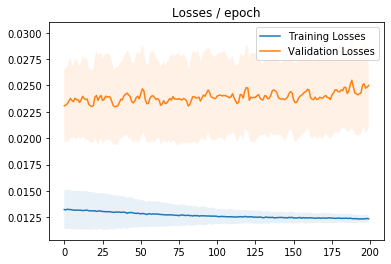

In [29]:
cv_plotter(cv_loss_trn, cv_loss_val)

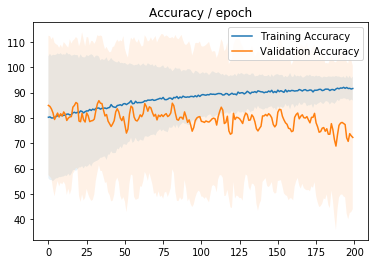

In [30]:
cv_plotter(cv_accs_trn, cv_accs_val, title='acc')

[]

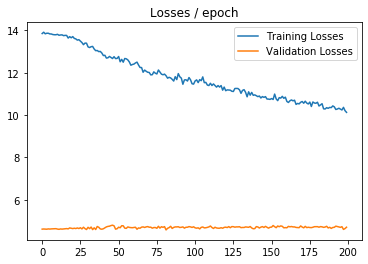

In [56]:
plt.title("Losses / epoch")
plt.plot(train_losses, label='Training Losses')
plt.plot(val_losses, label='Validation Losses')
plt.legend()
plt.plot()

[]

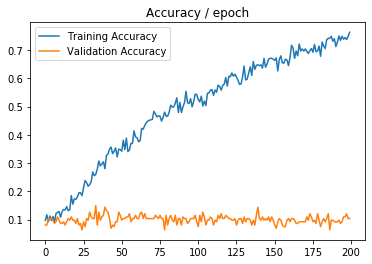

In [57]:
plt.title("Accuracy / epoch")
plt.plot(np.array(train_accs)/train_cnt, label='Training Accuracy')
plt.plot(np.array(val_accs)/val_cnt, label='Validation Accuracy')
plt.legend()
plt.plot()

In [55]:
conv(x).argmax(axis=1)

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 6, 1, 6, 7, 5, 0, 2, 6, 5, 2, 0, 8, 7, 8, 7, 6, 3, 8, 8, 3, 7, 5, 8,
        4, 6, 2, 8, 3, 3, 3, 1, 8, 3, 1, 1, 2, 1, 4, 3, 1, 6, 2, 9, 0, 1],
       grad_fn=<NotImplemented>)

## Training - Regression

In [25]:
conv = ConvNet(ctype='regression')

EPOCHS = range(200)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

cv_loss_trn, cv_loss_val = [], []
cv_accs_trn, cv_accs_val = [], []
for i, (trn_idx, val_idx) in enumerate(kfold.split(X_train)):
    print("Working on {}th Fold".format(i))
    
    train_reg_ds = TensorDataset(X_train[trn_idx], y_reg_train[trn_idx])
    val_reg_ds = TensorDataset(X_train[val_idx], y_reg_train[val_idx])
    
    train_reg_loader = DataLoader(train_reg_ds, batch_size=128, shuffle=True)
    val_reg_loader = DataLoader(val_reg_ds, batch_size=128, shuffle=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in EPOCHS:

        train_batch_loss = 0
        cnt = 0
        conv.train()
        for x, y in train_reg_loader:

            optimizer.zero_grad()
            y_pred = conv(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            
            print(y_pred[:3], y[:3])

            train_batch_loss += loss.item()
            cnt += 1

        train_losses.append(train_batch_loss / cnt)

        val_batch_loss = 0
        cnt = 0
        conv.eval()
        for x, y in val_reg_loader:
            y_pred = conv(x)
            loss = loss_fn(y_pred, y)

            val_batch_loss += loss.item()
            cnt += 1

        val_losses.append(val_batch_loss / cnt)

        print("EPOCH: {}".format(epoch))
        print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
        
    cv_loss_trn.append(train_losses)
    
    cv_loss_val.append(val_losses)
    print("\n")

Working on 0th Fold


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[-0.8860],
        [-0.2666],
        [-1.4569]], grad_fn=<SliceBackward>) tensor([20, 65, 18])
tensor([[3.7514],
        [2.5064],
        [3.3119]], grad_fn=<SliceBackward>) tensor([73, 67, 74])
tensor([[6.4337],
        [7.1279],
        [7.2359]], grad_fn=<SliceBackward>) tensor([68, 79, 63])
tensor([[10.5921],
        [ 9.4735],
        [11.9652]], grad_fn=<SliceBackward>) tensor([90, 22, 60])


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([111])) that is different to the input size (torch.Size([111, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[14.7119],
        [14.5639],
        [16.4172]], grad_fn=<SliceBackward>) tensor([24, 23, 70])


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([70])) that is different to the input size (torch.Size([70, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EPOCH: 0
[LOSS] train: 258.504, val: 52.225
tensor([[18.1485],
        [18.8382],
        [17.6593]], grad_fn=<SliceBackward>) tensor([22, 64, 23])
tensor([[21.3063],
        [22.3260],
        [21.4384]], grad_fn=<SliceBackward>) tensor([67, 53, 74])
tensor([[28.2925],
        [26.0352],
        [29.0171]], grad_fn=<SliceBackward>) tensor([20, 81, 63])
tensor([[32.1914],
        [31.2046],
        [32.3236]], grad_fn=<SliceBackward>) tensor([63, 80, 46])
tensor([[35.1348],
        [38.9005],
        [38.1344]], grad_fn=<SliceBackward>) tensor([80, 62, 24])
EPOCH: 1
[LOSS] train: 168.073, val: 37.531
tensor([[41.2028],
        [36.8497],
        [44.8961]], grad_fn=<SliceBackward>) tensor([66, 81, 59])
tensor([[47.0528],
        [48.3502],
        [44.3552]], grad_fn=<SliceBackward>) tensor([70, 58, 67])
tensor([[50.6605],
        [49.2132],
        [51.8926]], grad_fn=<SliceBackward>) tensor([94, 93, 45])
tensor([[59.8185],
        [56.6967],
        [56.7938]], grad_fn=<SliceBackward

tensor([[63.6575],
        [69.3416],
        [64.9629]], grad_fn=<SliceBackward>) tensor([63, 54, 21])
tensor([[59.7338],
        [63.7904],
        [65.8307]], grad_fn=<SliceBackward>) tensor([73, 65, 73])
EPOCH: 15
[LOSS] train: 70.82, val: 19.366
tensor([[68.1098],
        [60.2084],
        [60.8114]], grad_fn=<SliceBackward>) tensor([64, 48, 94])
tensor([[65.0466],
        [63.4110],
        [64.2477]], grad_fn=<SliceBackward>) tensor([59, 73, 51])
tensor([[62.1667],
        [69.3335],
        [65.3916]], grad_fn=<SliceBackward>) tensor([69, 68, 72])
tensor([[66.0738],
        [64.6467],
        [66.0893]], grad_fn=<SliceBackward>) tensor([23, 68, 59])
tensor([[61.8784],
        [66.2549],
        [65.0042]], grad_fn=<SliceBackward>) tensor([74, 43, 34])
EPOCH: 16
[LOSS] train: 71.482, val: 20.144
tensor([[67.3831],
        [62.2787],
        [61.6711]], grad_fn=<SliceBackward>) tensor([80, 68, 74])
tensor([[62.4887],
        [61.3032],
        [61.5157]], grad_fn=<SliceBackward>

tensor([[65.3090],
        [64.9647],
        [65.0457]], grad_fn=<SliceBackward>) tensor([65, 24, 20])
tensor([[60.2167],
        [62.2170],
        [61.8546]], grad_fn=<SliceBackward>) tensor([76, 88, 43])
tensor([[63.7933],
        [64.4397],
        [62.4812]], grad_fn=<SliceBackward>) tensor([74, 73, 22])
tensor([[59.7944],
        [61.1152],
        [60.8847]], grad_fn=<SliceBackward>) tensor([66, 66, 40])
EPOCH: 30
[LOSS] train: 70.728, val: 20.643
tensor([[63.3025],
        [63.4349],
        [63.3775]], grad_fn=<SliceBackward>) tensor([48, 61, 66])
tensor([[65.0811],
        [64.7842],
        [66.3541]], grad_fn=<SliceBackward>) tensor([54, 24, 71])
tensor([[65.1499],
        [63.0504],
        [63.8595]], grad_fn=<SliceBackward>) tensor([53, 19, 63])
tensor([[61.7772],
        [61.3478],
        [61.4801]], grad_fn=<SliceBackward>) tensor([54, 69, 69])
tensor([[63.5543],
        [62.6517],
        [64.5869]], grad_fn=<SliceBackward>) tensor([68, 21, 56])
EPOCH: 31
[LOSS] tra

tensor([[67.9999],
        [66.2634],
        [61.7703]], grad_fn=<SliceBackward>) tensor([62, 52, 90])
EPOCH: 44
[LOSS] train: 70.876, val: 21.264
tensor([[63.5488],
        [63.7717],
        [63.1699]], grad_fn=<SliceBackward>) tensor([68, 24, 18])
tensor([[62.7056],
        [62.9174],
        [62.1714]], grad_fn=<SliceBackward>) tensor([61, 69, 19])
tensor([[61.0232],
        [59.8894],
        [63.9508]], grad_fn=<SliceBackward>) tensor([68, 59, 80])
tensor([[62.9880],
        [60.8732],
        [60.5994]], grad_fn=<SliceBackward>) tensor([58, 24, 73])
tensor([[64.6643],
        [62.8059],
        [62.9816]], grad_fn=<SliceBackward>) tensor([94, 51, 68])
EPOCH: 45
[LOSS] train: 70.88, val: 21.274
tensor([[66.1673],
        [62.3439],
        [67.2768]], grad_fn=<SliceBackward>) tensor([71, 30, 20])
tensor([[61.8863],
        [69.3234],
        [68.4324]], grad_fn=<SliceBackward>) tensor([86, 21, 73])
tensor([[66.3184],
        [66.9484],
        [67.5731]], grad_fn=<SliceBackward>

tensor([[64.9034],
        [64.3191],
        [65.6360]], grad_fn=<SliceBackward>) tensor([49, 58, 69])
tensor([[66.4967],
        [66.2455],
        [65.8885]], grad_fn=<SliceBackward>) tensor([49, 59, 68])
tensor([[64.8027],
        [60.3624],
        [64.2244]], grad_fn=<SliceBackward>) tensor([51, 63, 58])
EPOCH: 59
[LOSS] train: 70.368, val: 22.063
tensor([[63.3304],
        [66.3402],
        [67.0846]], grad_fn=<SliceBackward>) tensor([48, 73, 80])
tensor([[66.4327],
        [68.0417],
        [66.4912]], grad_fn=<SliceBackward>) tensor([65, 21, 69])
tensor([[63.0269],
        [68.1007],
        [64.5004]], grad_fn=<SliceBackward>) tensor([68, 71, 76])
tensor([[65.2087],
        [64.9981],
        [63.5913]], grad_fn=<SliceBackward>) tensor([65, 67, 20])
tensor([[64.7029],
        [64.8488],
        [61.9361]], grad_fn=<SliceBackward>) tensor([55, 74, 73])
EPOCH: 60
[LOSS] train: 71.061, val: 22.087
tensor([[60.9569],
        [64.3464],
        [64.0282]], grad_fn=<SliceBackward

EPOCH: 73
[LOSS] train: 71.326, val: 21.99
tensor([[62.4472],
        [66.4762],
        [66.2296]], grad_fn=<SliceBackward>) tensor([65, 60, 23])
tensor([[63.7458],
        [65.6316],
        [64.6492]], grad_fn=<SliceBackward>) tensor([82, 68, 54])
tensor([[64.9227],
        [65.7254],
        [61.2279]], grad_fn=<SliceBackward>) tensor([48, 79, 58])
tensor([[63.2115],
        [66.0517],
        [61.9125]], grad_fn=<SliceBackward>) tensor([68, 81, 66])
tensor([[62.3102],
        [65.2766],
        [64.5123]], grad_fn=<SliceBackward>) tensor([58, 52, 63])
EPOCH: 74
[LOSS] train: 70.784, val: 21.821
tensor([[62.5656],
        [65.3814],
        [61.8878]], grad_fn=<SliceBackward>) tensor([20, 24, 68])
tensor([[62.7711],
        [63.8703],
        [63.4746]], grad_fn=<SliceBackward>) tensor([68, 20, 22])
tensor([[61.9021],
        [62.9360],
        [65.6086]], grad_fn=<SliceBackward>) tensor([59, 61, 87])
tensor([[64.5338],
        [63.3373],
        [61.9845]], grad_fn=<SliceBackward>

tensor([[69.0112],
        [64.7862],
        [68.5080]], grad_fn=<SliceBackward>) tensor([90, 48, 62])
tensor([[64.7406],
        [64.3935],
        [64.8501]], grad_fn=<SliceBackward>) tensor([76, 51, 60])
EPOCH: 88
[LOSS] train: 70.92, val: 23.528
tensor([[66.0078],
        [66.9157],
        [62.4105]], grad_fn=<SliceBackward>) tensor([73, 48, 46])
tensor([[64.8706],
        [63.5776],
        [67.5290]], grad_fn=<SliceBackward>) tensor([67, 48, 60])
tensor([[63.6703],
        [64.9185],
        [67.2268]], grad_fn=<SliceBackward>) tensor([74, 76, 48])
tensor([[63.4504],
        [65.1329],
        [66.7817]], grad_fn=<SliceBackward>) tensor([68, 65, 57])
tensor([[62.0295],
        [62.7971],
        [62.0208]], grad_fn=<SliceBackward>) tensor([22, 72, 55])
EPOCH: 89
[LOSS] train: 70.572, val: 24.152
tensor([[64.3759],
        [62.2233],
        [62.2661]], grad_fn=<SliceBackward>) tensor([65, 73, 76])
tensor([[65.1867],
        [63.7343],
        [62.5259]], grad_fn=<SliceBackward>

tensor([[61.5617],
        [61.4241],
        [63.7506]], grad_fn=<SliceBackward>) tensor([76, 85, 72])
tensor([[64.2588],
        [60.2564],
        [61.6193]], grad_fn=<SliceBackward>) tensor([73, 68, 57])
tensor([[60.2728],
        [61.2837],
        [60.3625]], grad_fn=<SliceBackward>) tensor([50, 22, 64])
tensor([[63.8382],
        [62.4018],
        [64.2735]], grad_fn=<SliceBackward>) tensor([60, 69, 56])
EPOCH: 103
[LOSS] train: 70.513, val: 23.34
tensor([[64.8174],
        [61.6027],
        [62.4244]], grad_fn=<SliceBackward>) tensor([74, 40, 76])
tensor([[61.9308],
        [62.1865],
        [62.2652]], grad_fn=<SliceBackward>) tensor([60, 74, 48])
tensor([[64.2669],
        [65.7942],
        [64.3563]], grad_fn=<SliceBackward>) tensor([48, 70, 22])
tensor([[62.4831],
        [65.0963],
        [65.1655]], grad_fn=<SliceBackward>) tensor([25, 26, 85])
tensor([[66.0325],
        [63.4366],
        [65.9439]], grad_fn=<SliceBackward>) tensor([58, 75, 52])
EPOCH: 104
[LOSS] tr

tensor([[65.0251],
        [65.4061],
        [65.8654]], grad_fn=<SliceBackward>) tensor([21, 61, 68])
EPOCH: 117
[LOSS] train: 70.626, val: 22.881
tensor([[62.7042],
        [69.3559],
        [63.7116]], grad_fn=<SliceBackward>) tensor([63, 65, 79])
tensor([[65.5365],
        [64.3149],
        [65.3551]], grad_fn=<SliceBackward>) tensor([72, 54, 25])
tensor([[65.7180],
        [65.7727],
        [65.8124]], grad_fn=<SliceBackward>) tensor([65, 58, 45])
tensor([[64.8169],
        [65.5093],
        [64.3429]], grad_fn=<SliceBackward>) tensor([75, 61, 65])
tensor([[60.7832],
        [63.2935],
        [62.9273]], grad_fn=<SliceBackward>) tensor([66, 65, 72])
EPOCH: 118
[LOSS] train: 70.81, val: 24.026
tensor([[64.5365],
        [64.5311],
        [62.8049]], grad_fn=<SliceBackward>) tensor([90, 69, 75])
tensor([[63.4432],
        [64.2017],
        [63.1544]], grad_fn=<SliceBackward>) tensor([23, 57, 22])
tensor([[64.5315],
        [64.3390],
        [62.8941]], grad_fn=<SliceBackwar

tensor([[60.6531],
        [61.2646],
        [63.5809]], grad_fn=<SliceBackward>) tensor([68, 68, 63])
tensor([[63.5999],
        [62.0713],
        [64.1049]], grad_fn=<SliceBackward>) tensor([53, 69, 74])
tensor([[61.6029],
        [63.4894],
        [63.0903]], grad_fn=<SliceBackward>) tensor([75, 60, 72])
EPOCH: 132
[LOSS] train: 70.717, val: 24.345
tensor([[64.1137],
        [65.3569],
        [64.5746]], grad_fn=<SliceBackward>) tensor([65, 80, 63])
tensor([[64.6805],
        [60.1554],
        [63.6570]], grad_fn=<SliceBackward>) tensor([50, 71, 52])
tensor([[61.0414],
        [62.8530],
        [63.0471]], grad_fn=<SliceBackward>) tensor([25, 86, 56])
tensor([[64.9395],
        [64.3782],
        [61.5166]], grad_fn=<SliceBackward>) tensor([63, 52, 76])
tensor([[62.2320],
        [63.9282],
        [64.9808]], grad_fn=<SliceBackward>) tensor([75, 66, 30])
EPOCH: 133
[LOSS] train: 70.638, val: 24.129
tensor([[63.3597],
        [61.9001],
        [63.2957]], grad_fn=<SliceBackwa

EPOCH: 146
[LOSS] train: 70.661, val: 24.205
tensor([[61.4309],
        [61.6854],
        [60.6590]], grad_fn=<SliceBackward>) tensor([74, 62, 73])
tensor([[62.8437],
        [61.9594],
        [62.0847]], grad_fn=<SliceBackward>) tensor([45, 72, 22])
tensor([[64.0135],
        [64.2624],
        [62.8845]], grad_fn=<SliceBackward>) tensor([69, 20, 59])
tensor([[62.6137],
        [65.9531],
        [64.2858]], grad_fn=<SliceBackward>) tensor([19, 56, 63])
tensor([[62.0707],
        [62.0959],
        [63.0546]], grad_fn=<SliceBackward>) tensor([72, 73, 50])
EPOCH: 147
[LOSS] train: 70.645, val: 23.615
tensor([[63.9030],
        [67.2454],
        [65.2423]], grad_fn=<SliceBackward>) tensor([62, 22, 65])
tensor([[65.3301],
        [62.1371],
        [65.1853]], grad_fn=<SliceBackward>) tensor([69, 67, 69])
tensor([[63.6270],
        [65.9472],
        [69.5361]], grad_fn=<SliceBackward>) tensor([67, 65, 20])
tensor([[64.2296],
        [65.4954],
        [60.8915]], grad_fn=<SliceBackwa

tensor([[65.7571],
        [67.5030],
        [65.3048]], grad_fn=<SliceBackward>) tensor([90, 67, 54])
tensor([[67.9420],
        [65.5322],
        [65.3779]], grad_fn=<SliceBackward>) tensor([57, 26, 20])
EPOCH: 161
[LOSS] train: 70.761, val: 23.653
tensor([[65.0887],
        [65.7632],
        [64.4725]], grad_fn=<SliceBackward>) tensor([21, 69, 80])
tensor([[64.9211],
        [62.8881],
        [61.7044]], grad_fn=<SliceBackward>) tensor([60, 18, 67])
tensor([[61.6339],
        [62.9154],
        [63.1345]], grad_fn=<SliceBackward>) tensor([68, 80, 65])
tensor([[65.5828],
        [61.2591],
        [64.9982]], grad_fn=<SliceBackward>) tensor([74, 26, 70])
tensor([[62.7427],
        [61.3946],
        [62.6816]], grad_fn=<SliceBackward>) tensor([20, 58, 18])
EPOCH: 162
[LOSS] train: 70.875, val: 23.959
tensor([[63.4002],
        [64.7461],
        [62.7557]], grad_fn=<SliceBackward>) tensor([22, 80, 68])
tensor([[64.7502],
        [61.4714],
        [65.8038]], grad_fn=<SliceBackwa

tensor([[64.3937],
        [59.9711],
        [64.0139]], grad_fn=<SliceBackward>) tensor([60, 71, 23])
tensor([[62.7106],
        [61.9906],
        [62.1288]], grad_fn=<SliceBackward>) tensor([69, 20, 64])
tensor([[61.9978],
        [60.6999],
        [60.8726]], grad_fn=<SliceBackward>) tensor([85, 65, 95])
tensor([[60.1483],
        [62.7132],
        [62.4203]], grad_fn=<SliceBackward>) tensor([70, 68, 73])
EPOCH: 176
[LOSS] train: 71.034, val: 24.536
tensor([[62.1274],
        [61.2650],
        [62.0966]], grad_fn=<SliceBackward>) tensor([66, 73, 67])
tensor([[65.7865],
        [64.2699],
        [64.2413]], grad_fn=<SliceBackward>) tensor([57, 22, 29])
tensor([[68.3978],
        [62.1614],
        [64.4388]], grad_fn=<SliceBackward>) tensor([80, 59, 75])
tensor([[64.5998],
        [64.9312],
        [66.1572]], grad_fn=<SliceBackward>) tensor([28, 90, 45])
tensor([[64.5667],
        [65.8285],
        [64.3042]], grad_fn=<SliceBackward>) tensor([80, 52, 71])
EPOCH: 177
[LOSS] t

tensor([[61.2395],
        [64.7119],
        [63.7720]], grad_fn=<SliceBackward>) tensor([51, 65, 71])
EPOCH: 190
[LOSS] train: 70.593, val: 23.727
tensor([[63.4653],
        [64.1955],
        [63.7205]], grad_fn=<SliceBackward>) tensor([68, 49, 69])
tensor([[62.1669],
        [63.0293],
        [62.9752]], grad_fn=<SliceBackward>) tensor([90, 67, 71])
tensor([[65.7819],
        [64.5450],
        [64.4004]], grad_fn=<SliceBackward>) tensor([21, 59, 79])
tensor([[63.4695],
        [61.2836],
        [64.5992]], grad_fn=<SliceBackward>) tensor([76, 74, 78])
tensor([[64.4775],
        [61.5877],
        [64.2866]], grad_fn=<SliceBackward>) tensor([20, 67, 68])
EPOCH: 191
[LOSS] train: 70.896, val: 23.818
tensor([[64.6811],
        [63.0912],
        [63.8467]], grad_fn=<SliceBackward>) tensor([69, 68, 68])
tensor([[64.2558],
        [64.1793],
        [64.0744]], grad_fn=<SliceBackward>) tensor([55, 59, 47])
tensor([[66.5691],
        [63.0392],
        [67.0172]], grad_fn=<SliceBackwa

tensor([[64.4540],
        [62.5852],
        [65.6002]], grad_fn=<SliceBackward>) tensor([65, 67, 74])
tensor([[62.6787],
        [60.3134],
        [63.6826]], grad_fn=<SliceBackward>) tensor([75, 23, 52])
tensor([[62.7163],
        [61.1491],
        [62.7468]], grad_fn=<SliceBackward>) tensor([78, 19, 65])
EPOCH: 5
[LOSS] train: 72.601, val: 25.217
tensor([[59.8740],
        [64.1889],
        [61.1654]], grad_fn=<SliceBackward>) tensor([54, 67, 67])
tensor([[59.9544],
        [61.7826],
        [63.3444]], grad_fn=<SliceBackward>) tensor([59, 85, 65])
tensor([[63.0337],
        [64.6922],
        [66.9168]], grad_fn=<SliceBackward>) tensor([22, 66, 61])
tensor([[65.6996],
        [66.1419],
        [68.7700]], grad_fn=<SliceBackward>) tensor([67, 75, 56])
tensor([[66.7625],
        [65.4113],
        [61.6367]], grad_fn=<SliceBackward>) tensor([63, 24, 54])
EPOCH: 6
[LOSS] train: 74.062, val: 23.944
tensor([[64.2840],
        [66.4716],
        [62.2550]], grad_fn=<SliceBackward>)

EPOCH: 19
[LOSS] train: 72.545, val: 25.519
tensor([[61.5707],
        [65.1566],
        [64.2200]], grad_fn=<SliceBackward>) tensor([28, 47, 68])
tensor([[65.3318],
        [65.0431],
        [63.3956]], grad_fn=<SliceBackward>) tensor([22, 55, 67])
tensor([[61.9769],
        [65.6337],
        [62.3985]], grad_fn=<SliceBackward>) tensor([30, 49, 18])
tensor([[66.1261],
        [65.2727],
        [67.6097]], grad_fn=<SliceBackward>) tensor([59, 73, 51])
tensor([[67.5474],
        [64.9379],
        [64.6387]], grad_fn=<SliceBackward>) tensor([76, 75, 66])
EPOCH: 20
[LOSS] train: 72.856, val: 24.689
tensor([[63.9399],
        [63.3472],
        [65.2466]], grad_fn=<SliceBackward>) tensor([88, 79, 67])
tensor([[65.0772],
        [62.9372],
        [62.7716]], grad_fn=<SliceBackward>) tensor([56, 50, 71])
tensor([[64.3280],
        [63.8100],
        [62.1623]], grad_fn=<SliceBackward>) tensor([70, 65, 48])
tensor([[63.6902],
        [63.1072],
        [60.4151]], grad_fn=<SliceBackward

tensor([[64.7953],
        [67.0609],
        [64.7045]], grad_fn=<SliceBackward>) tensor([60, 78, 83])
tensor([[62.3060],
        [66.8885],
        [65.9844]], grad_fn=<SliceBackward>) tensor([23, 70, 80])
EPOCH: 34
[LOSS] train: 72.982, val: 21.055
tensor([[63.5114],
        [63.1396],
        [63.2600]], grad_fn=<SliceBackward>) tensor([65, 82, 64])
tensor([[63.2117],
        [65.1801],
        [61.4738]], grad_fn=<SliceBackward>) tensor([54, 79, 43])
tensor([[62.6644],
        [61.9785],
        [62.1376]], grad_fn=<SliceBackward>) tensor([45, 71, 89])
tensor([[63.7786],
        [60.1347],
        [61.8213]], grad_fn=<SliceBackward>) tensor([73, 56, 68])
tensor([[61.8933],
        [60.5323],
        [61.9706]], grad_fn=<SliceBackward>) tensor([64, 25, 65])
EPOCH: 35
[LOSS] train: 72.791, val: 21.289
tensor([[60.1030],
        [62.2066],
        [63.6932]], grad_fn=<SliceBackward>) tensor([47, 65, 52])
tensor([[62.2213],
        [62.2988],
        [64.1773]], grad_fn=<SliceBackward

tensor([[63.3437],
        [64.6308],
        [64.3434]], grad_fn=<SliceBackward>) tensor([65, 66, 69])
tensor([[60.6035],
        [62.9643],
        [64.3243]], grad_fn=<SliceBackward>) tensor([19, 86, 49])
tensor([[64.5126],
        [63.9213],
        [64.1414]], grad_fn=<SliceBackward>) tensor([66, 68, 77])
tensor([[64.8195],
        [66.2297],
        [62.5444]], grad_fn=<SliceBackward>) tensor([64, 43, 55])
EPOCH: 49
[LOSS] train: 72.561, val: 23.314
tensor([[65.3174],
        [64.2763],
        [62.3404]], grad_fn=<SliceBackward>) tensor([26, 67, 60])
tensor([[61.2408],
        [62.9168],
        [64.5638]], grad_fn=<SliceBackward>) tensor([80, 52, 56])
tensor([[63.6817],
        [63.6439],
        [63.6196]], grad_fn=<SliceBackward>) tensor([59, 68, 65])
tensor([[60.9276],
        [63.9519],
        [64.0249]], grad_fn=<SliceBackward>) tensor([70, 71, 25])
tensor([[64.0563],
        [63.2418],
        [63.2982]], grad_fn=<SliceBackward>) tensor([69, 19, 23])
EPOCH: 50
[LOSS] tra

tensor([[63.4133],
        [61.3474],
        [61.9995]], grad_fn=<SliceBackward>) tensor([61, 23, 69])
EPOCH: 63
[LOSS] train: 73.146, val: 27.349
tensor([[62.1518],
        [62.6370],
        [61.5653]], grad_fn=<SliceBackward>) tensor([23, 81, 58])
tensor([[63.0453],
        [64.3423],
        [67.0971]], grad_fn=<SliceBackward>) tensor([55, 79, 60])
tensor([[65.8301],
        [65.1339],
        [64.4370]], grad_fn=<SliceBackward>) tensor([21, 74, 23])
tensor([[67.1921],
        [66.6806],
        [64.6591]], grad_fn=<SliceBackward>) tensor([40, 68, 80])
tensor([[66.4296],
        [67.1761],
        [65.9309]], grad_fn=<SliceBackward>) tensor([73, 73, 25])
EPOCH: 64
[LOSS] train: 72.916, val: 24.878
tensor([[66.8994],
        [64.7930],
        [65.0270]], grad_fn=<SliceBackward>) tensor([21, 73, 53])
tensor([[67.1440],
        [67.3884],
        [66.0790]], grad_fn=<SliceBackward>) tensor([60, 83, 83])
tensor([[66.2595],
        [64.5570],
        [64.8856]], grad_fn=<SliceBackward

tensor([[66.9503],
        [65.0165],
        [61.5078]], grad_fn=<SliceBackward>) tensor([71, 67, 68])
tensor([[65.3055],
        [64.1069],
        [63.0484]], grad_fn=<SliceBackward>) tensor([52, 25, 68])
tensor([[64.6691],
        [63.5643],
        [63.5287]], grad_fn=<SliceBackward>) tensor([62, 19, 66])
EPOCH: 78
[LOSS] train: 72.784, val: 23.348
tensor([[61.9970],
        [60.9875],
        [63.7608]], grad_fn=<SliceBackward>) tensor([44, 30, 59])
tensor([[60.0178],
        [62.8324],
        [63.8620]], grad_fn=<SliceBackward>) tensor([48, 76, 66])
tensor([[60.7910],
        [63.2676],
        [64.9128]], grad_fn=<SliceBackward>) tensor([73, 67, 78])
tensor([[63.0458],
        [62.4377],
        [64.4321]], grad_fn=<SliceBackward>) tensor([20, 22, 21])
tensor([[63.4785],
        [62.0837],
        [63.8414]], grad_fn=<SliceBackward>) tensor([58, 73, 72])
EPOCH: 79
[LOSS] train: 72.743, val: 23.328
tensor([[62.8733],
        [61.7988],
        [62.7648]], grad_fn=<SliceBackward

EPOCH: 92
[LOSS] train: 72.556, val: 22.986
tensor([[65.4425],
        [66.1780],
        [65.0818]], grad_fn=<SliceBackward>) tensor([90, 66, 23])
tensor([[67.1303],
        [63.9518],
        [63.6890]], grad_fn=<SliceBackward>) tensor([68, 23, 60])
tensor([[62.9648],
        [64.4091],
        [64.0631]], grad_fn=<SliceBackward>) tensor([74, 82, 93])
tensor([[62.3440],
        [63.4515],
        [60.5492]], grad_fn=<SliceBackward>) tensor([59, 20, 25])
tensor([[64.1580],
        [62.2303],
        [64.2482]], grad_fn=<SliceBackward>) tensor([66, 73, 22])
EPOCH: 93
[LOSS] train: 72.775, val: 23.513
tensor([[63.8529],
        [64.1044],
        [62.7283]], grad_fn=<SliceBackward>) tensor([72, 61, 75])
tensor([[61.3419],
        [63.0319],
        [63.4327]], grad_fn=<SliceBackward>) tensor([50, 64, 59])
tensor([[62.7084],
        [64.1240],
        [61.9784]], grad_fn=<SliceBackward>) tensor([62, 23, 46])
tensor([[65.3957],
        [61.9592],
        [64.2217]], grad_fn=<SliceBackward

tensor([[63.2383],
        [64.4403],
        [63.4984]], grad_fn=<SliceBackward>) tensor([69, 65, 30])
tensor([[63.2957],
        [64.6803],
        [64.5255]], grad_fn=<SliceBackward>) tensor([53, 74, 40])
EPOCH: 107
[LOSS] train: 72.712, val: 24.3
tensor([[63.3205],
        [64.5209],
        [64.4274]], grad_fn=<SliceBackward>) tensor([74, 22, 74])
tensor([[64.5274],
        [63.8556],
        [62.0412]], grad_fn=<SliceBackward>) tensor([76, 40, 22])
tensor([[65.6110],
        [63.1936],
        [65.6383]], grad_fn=<SliceBackward>) tensor([68, 73, 21])
tensor([[65.6497],
        [63.2348],
        [65.7845]], grad_fn=<SliceBackward>) tensor([76, 72, 52])
tensor([[65.1403],
        [65.4164],
        [65.5613]], grad_fn=<SliceBackward>) tensor([48, 90, 67])
EPOCH: 108
[LOSS] train: 72.552, val: 24.234
tensor([[65.8604],
        [62.7348],
        [63.8329]], grad_fn=<SliceBackward>) tensor([68, 67, 31])
tensor([[62.5220],
        [64.2038],
        [63.6229]], grad_fn=<SliceBackward

tensor([[63.9446],
        [64.6465],
        [64.9304]], grad_fn=<SliceBackward>) tensor([84, 65, 73])
tensor([[64.7617],
        [62.8363],
        [61.2590]], grad_fn=<SliceBackward>) tensor([40, 78, 62])
tensor([[63.2642],
        [65.0597],
        [66.3812]], grad_fn=<SliceBackward>) tensor([70, 84, 47])
tensor([[58.5358],
        [62.2042],
        [62.8284]], grad_fn=<SliceBackward>) tensor([72, 69, 60])
EPOCH: 122
[LOSS] train: 72.693, val: 25.726
tensor([[62.8733],
        [62.8630],
        [63.3786]], grad_fn=<SliceBackward>) tensor([68, 65, 67])
tensor([[63.2370],
        [61.8982],
        [63.1302]], grad_fn=<SliceBackward>) tensor([74, 56, 75])
tensor([[64.8864],
        [63.0116],
        [62.0669]], grad_fn=<SliceBackward>) tensor([70, 74, 74])
tensor([[63.4923],
        [62.6553],
        [63.6256]], grad_fn=<SliceBackward>) tensor([48, 75, 66])
tensor([[65.2981],
        [60.6931],
        [63.8558]], grad_fn=<SliceBackward>) tensor([18, 50, 55])
EPOCH: 123
[LOSS] t

tensor([[64.2075],
        [65.7926],
        [65.3982]], grad_fn=<SliceBackward>) tensor([67, 49, 52])
EPOCH: 136
[LOSS] train: 73.015, val: 23.115
tensor([[64.1932],
        [64.6094],
        [66.4386]], grad_fn=<SliceBackward>) tensor([55, 68, 52])
tensor([[64.0980],
        [65.3708],
        [66.7775]], grad_fn=<SliceBackward>) tensor([56, 59, 69])
tensor([[63.6956],
        [65.4042],
        [65.6067]], grad_fn=<SliceBackward>) tensor([69, 65, 68])
tensor([[62.2720],
        [63.3555],
        [63.1888]], grad_fn=<SliceBackward>) tensor([61, 49, 79])
tensor([[63.6463],
        [62.4901],
        [63.8168]], grad_fn=<SliceBackward>) tensor([68, 61, 72])
EPOCH: 137
[LOSS] train: 72.732, val: 24.193
tensor([[63.1568],
        [61.8912],
        [64.2960]], grad_fn=<SliceBackward>) tensor([76, 52, 70])
tensor([[62.6204],
        [62.7426],
        [63.9689]], grad_fn=<SliceBackward>) tensor([84, 80, 20])
tensor([[62.1501],
        [63.6320],
        [65.0999]], grad_fn=<SliceBackwa

tensor([[64.2252],
        [65.2527],
        [65.1698]], grad_fn=<SliceBackward>) tensor([57, 51, 61])
tensor([[65.6637],
        [65.5182],
        [63.4805]], grad_fn=<SliceBackward>) tensor([69, 69, 51])
tensor([[65.5270],
        [68.1240],
        [66.0136]], grad_fn=<SliceBackward>) tensor([51, 51, 62])
EPOCH: 151
[LOSS] train: 72.641, val: 23.691
tensor([[64.3610],
        [67.6789],
        [66.5345]], grad_fn=<SliceBackward>) tensor([51, 69, 21])
tensor([[65.8270],
        [66.4589],
        [64.4649]], grad_fn=<SliceBackward>) tensor([71, 59, 80])
tensor([[65.1939],
        [65.1524],
        [64.6955]], grad_fn=<SliceBackward>) tensor([81, 74, 63])
tensor([[65.6016],
        [66.7721],
        [65.4627]], grad_fn=<SliceBackward>) tensor([31, 24, 67])
tensor([[64.1650],
        [65.2025],
        [65.1813]], grad_fn=<SliceBackward>) tensor([91, 74, 68])
EPOCH: 152
[LOSS] train: 72.999, val: 24.315
tensor([[63.6044],
        [64.5578],
        [63.3005]], grad_fn=<SliceBackwa

EPOCH: 165
[LOSS] train: 72.535, val: 24.78
tensor([[63.5555],
        [61.7443],
        [62.1649]], grad_fn=<SliceBackward>) tensor([74, 68, 72])
tensor([[62.0782],
        [61.2532],
        [62.7927]], grad_fn=<SliceBackward>) tensor([67, 73, 80])
tensor([[64.3969],
        [61.7950],
        [65.5675]], grad_fn=<SliceBackward>) tensor([73, 86, 51])
tensor([[64.4826],
        [63.8095],
        [64.9181]], grad_fn=<SliceBackward>) tensor([66, 56, 74])
tensor([[63.4456],
        [65.5085],
        [66.5279]], grad_fn=<SliceBackward>) tensor([69, 82, 18])
EPOCH: 166
[LOSS] train: 72.994, val: 23.201
tensor([[63.4600],
        [68.3535],
        [66.7387]], grad_fn=<SliceBackward>) tensor([20, 66, 87])
tensor([[65.1270],
        [64.7924],
        [65.1705]], grad_fn=<SliceBackward>) tensor([68, 27, 69])
tensor([[65.3656],
        [65.8128],
        [64.3070]], grad_fn=<SliceBackward>) tensor([70, 73, 73])
tensor([[65.9668],
        [63.8180],
        [65.0518]], grad_fn=<SliceBackwar

tensor([[63.2407],
        [60.5805],
        [62.5931]], grad_fn=<SliceBackward>) tensor([64, 85, 67])
tensor([[63.7677],
        [61.4289],
        [61.8838]], grad_fn=<SliceBackward>) tensor([45, 51, 68])
EPOCH: 180
[LOSS] train: 72.915, val: 24.103
tensor([[65.9335],
        [62.9791],
        [64.4503]], grad_fn=<SliceBackward>) tensor([21, 76, 46])
tensor([[65.5286],
        [65.8748],
        [64.2303]], grad_fn=<SliceBackward>) tensor([57, 22, 61])
tensor([[66.7459],
        [66.8290],
        [66.7998]], grad_fn=<SliceBackward>) tensor([71, 68, 80])
tensor([[65.7285],
        [67.1224],
        [67.3336]], grad_fn=<SliceBackward>) tensor([67, 60, 84])
tensor([[65.3931],
        [62.7089],
        [63.0104]], grad_fn=<SliceBackward>) tensor([51, 23, 19])
EPOCH: 181
[LOSS] train: 73.209, val: 24.354
tensor([[63.8768],
        [63.0972],
        [62.7917]], grad_fn=<SliceBackward>) tensor([48, 21, 59])
tensor([[63.8951],
        [63.0843],
        [64.7957]], grad_fn=<SliceBackwa

tensor([[60.5520],
        [61.7921],
        [63.5638]], grad_fn=<SliceBackward>) tensor([73, 40, 43])
tensor([[61.6521],
        [63.1631],
        [62.9023]], grad_fn=<SliceBackward>) tensor([67, 63, 89])
tensor([[63.8605],
        [62.8396],
        [61.2439]], grad_fn=<SliceBackward>) tensor([22, 28, 65])
tensor([[63.8934],
        [64.0172],
        [64.4290]], grad_fn=<SliceBackward>) tensor([71, 55, 74])
EPOCH: 195
[LOSS] train: 72.943, val: 22.063
tensor([[65.0334],
        [64.3046],
        [62.2693]], grad_fn=<SliceBackward>) tensor([73, 73, 73])
tensor([[64.7939],
        [62.4442],
        [64.5633]], grad_fn=<SliceBackward>) tensor([29, 26, 56])
tensor([[66.0473],
        [66.3941],
        [64.6478]], grad_fn=<SliceBackward>) tensor([60, 58, 48])
tensor([[63.2164],
        [65.3312],
        [65.3809]], grad_fn=<SliceBackward>) tensor([57, 53, 20])
tensor([[63.7894],
        [64.1011],
        [65.1685]], grad_fn=<SliceBackward>) tensor([73, 67, 38])
EPOCH: 196
[LOSS] t

tensor([[64.4012],
        [65.2296],
        [64.4079]], grad_fn=<SliceBackward>) tensor([67, 62, 23])
EPOCH: 9
[LOSS] train: 71.722, val: 23.48
tensor([[63.3003],
        [64.7247],
        [65.5407]], grad_fn=<SliceBackward>) tensor([24, 68, 65])
tensor([[65.6163],
        [63.7748],
        [66.3134]], grad_fn=<SliceBackward>) tensor([59, 68, 55])
tensor([[64.5209],
        [65.6441],
        [64.6530]], grad_fn=<SliceBackward>) tensor([75, 67, 56])
tensor([[66.4982],
        [66.2198],
        [64.1383]], grad_fn=<SliceBackward>) tensor([73, 23, 22])
tensor([[67.3058],
        [64.1686],
        [66.2138]], grad_fn=<SliceBackward>) tensor([65, 72, 21])
EPOCH: 10
[LOSS] train: 71.906, val: 23.975
tensor([[66.4343],
        [64.6492],
        [62.8170]], grad_fn=<SliceBackward>) tensor([69, 66, 71])
tensor([[61.6209],
        [66.1060],
        [63.8483]], grad_fn=<SliceBackward>) tensor([66, 49, 60])
tensor([[63.7240],
        [63.7431],
        [63.4371]], grad_fn=<SliceBackward>)

tensor([[65.8857],
        [63.2173],
        [62.2468]], grad_fn=<SliceBackward>) tensor([51, 74, 73])
tensor([[62.8147],
        [61.2275],
        [65.1835]], grad_fn=<SliceBackward>) tensor([55, 74, 68])
tensor([[63.5908],
        [63.3196],
        [63.4600]], grad_fn=<SliceBackward>) tensor([72, 68, 61])
EPOCH: 24
[LOSS] train: 71.662, val: 24.045
tensor([[62.9594],
        [61.5972],
        [60.7474]], grad_fn=<SliceBackward>) tensor([25, 74, 59])
tensor([[64.3333],
        [64.2968],
        [62.8255]], grad_fn=<SliceBackward>) tensor([69, 43, 29])
tensor([[64.0386],
        [60.1790],
        [64.4656]], grad_fn=<SliceBackward>) tensor([73, 90, 80])
tensor([[65.3402],
        [64.7963],
        [65.2197]], grad_fn=<SliceBackward>) tensor([68, 49, 74])
tensor([[66.4315],
        [63.9624],
        [66.4984]], grad_fn=<SliceBackward>) tensor([67, 95, 89])
EPOCH: 25
[LOSS] train: 72.153, val: 23.008
tensor([[65.6395],
        [64.5424],
        [66.5536]], grad_fn=<SliceBackward

EPOCH: 38
[LOSS] train: 71.669, val: 24.205
tensor([[65.4535],
        [64.8313],
        [64.4708]], grad_fn=<SliceBackward>) tensor([61, 50, 60])
tensor([[64.4736],
        [62.9509],
        [64.4711]], grad_fn=<SliceBackward>) tensor([60, 57, 20])
tensor([[64.4047],
        [64.6965],
        [63.2007]], grad_fn=<SliceBackward>) tensor([53, 43, 70])
tensor([[61.3869],
        [63.9513],
        [61.8810]], grad_fn=<SliceBackward>) tensor([50, 67, 85])
tensor([[63.7248],
        [61.7528],
        [64.9587]], grad_fn=<SliceBackward>) tensor([80, 80, 28])
EPOCH: 39
[LOSS] train: 71.96, val: 24.625
tensor([[62.5558],
        [62.7793],
        [63.9817]], grad_fn=<SliceBackward>) tensor([20, 23, 71])
tensor([[62.4789],
        [62.8083],
        [64.2189]], grad_fn=<SliceBackward>) tensor([51, 85, 73])
tensor([[63.7675],
        [63.9699],
        [64.8571]], grad_fn=<SliceBackward>) tensor([21, 20, 26])
tensor([[64.8183],
        [66.4123],
        [63.5421]], grad_fn=<SliceBackward>

tensor([[61.2771],
        [61.2598],
        [62.4045]], grad_fn=<SliceBackward>) tensor([75, 22, 68])
tensor([[63.8527],
        [61.9592],
        [59.7652]], grad_fn=<SliceBackward>) tensor([45, 71, 18])
EPOCH: 53
[LOSS] train: 72.501, val: 23.382
tensor([[59.9134],
        [61.2961],
        [59.7010]], grad_fn=<SliceBackward>) tensor([57, 23, 45])
tensor([[61.7615],
        [61.9717],
        [63.9265]], grad_fn=<SliceBackward>) tensor([47, 22, 67])
tensor([[64.3902],
        [65.5882],
        [64.1149]], grad_fn=<SliceBackward>) tensor([67, 69, 56])
tensor([[66.7986],
        [60.9270],
        [63.9376]], grad_fn=<SliceBackward>) tensor([65, 46, 68])
tensor([[65.7040],
        [68.1876],
        [65.2328]], grad_fn=<SliceBackward>) tensor([18, 64, 58])
EPOCH: 54
[LOSS] train: 71.848, val: 23.091
tensor([[67.9110],
        [63.5327],
        [67.0673]], grad_fn=<SliceBackward>) tensor([75, 52, 45])
tensor([[67.2992],
        [66.4137],
        [68.8368]], grad_fn=<SliceBackward

tensor([[65.1842],
        [63.9634],
        [65.1465]], grad_fn=<SliceBackward>) tensor([58, 30, 73])
tensor([[64.9531],
        [65.3843],
        [65.7942]], grad_fn=<SliceBackward>) tensor([51, 51, 28])
tensor([[66.4675],
        [66.2056],
        [64.8615]], grad_fn=<SliceBackward>) tensor([22, 50, 72])
tensor([[66.2666],
        [63.6840],
        [64.9484]], grad_fn=<SliceBackward>) tensor([55, 67, 65])
EPOCH: 68
[LOSS] train: 71.549, val: 23.616
tensor([[64.1819],
        [63.7303],
        [65.0609]], grad_fn=<SliceBackward>) tensor([86, 74, 51])
tensor([[62.9820],
        [64.4958],
        [63.8507]], grad_fn=<SliceBackward>) tensor([90, 75, 73])
tensor([[62.8389],
        [63.4909],
        [62.5666]], grad_fn=<SliceBackward>) tensor([65, 85, 76])
tensor([[64.6537],
        [62.7172],
        [65.3018]], grad_fn=<SliceBackward>) tensor([23, 54, 80])
tensor([[64.5395],
        [62.8060],
        [64.5270]], grad_fn=<SliceBackward>) tensor([66, 70, 20])
EPOCH: 69
[LOSS] tra

tensor([[62.5233],
        [65.3325],
        [66.1535]], grad_fn=<SliceBackward>) tensor([84, 55, 48])
EPOCH: 82
[LOSS] train: 71.52, val: 23.834
tensor([[65.5345],
        [65.4118],
        [63.5961]], grad_fn=<SliceBackward>) tensor([63, 23, 46])
tensor([[64.7655],
        [63.9827],
        [65.0819]], grad_fn=<SliceBackward>) tensor([59, 75, 59])
tensor([[62.5531],
        [62.7661],
        [64.3900]], grad_fn=<SliceBackward>) tensor([80, 67, 63])
tensor([[62.5748],
        [62.9789],
        [64.5347]], grad_fn=<SliceBackward>) tensor([25, 31, 43])
tensor([[63.9742],
        [62.5926],
        [64.2041]], grad_fn=<SliceBackward>) tensor([54, 63, 69])
EPOCH: 83
[LOSS] train: 71.543, val: 24.196
tensor([[63.1438],
        [61.7866],
        [63.4772]], grad_fn=<SliceBackward>) tensor([76, 83, 85])
tensor([[63.4770],
        [65.4435],
        [64.3401]], grad_fn=<SliceBackward>) tensor([90, 28, 54])
tensor([[64.8012],
        [64.2588],
        [65.6144]], grad_fn=<SliceBackward>

tensor([[63.9938],
        [66.5380],
        [63.4835]], grad_fn=<SliceBackward>) tensor([67, 27, 51])
tensor([[64.1540],
        [65.3677],
        [63.4826]], grad_fn=<SliceBackward>) tensor([23, 63, 68])
tensor([[64.9475],
        [63.8486],
        [65.1131]], grad_fn=<SliceBackward>) tensor([78, 22, 68])
EPOCH: 97
[LOSS] train: 71.701, val: 24.612
tensor([[66.2550],
        [64.5277],
        [65.2419]], grad_fn=<SliceBackward>) tensor([68, 55, 75])
tensor([[64.8545],
        [64.7119],
        [65.2042]], grad_fn=<SliceBackward>) tensor([48, 25, 80])
tensor([[64.7653],
        [64.8991],
        [65.7104]], grad_fn=<SliceBackward>) tensor([78, 65, 52])
tensor([[64.9638],
        [64.7944],
        [63.9057]], grad_fn=<SliceBackward>) tensor([18, 72, 50])
tensor([[62.3478],
        [63.4854],
        [61.4771]], grad_fn=<SliceBackward>) tensor([66, 71, 73])
EPOCH: 98
[LOSS] train: 71.478, val: 24.911
tensor([[63.6681],
        [60.7656],
        [63.6067]], grad_fn=<SliceBackward

EPOCH: 111
[LOSS] train: 71.386, val: 24.821
tensor([[63.3295],
        [61.6264],
        [63.4907]], grad_fn=<SliceBackward>) tensor([46, 79, 68])
tensor([[62.5563],
        [62.2587],
        [62.8650]], grad_fn=<SliceBackward>) tensor([68, 59, 55])
tensor([[63.8562],
        [64.7531],
        [62.7932]], grad_fn=<SliceBackward>) tensor([23, 61, 64])
tensor([[64.7840],
        [64.8438],
        [64.1659]], grad_fn=<SliceBackward>) tensor([64, 70, 58])
tensor([[64.6159],
        [67.3008],
        [64.5338]], grad_fn=<SliceBackward>) tensor([69, 69, 67])
EPOCH: 112
[LOSS] train: 71.81, val: 23.911
tensor([[64.9758],
        [66.0130],
        [64.0196]], grad_fn=<SliceBackward>) tensor([73, 23, 71])
tensor([[65.3385],
        [64.1817],
        [63.6484]], grad_fn=<SliceBackward>) tensor([57, 68, 54])
tensor([[63.0093],
        [65.0805],
        [66.0040]], grad_fn=<SliceBackward>) tensor([48, 31, 19])
tensor([[63.4288],
        [65.3921],
        [64.2113]], grad_fn=<SliceBackwar

tensor([[60.5777],
        [62.1534],
        [59.5532]], grad_fn=<SliceBackward>) tensor([59, 73, 67])
tensor([[60.9189],
        [60.1156],
        [59.8370]], grad_fn=<SliceBackward>) tensor([90, 74, 75])
EPOCH: 126
[LOSS] train: 72.828, val: 26.492
tensor([[59.9516],
        [62.1072],
        [60.8095]], grad_fn=<SliceBackward>) tensor([67, 59, 60])
tensor([[61.9827],
        [61.2293],
        [61.8576]], grad_fn=<SliceBackward>) tensor([74, 43, 22])
tensor([[61.1157],
        [64.0702],
        [64.9732]], grad_fn=<SliceBackward>) tensor([59, 67, 84])
tensor([[66.7413],
        [66.6533],
        [65.2847]], grad_fn=<SliceBackward>) tensor([38, 46, 51])
tensor([[67.2620],
        [67.9633],
        [69.3516]], grad_fn=<SliceBackward>) tensor([78, 65, 66])
EPOCH: 127
[LOSS] train: 72.245, val: 23.19
tensor([[64.9405],
        [63.9753],
        [67.6096]], grad_fn=<SliceBackward>) tensor([48, 72, 67])
tensor([[64.6537],
        [67.1416],
        [64.1848]], grad_fn=<SliceBackwar

tensor([[62.4597],
        [63.1793],
        [62.2784]], grad_fn=<SliceBackward>) tensor([23, 76, 86])
tensor([[65.7140],
        [66.3578],
        [65.4121]], grad_fn=<SliceBackward>) tensor([49, 61, 60])
tensor([[65.8427],
        [68.1175],
        [66.5177]], grad_fn=<SliceBackward>) tensor([64, 75, 70])
tensor([[66.6751],
        [66.2014],
        [62.9238]], grad_fn=<SliceBackward>) tensor([72, 90, 71])
EPOCH: 141
[LOSS] train: 71.915, val: 23.299
tensor([[63.9502],
        [65.4677],
        [66.2204]], grad_fn=<SliceBackward>) tensor([43, 55, 64])
tensor([[64.2681],
        [65.9113],
        [65.0234]], grad_fn=<SliceBackward>) tensor([89, 69, 55])
tensor([[64.5042],
        [65.4537],
        [64.0089]], grad_fn=<SliceBackward>) tensor([67, 52, 69])
tensor([[64.5659],
        [64.6630],
        [65.7802]], grad_fn=<SliceBackward>) tensor([51, 46, 68])
tensor([[66.4077],
        [62.5899],
        [63.4325]], grad_fn=<SliceBackward>) tensor([20, 74, 69])
EPOCH: 142
[LOSS] t

tensor([[62.6926],
        [64.1666],
        [66.5512]], grad_fn=<SliceBackward>) tensor([19, 76, 54])
EPOCH: 155
[LOSS] train: 71.604, val: 23.692
tensor([[66.8649],
        [66.6740],
        [63.0735]], grad_fn=<SliceBackward>) tensor([67, 18, 89])
tensor([[63.8781],
        [64.5641],
        [63.9940]], grad_fn=<SliceBackward>) tensor([83, 44, 80])
tensor([[65.5264],
        [64.3172],
        [63.5608]], grad_fn=<SliceBackward>) tensor([22, 74, 64])
tensor([[64.0845],
        [64.7641],
        [64.6353]], grad_fn=<SliceBackward>) tensor([73, 47, 67])
tensor([[63.6921],
        [65.6672],
        [65.2218]], grad_fn=<SliceBackward>) tensor([80, 86, 20])
EPOCH: 156
[LOSS] train: 71.664, val: 24.057
tensor([[63.9207],
        [63.5989],
        [65.7855]], grad_fn=<SliceBackward>) tensor([90, 69, 72])
tensor([[63.7388],
        [63.2384],
        [63.6668]], grad_fn=<SliceBackward>) tensor([58, 20, 80])
tensor([[66.5172],
        [65.3102],
        [63.8168]], grad_fn=<SliceBackwa

tensor([[64.6387],
        [64.4308],
        [61.9565]], grad_fn=<SliceBackward>) tensor([25, 67, 51])
tensor([[65.4140],
        [61.7941],
        [65.5551]], grad_fn=<SliceBackward>) tensor([56, 79, 73])
tensor([[64.5989],
        [62.4629],
        [63.2424]], grad_fn=<SliceBackward>) tensor([90, 58, 89])
EPOCH: 170
[LOSS] train: 71.442, val: 24.148
tensor([[63.2343],
        [63.6510],
        [64.5719]], grad_fn=<SliceBackward>) tensor([79, 20, 59])
tensor([[63.5408],
        [62.9355],
        [61.3116]], grad_fn=<SliceBackward>) tensor([68, 65, 62])
tensor([[63.4220],
        [64.4065],
        [63.3834]], grad_fn=<SliceBackward>) tensor([53, 69, 21])
tensor([[63.8399],
        [63.5811],
        [63.8787]], grad_fn=<SliceBackward>) tensor([58, 58, 49])
tensor([[63.7549],
        [64.9403],
        [63.9912]], grad_fn=<SliceBackward>) tensor([84, 31, 78])
EPOCH: 171
[LOSS] train: 71.443, val: 23.656
tensor([[66.0572],
        [62.3846],
        [65.0569]], grad_fn=<SliceBackwa

EPOCH: 184
[LOSS] train: 71.538, val: 24.6
tensor([[61.9089],
        [63.0546],
        [65.6453]], grad_fn=<SliceBackward>) tensor([67, 66, 60])
tensor([[62.6741],
        [61.3113],
        [60.0812]], grad_fn=<SliceBackward>) tensor([53, 68, 65])
tensor([[62.3706],
        [63.8690],
        [62.7598]], grad_fn=<SliceBackward>) tensor([66, 66, 73])
tensor([[61.6768],
        [64.6096],
        [65.1284]], grad_fn=<SliceBackward>) tensor([45, 72, 73])
tensor([[66.3508],
        [64.8261],
        [64.7074]], grad_fn=<SliceBackward>) tensor([80, 46, 65])
EPOCH: 185
[LOSS] train: 71.585, val: 23.858
tensor([[66.3414],
        [63.0615],
        [64.6636]], grad_fn=<SliceBackward>) tensor([30, 52, 65])
tensor([[65.3253],
        [64.9751],
        [64.7661]], grad_fn=<SliceBackward>) tensor([69, 67, 80])
tensor([[67.2452],
        [65.0321],
        [66.9253]], grad_fn=<SliceBackward>) tensor([69, 48, 76])
tensor([[65.7829],
        [64.7293],
        [66.0269]], grad_fn=<SliceBackward

tensor([[64.6332],
        [65.2901],
        [65.3329]], grad_fn=<SliceBackward>) tensor([55, 66, 60])
tensor([[66.3010],
        [66.4943],
        [64.7283]], grad_fn=<SliceBackward>) tensor([64, 26, 62])
EPOCH: 199
[LOSS] train: 71.851, val: 24.23


Working on 3th Fold
tensor([[64.4199],
        [65.2700],
        [66.3484]], grad_fn=<SliceBackward>) tensor([20, 61, 60])
tensor([[63.8916],
        [65.2733],
        [65.5441]], grad_fn=<SliceBackward>) tensor([72, 67, 64])
tensor([[63.8921],
        [64.9840],
        [64.4119]], grad_fn=<SliceBackward>) tensor([63, 78, 20])
tensor([[61.8502],
        [63.3819],
        [62.6015]], grad_fn=<SliceBackward>) tensor([66, 64, 61])


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[62.7873],
        [61.5810],
        [62.1359]], grad_fn=<SliceBackward>) tensor([71, 73, 54])


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EPOCH: 0
[LOSS] train: 71.347, val: 28.446
tensor([[62.3546],
        [62.0225],
        [61.6598]], grad_fn=<SliceBackward>) tensor([53, 72, 43])
tensor([[62.4558],
        [62.1055],
        [62.2687]], grad_fn=<SliceBackward>) tensor([58, 66, 28])
tensor([[62.3955],
        [62.4333],
        [60.7578]], grad_fn=<SliceBackward>) tensor([62, 49, 52])
tensor([[59.8688],
        [59.2868],
        [63.1133]], grad_fn=<SliceBackward>) tensor([90, 76, 74])
tensor([[61.2125],
        [64.6683],
        [62.2099]], grad_fn=<SliceBackward>) tensor([78, 67, 82])
EPOCH: 1
[LOSS] train: 72.034, val: 28.112
tensor([[62.1917],
        [63.6162],
        [63.3847]], grad_fn=<SliceBackward>) tensor([69, 67, 49])
tensor([[64.6375],
        [64.1218],
        [62.3319]], grad_fn=<SliceBackward>) tensor([70, 69, 49])
tensor([[62.8209],
        [64.3545],
        [62.9775]], grad_fn=<SliceBackward>) tensor([75, 67, 72])
tensor([[66.0076],
        [66.1307],
        [65.1444]], grad_fn=<SliceBackward>)

tensor([[63.4920],
        [62.2464],
        [65.2920]], grad_fn=<SliceBackward>) tensor([59, 71, 94])
tensor([[65.8553],
        [66.8172],
        [62.0539]], grad_fn=<SliceBackward>) tensor([66, 22, 55])
EPOCH: 15
[LOSS] train: 71.863, val: 24.231
tensor([[64.5597],
        [64.7066],
        [63.8695]], grad_fn=<SliceBackward>) tensor([58, 67, 23])
tensor([[65.2092],
        [63.9833],
        [63.8510]], grad_fn=<SliceBackward>) tensor([45, 58, 72])
tensor([[62.1428],
        [60.5375],
        [63.6592]], grad_fn=<SliceBackward>) tensor([73, 20, 67])
tensor([[62.1195],
        [61.3722],
        [61.3418]], grad_fn=<SliceBackward>) tensor([68, 51, 63])
tensor([[59.7478],
        [61.7320],
        [62.4180]], grad_fn=<SliceBackward>) tensor([24, 21, 45])
EPOCH: 16
[LOSS] train: 72.038, val: 26.136
tensor([[62.8878],
        [60.6517],
        [61.4208]], grad_fn=<SliceBackward>) tensor([61, 19, 46])
tensor([[62.2729],
        [63.0408],
        [63.1657]], grad_fn=<SliceBackward

tensor([[63.5408],
        [64.2492],
        [61.4906]], grad_fn=<SliceBackward>) tensor([68, 84, 78])
tensor([[63.4301],
        [64.8850],
        [64.3763]], grad_fn=<SliceBackward>) tensor([68, 27, 85])
tensor([[64.3370],
        [61.7912],
        [64.0340]], grad_fn=<SliceBackward>) tensor([67, 22, 68])
tensor([[67.3480],
        [65.1571],
        [63.3726]], grad_fn=<SliceBackward>) tensor([60, 58, 90])
EPOCH: 30
[LOSS] train: 71.528, val: 26.321
tensor([[63.7679],
        [63.5315],
        [66.2710]], grad_fn=<SliceBackward>) tensor([57, 25, 51])
tensor([[66.7109],
        [63.4486],
        [64.6974]], grad_fn=<SliceBackward>) tensor([53, 65, 76])
tensor([[64.9498],
        [64.4448],
        [66.8601]], grad_fn=<SliceBackward>) tensor([72, 62, 76])
tensor([[66.0261],
        [65.4515],
        [66.0214]], grad_fn=<SliceBackward>) tensor([52, 70, 49])
tensor([[65.6157],
        [62.9287],
        [62.2171]], grad_fn=<SliceBackward>) tensor([25, 51, 22])
EPOCH: 31
[LOSS] tra

tensor([[60.6249],
        [61.0395],
        [60.6788]], grad_fn=<SliceBackward>) tensor([68, 73, 57])
EPOCH: 44
[LOSS] train: 71.7, val: 26.482
tensor([[61.8649],
        [61.6048],
        [58.9555]], grad_fn=<SliceBackward>) tensor([61, 60, 66])
tensor([[62.6982],
        [62.1482],
        [63.3177]], grad_fn=<SliceBackward>) tensor([20, 46, 69])
tensor([[63.6527],
        [65.5066],
        [64.0414]], grad_fn=<SliceBackward>) tensor([69, 61, 52])
tensor([[63.3872],
        [66.1544],
        [63.5822]], grad_fn=<SliceBackward>) tensor([53, 48, 26])
tensor([[66.5271],
        [64.4556],
        [64.5904]], grad_fn=<SliceBackward>) tensor([62, 76, 88])
EPOCH: 45
[LOSS] train: 72.042, val: 25.067
tensor([[65.7052],
        [66.2698],
        [64.5063]], grad_fn=<SliceBackward>) tensor([66, 66, 60])
tensor([[66.7126],
        [62.6083],
        [63.8056]], grad_fn=<SliceBackward>) tensor([80, 70, 19])
tensor([[62.8148],
        [65.3179],
        [63.2685]], grad_fn=<SliceBackward>)

tensor([[64.3215],
        [64.3524],
        [63.3819]], grad_fn=<SliceBackward>) tensor([69, 67, 74])
tensor([[64.7549],
        [64.9885],
        [65.1209]], grad_fn=<SliceBackward>) tensor([74, 21, 27])
tensor([[64.3043],
        [64.7291],
        [64.6360]], grad_fn=<SliceBackward>) tensor([68, 75, 22])
EPOCH: 59
[LOSS] train: 71.568, val: 26.597
tensor([[65.0246],
        [63.6774],
        [63.4523]], grad_fn=<SliceBackward>) tensor([20, 74, 49])
tensor([[63.0993],
        [64.3574],
        [63.7131]], grad_fn=<SliceBackward>) tensor([31, 49, 68])
tensor([[63.9292],
        [62.7361],
        [65.0312]], grad_fn=<SliceBackward>) tensor([65, 50, 90])
tensor([[64.1254],
        [63.8984],
        [63.4199]], grad_fn=<SliceBackward>) tensor([23, 80, 27])
tensor([[62.3396],
        [60.5548],
        [64.4003]], grad_fn=<SliceBackward>) tensor([59, 88, 25])
EPOCH: 60
[LOSS] train: 71.309, val: 27.216
tensor([[61.5531],
        [63.1648],
        [64.3280]], grad_fn=<SliceBackward

EPOCH: 73
[LOSS] train: 71.884, val: 26.925
tensor([[65.9908],
        [64.6196],
        [65.0717]], grad_fn=<SliceBackward>) tensor([76, 68, 72])
tensor([[64.6975],
        [64.2412],
        [63.0088]], grad_fn=<SliceBackward>) tensor([67, 69, 24])
tensor([[62.6414],
        [62.9557],
        [63.5957]], grad_fn=<SliceBackward>) tensor([63, 70, 20])
tensor([[64.7818],
        [63.1993],
        [63.0686]], grad_fn=<SliceBackward>) tensor([58, 73, 80])
tensor([[61.7213],
        [61.0723],
        [60.8567]], grad_fn=<SliceBackward>) tensor([62, 74, 73])
EPOCH: 74
[LOSS] train: 71.639, val: 27.633
tensor([[62.6636],
        [62.8121],
        [63.0692]], grad_fn=<SliceBackward>) tensor([59, 70, 52])
tensor([[63.8634],
        [61.7750],
        [63.0825]], grad_fn=<SliceBackward>) tensor([61, 89, 49])
tensor([[63.3123],
        [63.1398],
        [63.6975]], grad_fn=<SliceBackward>) tensor([50, 72, 24])
tensor([[62.0414],
        [64.4233],
        [63.6327]], grad_fn=<SliceBackward

tensor([[66.2259],
        [64.1237],
        [65.3795]], grad_fn=<SliceBackward>) tensor([69, 58, 72])
tensor([[66.1098],
        [65.8012],
        [66.2877]], grad_fn=<SliceBackward>) tensor([81, 54, 55])
EPOCH: 88
[LOSS] train: 71.803, val: 26.937
tensor([[67.0520],
        [64.3837],
        [64.8681]], grad_fn=<SliceBackward>) tensor([34, 61, 74])
tensor([[64.1992],
        [63.1811],
        [65.5819]], grad_fn=<SliceBackward>) tensor([23, 78, 48])
tensor([[63.2892],
        [63.0430],
        [63.5702]], grad_fn=<SliceBackward>) tensor([54, 20, 80])
tensor([[63.0966],
        [62.8330],
        [64.3592]], grad_fn=<SliceBackward>) tensor([22, 66, 31])
tensor([[61.5786],
        [63.3404],
        [63.3349]], grad_fn=<SliceBackward>) tensor([79, 95, 19])
EPOCH: 89
[LOSS] train: 71.6, val: 27.858
tensor([[61.5536],
        [61.1278],
        [62.2720]], grad_fn=<SliceBackward>) tensor([69, 74, 64])
tensor([[61.1384],
        [64.1666],
        [64.1015]], grad_fn=<SliceBackward>)

tensor([[64.2009],
        [65.6518],
        [63.6245]], grad_fn=<SliceBackward>) tensor([71, 69, 66])
tensor([[64.4271],
        [63.6183],
        [63.3150]], grad_fn=<SliceBackward>) tensor([74, 73, 67])
tensor([[62.6957],
        [65.1123],
        [62.7043]], grad_fn=<SliceBackward>) tensor([56, 72, 23])
tensor([[63.8786],
        [64.9296],
        [62.8977]], grad_fn=<SliceBackward>) tensor([65, 67, 24])
EPOCH: 103
[LOSS] train: 71.384, val: 27.807
tensor([[63.8890],
        [64.6894],
        [64.0679]], grad_fn=<SliceBackward>) tensor([74, 63, 28])
tensor([[65.2821],
        [66.0594],
        [63.6147]], grad_fn=<SliceBackward>) tensor([61, 72, 84])
tensor([[63.8680],
        [65.3030],
        [63.7056]], grad_fn=<SliceBackward>) tensor([95, 43, 21])
tensor([[64.7020],
        [62.8903],
        [65.2959]], grad_fn=<SliceBackward>) tensor([58, 60, 23])
tensor([[64.9647],
        [65.5333],
        [63.2361]], grad_fn=<SliceBackward>) tensor([67, 53, 64])
EPOCH: 104
[LOSS] t

tensor([[65.0899],
        [66.3643],
        [63.8902]], grad_fn=<SliceBackward>) tensor([53, 22, 19])
EPOCH: 117
[LOSS] train: 72.345, val: 27.201
tensor([[63.4089],
        [65.8373],
        [66.3491]], grad_fn=<SliceBackward>) tensor([53, 61, 68])
tensor([[64.9841],
        [64.9741],
        [62.7471]], grad_fn=<SliceBackward>) tensor([73, 51, 59])
tensor([[64.5319],
        [62.6737],
        [63.2343]], grad_fn=<SliceBackward>) tensor([22, 75, 79])
tensor([[60.7746],
        [62.9016],
        [62.0842]], grad_fn=<SliceBackward>) tensor([18, 69, 69])
tensor([[61.4110],
        [59.0842],
        [61.8212]], grad_fn=<SliceBackward>) tensor([78, 73, 65])
EPOCH: 118
[LOSS] train: 71.675, val: 28.368
tensor([[61.0078],
        [62.7988],
        [61.4769]], grad_fn=<SliceBackward>) tensor([79, 28, 61])
tensor([[60.9961],
        [62.5190],
        [59.5989]], grad_fn=<SliceBackward>) tensor([21, 74, 72])
tensor([[62.1130],
        [61.3366],
        [63.1609]], grad_fn=<SliceBackwa

tensor([[63.8111],
        [63.5530],
        [61.7737]], grad_fn=<SliceBackward>) tensor([55, 41, 76])
tensor([[63.0734],
        [64.8689],
        [63.0451]], grad_fn=<SliceBackward>) tensor([67, 62, 75])
tensor([[63.3059],
        [63.8212],
        [63.7319]], grad_fn=<SliceBackward>) tensor([59, 65, 66])
EPOCH: 132
[LOSS] train: 71.719, val: 28.355
tensor([[63.4505],
        [63.8459],
        [63.7135]], grad_fn=<SliceBackward>) tensor([72, 80, 23])
tensor([[62.0816],
        [63.2032],
        [62.7019]], grad_fn=<SliceBackward>) tensor([80, 51, 76])
tensor([[63.3181],
        [63.8379],
        [63.4060]], grad_fn=<SliceBackward>) tensor([67, 66, 67])
tensor([[65.1227],
        [65.6205],
        [65.7442]], grad_fn=<SliceBackward>) tensor([67, 76, 20])
tensor([[64.9831],
        [63.0272],
        [64.3687]], grad_fn=<SliceBackward>) tensor([71, 50, 30])
EPOCH: 133
[LOSS] train: 71.761, val: 28.127
tensor([[63.6094],
        [65.1740],
        [64.4156]], grad_fn=<SliceBackwa

EPOCH: 146
[LOSS] train: 71.643, val: 26.811
tensor([[65.2889],
        [64.3826],
        [64.0366]], grad_fn=<SliceBackward>) tensor([30, 68, 74])
tensor([[64.0484],
        [63.3210],
        [66.0733]], grad_fn=<SliceBackward>) tensor([70, 67, 20])
tensor([[63.1783],
        [64.1320],
        [61.7128]], grad_fn=<SliceBackward>) tensor([74, 76, 79])
tensor([[62.3751],
        [63.8240],
        [64.5183]], grad_fn=<SliceBackward>) tensor([56, 24, 66])
tensor([[64.1402],
        [63.3341],
        [62.9580]], grad_fn=<SliceBackward>) tensor([68, 67, 30])
EPOCH: 147
[LOSS] train: 71.822, val: 28.024
tensor([[64.6940],
        [61.7290],
        [64.2983]], grad_fn=<SliceBackward>) tensor([73, 62, 27])
tensor([[61.8278],
        [62.4355],
        [62.5822]], grad_fn=<SliceBackward>) tensor([70, 62, 62])
tensor([[64.2026],
        [65.2749],
        [64.7952]], grad_fn=<SliceBackward>) tensor([26, 53, 86])
tensor([[65.4754],
        [64.0607],
        [62.4498]], grad_fn=<SliceBackwa

tensor([[65.2247],
        [64.5168],
        [61.7995]], grad_fn=<SliceBackward>) tensor([61, 67, 19])
tensor([[61.9485],
        [63.1436],
        [64.5310]], grad_fn=<SliceBackward>) tensor([20, 61, 72])
EPOCH: 161
[LOSS] train: 71.752, val: 28.594
tensor([[62.1369],
        [64.7251],
        [64.9355]], grad_fn=<SliceBackward>) tensor([43, 56, 61])
tensor([[63.3244],
        [64.7367],
        [63.6407]], grad_fn=<SliceBackward>) tensor([69, 57, 68])
tensor([[62.1530],
        [63.9498],
        [61.3606]], grad_fn=<SliceBackward>) tensor([65, 62, 27])
tensor([[62.0763],
        [63.1524],
        [60.6978]], grad_fn=<SliceBackward>) tensor([75, 67, 54])
tensor([[62.5809],
        [62.4527],
        [63.7199]], grad_fn=<SliceBackward>) tensor([23, 53, 67])
EPOCH: 162
[LOSS] train: 71.857, val: 28.426
tensor([[63.9735],
        [61.9236],
        [62.3421]], grad_fn=<SliceBackward>) tensor([56, 67, 68])
tensor([[64.3018],
        [64.5613],
        [63.0159]], grad_fn=<SliceBackwa

tensor([[63.9187],
        [62.9720],
        [64.3757]], grad_fn=<SliceBackward>) tensor([48, 68, 31])
tensor([[63.1352],
        [65.2309],
        [63.0731]], grad_fn=<SliceBackward>) tensor([64, 20, 51])
tensor([[65.5799],
        [63.8274],
        [64.1882]], grad_fn=<SliceBackward>) tensor([49, 70, 51])
tensor([[63.9085],
        [62.6884],
        [64.2404]], grad_fn=<SliceBackward>) tensor([64, 80, 67])
EPOCH: 176
[LOSS] train: 71.472, val: 27.523
tensor([[63.6027],
        [65.1569],
        [64.8296]], grad_fn=<SliceBackward>) tensor([63, 75, 66])
tensor([[66.5235],
        [64.5230],
        [66.0160]], grad_fn=<SliceBackward>) tensor([52, 71, 54])
tensor([[64.0968],
        [62.4838],
        [64.8331]], grad_fn=<SliceBackward>) tensor([89, 70, 22])
tensor([[65.3604],
        [65.2185],
        [64.6939]], grad_fn=<SliceBackward>) tensor([84, 62, 22])
tensor([[62.6685],
        [63.3915],
        [63.7210]], grad_fn=<SliceBackward>) tensor([23, 52, 65])
EPOCH: 177
[LOSS] t

tensor([[64.3465],
        [64.1269],
        [63.7632]], grad_fn=<SliceBackward>) tensor([62, 54, 69])
EPOCH: 190
[LOSS] train: 71.623, val: 27.536
tensor([[65.1574],
        [61.9037],
        [63.7919]], grad_fn=<SliceBackward>) tensor([55, 80, 56])
tensor([[65.2727],
        [65.4110],
        [65.5489]], grad_fn=<SliceBackward>) tensor([67, 68, 65])
tensor([[67.0191],
        [66.6651],
        [67.0575]], grad_fn=<SliceBackward>) tensor([26, 22, 76])
tensor([[67.3382],
        [66.0495],
        [66.0600]], grad_fn=<SliceBackward>) tensor([75, 80, 80])
tensor([[63.4939],
        [66.2265],
        [63.6104]], grad_fn=<SliceBackward>) tensor([69, 72, 81])
EPOCH: 191
[LOSS] train: 71.902, val: 27.88
tensor([[62.1128],
        [63.6070],
        [65.2028]], grad_fn=<SliceBackward>) tensor([46, 50, 22])
tensor([[61.6697],
        [63.0718],
        [64.0731]], grad_fn=<SliceBackward>) tensor([69, 49, 56])
tensor([[63.0913],
        [63.4861],
        [60.2997]], grad_fn=<SliceBackwar

tensor([[64.3280],
        [66.2712],
        [66.4647]], grad_fn=<SliceBackward>) tensor([45, 68, 67])
tensor([[64.1802],
        [65.5369],
        [64.7986]], grad_fn=<SliceBackward>) tensor([50, 26, 26])
tensor([[65.4231],
        [63.8946],
        [63.7948]], grad_fn=<SliceBackward>) tensor([84, 58, 69])
EPOCH: 5
[LOSS] train: 71.429, val: 24.015
tensor([[62.3579],
        [62.1230],
        [64.0871]], grad_fn=<SliceBackward>) tensor([26, 66, 71])
tensor([[61.7303],
        [62.3404],
        [62.7665]], grad_fn=<SliceBackward>) tensor([83, 27, 72])
tensor([[63.7408],
        [62.6508],
        [62.5088]], grad_fn=<SliceBackward>) tensor([64, 66, 54])
tensor([[63.9634],
        [60.7081],
        [62.9459]], grad_fn=<SliceBackward>) tensor([23, 28, 20])
tensor([[62.9355],
        [61.3034],
        [63.2047]], grad_fn=<SliceBackward>) tensor([65, 65, 79])
EPOCH: 6
[LOSS] train: 71.658, val: 23.824
tensor([[62.6026],
        [64.2402],
        [63.9587]], grad_fn=<SliceBackward>)

EPOCH: 19
[LOSS] train: 71.19, val: 24.528
tensor([[66.2662],
        [62.2876],
        [63.7435]], grad_fn=<SliceBackward>) tensor([70, 50, 31])
tensor([[61.9831],
        [63.7032],
        [63.0593]], grad_fn=<SliceBackward>) tensor([75, 72, 58])
tensor([[65.5307],
        [66.4553],
        [66.6064]], grad_fn=<SliceBackward>) tensor([70, 85, 71])
tensor([[63.8903],
        [64.1686],
        [63.8336]], grad_fn=<SliceBackward>) tensor([62, 20, 68])
tensor([[66.4993],
        [62.9808],
        [63.6681]], grad_fn=<SliceBackward>) tensor([74, 76, 68])
EPOCH: 20
[LOSS] train: 71.213, val: 24.002
tensor([[65.3048],
        [62.9959],
        [64.3951]], grad_fn=<SliceBackward>) tensor([71, 20, 21])
tensor([[64.4521],
        [64.6809],
        [63.2999]], grad_fn=<SliceBackward>) tensor([47, 60, 49])
tensor([[63.1524],
        [63.5570],
        [62.3519]], grad_fn=<SliceBackward>) tensor([79, 90, 73])
tensor([[62.2496],
        [65.6885],
        [65.6523]], grad_fn=<SliceBackward>

tensor([[61.3106],
        [62.0615],
        [62.4843]], grad_fn=<SliceBackward>) tensor([72, 68, 73])
tensor([[62.9749],
        [61.6452],
        [62.0318]], grad_fn=<SliceBackward>) tensor([30, 19, 43])
EPOCH: 34
[LOSS] train: 71.868, val: 24.71
tensor([[64.1486],
        [62.0343],
        [63.8998]], grad_fn=<SliceBackward>) tensor([45, 71, 68])
tensor([[64.8434],
        [63.1925],
        [63.9661]], grad_fn=<SliceBackward>) tensor([22, 73, 25])
tensor([[64.0327],
        [64.0488],
        [64.8841]], grad_fn=<SliceBackward>) tensor([73, 61, 69])
tensor([[65.1527],
        [66.4093],
        [66.3035]], grad_fn=<SliceBackward>) tensor([44, 73, 40])
tensor([[65.6108],
        [66.0451],
        [65.3618]], grad_fn=<SliceBackward>) tensor([56, 55, 56])
EPOCH: 35
[LOSS] train: 71.398, val: 23.044
tensor([[66.7116],
        [65.9324],
        [67.3292]], grad_fn=<SliceBackward>) tensor([67, 75, 85])
tensor([[66.0810],
        [65.6807],
        [65.7726]], grad_fn=<SliceBackward>

tensor([[62.9991],
        [63.4242],
        [64.5128]], grad_fn=<SliceBackward>) tensor([69, 43, 66])
tensor([[63.9190],
        [63.4500],
        [65.0275]], grad_fn=<SliceBackward>) tensor([73, 84, 69])
tensor([[64.6988],
        [64.0730],
        [64.4661]], grad_fn=<SliceBackward>) tensor([48, 68, 61])
tensor([[64.1763],
        [65.4368],
        [64.1044]], grad_fn=<SliceBackward>) tensor([65, 64, 88])
EPOCH: 49
[LOSS] train: 71.831, val: 23.446
tensor([[65.9247],
        [63.9364],
        [63.4786]], grad_fn=<SliceBackward>) tensor([84, 68, 23])
tensor([[64.2666],
        [64.8600],
        [64.7141]], grad_fn=<SliceBackward>) tensor([68, 25, 52])
tensor([[64.5570],
        [65.4087],
        [63.3015]], grad_fn=<SliceBackward>) tensor([53, 58, 52])
tensor([[64.7095],
        [63.7252],
        [64.0699]], grad_fn=<SliceBackward>) tensor([28, 22, 59])
tensor([[64.5125],
        [65.3386],
        [65.6875]], grad_fn=<SliceBackward>) tensor([25, 18, 24])
EPOCH: 50
[LOSS] tra

tensor([[62.1401],
        [61.3156],
        [62.7410]], grad_fn=<SliceBackward>) tensor([58, 57, 84])
EPOCH: 63
[LOSS] train: 71.887, val: 25.86
tensor([[62.1154],
        [62.9725],
        [61.9566]], grad_fn=<SliceBackward>) tensor([70, 75, 63])
tensor([[63.8362],
        [62.0552],
        [62.7488]], grad_fn=<SliceBackward>) tensor([75, 28, 27])
tensor([[63.7530],
        [66.2775],
        [64.5203]], grad_fn=<SliceBackward>) tensor([74, 80, 56])
tensor([[65.0143],
        [66.0210],
        [65.7569]], grad_fn=<SliceBackward>) tensor([41, 50, 74])
tensor([[66.6988],
        [65.5409],
        [66.2236]], grad_fn=<SliceBackward>) tensor([20, 20, 73])
EPOCH: 64
[LOSS] train: 71.399, val: 24.009
tensor([[66.4844],
        [65.9306],
        [66.5620]], grad_fn=<SliceBackward>) tensor([67, 68, 69])
tensor([[63.4632],
        [66.2427],
        [64.3102]], grad_fn=<SliceBackward>) tensor([54, 55, 68])
tensor([[64.8353],
        [64.3538],
        [65.7840]], grad_fn=<SliceBackward>

tensor([[64.4939],
        [65.4555],
        [66.6534]], grad_fn=<SliceBackward>) tensor([84, 73, 66])
tensor([[64.0616],
        [64.4307],
        [64.4490]], grad_fn=<SliceBackward>) tensor([47, 86, 80])
tensor([[65.0418],
        [65.9460],
        [64.2647]], grad_fn=<SliceBackward>) tensor([51, 75, 18])
EPOCH: 78
[LOSS] train: 71.366, val: 24.154
tensor([[64.7915],
        [65.5308],
        [61.7002]], grad_fn=<SliceBackward>) tensor([78, 29, 50])
tensor([[64.5155],
        [63.3946],
        [64.6411]], grad_fn=<SliceBackward>) tensor([45, 45, 71])
tensor([[65.1590],
        [63.0994],
        [63.5654]], grad_fn=<SliceBackward>) tensor([65, 53, 57])
tensor([[64.9434],
        [64.1757],
        [65.6457]], grad_fn=<SliceBackward>) tensor([69, 59, 20])
tensor([[63.6090],
        [62.5388],
        [65.1410]], grad_fn=<SliceBackward>) tensor([65, 71, 24])
EPOCH: 79
[LOSS] train: 71.455, val: 24.548
tensor([[63.1823],
        [65.0109],
        [63.2514]], grad_fn=<SliceBackward

EPOCH: 92
[LOSS] train: 71.279, val: 24.141
tensor([[64.3388],
        [63.2956],
        [63.8593]], grad_fn=<SliceBackward>) tensor([74, 48, 68])
tensor([[62.5651],
        [63.0100],
        [64.2412]], grad_fn=<SliceBackward>) tensor([56, 73, 80])
tensor([[62.7371],
        [62.9779],
        [64.0040]], grad_fn=<SliceBackward>) tensor([73, 46, 27])
tensor([[65.6197],
        [65.5079],
        [65.3093]], grad_fn=<SliceBackward>) tensor([46, 25, 20])
tensor([[65.1580],
        [66.5816],
        [65.4105]], grad_fn=<SliceBackward>) tensor([60, 48, 20])
EPOCH: 93
[LOSS] train: 71.48, val: 22.98
tensor([[64.7158],
        [65.3100],
        [68.0073]], grad_fn=<SliceBackward>) tensor([71, 64, 51])
tensor([[68.5649],
        [65.0393],
        [66.5507]], grad_fn=<SliceBackward>) tensor([71, 49, 80])
tensor([[67.5988],
        [66.6542],
        [67.8189]], grad_fn=<SliceBackward>) tensor([67, 69, 74])
tensor([[65.4593],
        [66.7706],
        [65.4227]], grad_fn=<SliceBackward>)

tensor([[65.9894],
        [65.3993],
        [66.7406]], grad_fn=<SliceBackward>) tensor([67, 67, 62])
tensor([[63.0373],
        [62.7159],
        [63.0273]], grad_fn=<SliceBackward>) tensor([84, 65, 80])
EPOCH: 107
[LOSS] train: 71.263, val: 24.243
tensor([[63.3708],
        [63.2567],
        [63.4701]], grad_fn=<SliceBackward>) tensor([60, 95, 54])
tensor([[63.5429],
        [63.2076],
        [62.3350]], grad_fn=<SliceBackward>) tensor([75, 69, 73])
tensor([[63.9643],
        [61.2141],
        [61.5059]], grad_fn=<SliceBackward>) tensor([59, 80, 85])
tensor([[64.6403],
        [63.6349],
        [63.4991]], grad_fn=<SliceBackward>) tensor([51, 54, 80])
tensor([[63.6638],
        [62.4906],
        [62.9095]], grad_fn=<SliceBackward>) tensor([68, 69, 68])
EPOCH: 108
[LOSS] train: 71.288, val: 23.309
tensor([[65.4877],
        [61.9117],
        [64.0142]], grad_fn=<SliceBackward>) tensor([81, 71, 71])
tensor([[65.7160],
        [64.4198],
        [63.9459]], grad_fn=<SliceBackwa

tensor([[64.6053],
        [64.8865],
        [65.3214]], grad_fn=<SliceBackward>) tensor([22, 22, 44])
tensor([[64.5180],
        [65.1679],
        [64.3887]], grad_fn=<SliceBackward>) tensor([51, 72, 82])
tensor([[65.4891],
        [65.1450],
        [65.9738]], grad_fn=<SliceBackward>) tensor([21, 74, 90])
tensor([[66.1726],
        [65.0067],
        [65.9631]], grad_fn=<SliceBackward>) tensor([60, 51, 30])
EPOCH: 122
[LOSS] train: 71.479, val: 22.671
tensor([[62.9603],
        [64.8469],
        [65.1383]], grad_fn=<SliceBackward>) tensor([57, 81, 71])
tensor([[64.8926],
        [62.5081],
        [63.6428]], grad_fn=<SliceBackward>) tensor([61, 62, 20])
tensor([[62.8129],
        [63.6457],
        [64.8026]], grad_fn=<SliceBackward>) tensor([29, 63, 64])
tensor([[63.3297],
        [65.0606],
        [63.4110]], grad_fn=<SliceBackward>) tensor([53, 59, 63])
tensor([[63.7262],
        [63.9980],
        [63.9723]], grad_fn=<SliceBackward>) tensor([72, 71, 59])
EPOCH: 123
[LOSS] t

tensor([[63.6690],
        [63.8202],
        [64.6869]], grad_fn=<SliceBackward>) tensor([51, 72, 74])
EPOCH: 136
[LOSS] train: 71.353, val: 24.038
tensor([[61.5487],
        [63.0601],
        [63.9848]], grad_fn=<SliceBackward>) tensor([68, 79, 51])
tensor([[63.9898],
        [65.8394],
        [64.8950]], grad_fn=<SliceBackward>) tensor([66, 58, 61])
tensor([[64.6574],
        [64.3898],
        [64.5002]], grad_fn=<SliceBackward>) tensor([72, 64, 23])
tensor([[65.6368],
        [65.6427],
        [66.3693]], grad_fn=<SliceBackward>) tensor([28, 43, 23])
tensor([[65.7409],
        [65.7655],
        [63.1317]], grad_fn=<SliceBackward>) tensor([80, 43, 71])
EPOCH: 137
[LOSS] train: 71.252, val: 23.53
tensor([[65.6226],
        [63.5594],
        [64.5411]], grad_fn=<SliceBackward>) tensor([66, 58, 58])
tensor([[64.2832],
        [63.5572],
        [64.3427]], grad_fn=<SliceBackward>) tensor([74, 76, 64])
tensor([[64.7073],
        [65.7029],
        [63.6505]], grad_fn=<SliceBackwar

tensor([[64.4232],
        [65.6179],
        [65.3027]], grad_fn=<SliceBackward>) tensor([74, 64, 67])
tensor([[66.6734],
        [66.1158],
        [67.0013]], grad_fn=<SliceBackward>) tensor([60, 23, 65])
tensor([[64.8499],
        [66.1209],
        [65.7738]], grad_fn=<SliceBackward>) tensor([22, 45, 68])
EPOCH: 151
[LOSS] train: 71.513, val: 23.67
tensor([[64.9654],
        [64.8143],
        [64.8398]], grad_fn=<SliceBackward>) tensor([61, 80, 67])
tensor([[62.1107],
        [64.0718],
        [63.3062]], grad_fn=<SliceBackward>) tensor([46, 25, 73])
tensor([[64.2300],
        [63.1857],
        [64.7475]], grad_fn=<SliceBackward>) tensor([23, 58, 79])
tensor([[63.5248],
        [64.5413],
        [63.4820]], grad_fn=<SliceBackward>) tensor([31, 71, 65])
tensor([[63.2917],
        [63.0086],
        [62.3042]], grad_fn=<SliceBackward>) tensor([90, 65, 31])
EPOCH: 152
[LOSS] train: 71.247, val: 24.44
tensor([[63.3146],
        [62.7590],
        [63.9216]], grad_fn=<SliceBackward

EPOCH: 165
[LOSS] train: 71.66, val: 21.547
tensor([[64.4610],
        [63.9362],
        [65.9459]], grad_fn=<SliceBackward>) tensor([70, 79, 31])
tensor([[64.0267],
        [63.7534],
        [65.1944]], grad_fn=<SliceBackward>) tensor([68, 59, 66])
tensor([[64.2879],
        [63.4271],
        [63.7590]], grad_fn=<SliceBackward>) tensor([64, 68, 45])
tensor([[61.7454],
        [64.0488],
        [61.5905]], grad_fn=<SliceBackward>) tensor([55, 23, 88])
tensor([[63.6126],
        [63.3683],
        [62.4967]], grad_fn=<SliceBackward>) tensor([85, 59, 22])
EPOCH: 166
[LOSS] train: 71.529, val: 23.268
tensor([[63.4324],
        [64.2173],
        [64.4746]], grad_fn=<SliceBackward>) tensor([84, 58, 67])
tensor([[63.2864],
        [63.5521],
        [63.3862]], grad_fn=<SliceBackward>) tensor([78, 60, 52])
tensor([[65.0441],
        [65.5521],
        [64.1884]], grad_fn=<SliceBackward>) tensor([65, 86, 63])
tensor([[64.1021],
        [64.2184],
        [65.4689]], grad_fn=<SliceBackwar

tensor([[65.3606],
        [65.8700],
        [64.9099]], grad_fn=<SliceBackward>) tensor([72, 72, 24])
tensor([[64.6147],
        [63.9156],
        [63.8462]], grad_fn=<SliceBackward>) tensor([90, 25, 86])
EPOCH: 180
[LOSS] train: 71.247, val: 23.666
tensor([[62.9478],
        [64.0653],
        [67.0221]], grad_fn=<SliceBackward>) tensor([19, 84, 84])
tensor([[64.8300],
        [64.6280],
        [64.5355]], grad_fn=<SliceBackward>) tensor([93, 73, 70])
tensor([[63.1307],
        [65.9514],
        [66.0569]], grad_fn=<SliceBackward>) tensor([81, 68, 43])
tensor([[63.9724],
        [64.6536],
        [63.5550]], grad_fn=<SliceBackward>) tensor([60, 74, 23])
tensor([[64.5521],
        [62.5564],
        [65.6652]], grad_fn=<SliceBackward>) tensor([75, 50, 69])
EPOCH: 181
[LOSS] train: 71.107, val: 24.135
tensor([[63.5945],
        [63.2065],
        [63.7438]], grad_fn=<SliceBackward>) tensor([29, 58, 72])
tensor([[64.3773],
        [62.3087],
        [64.9733]], grad_fn=<SliceBackwa

tensor([[66.6282],
        [65.9165],
        [67.0357]], grad_fn=<SliceBackward>) tensor([58, 74, 73])
tensor([[63.9218],
        [66.0671],
        [63.5420]], grad_fn=<SliceBackward>) tensor([71, 83, 73])
tensor([[63.2579],
        [63.5656],
        [65.1599]], grad_fn=<SliceBackward>) tensor([21, 68, 69])
tensor([[65.1363],
        [63.9700],
        [65.6908]], grad_fn=<SliceBackward>) tensor([65, 81, 90])
EPOCH: 195
[LOSS] train: 71.428, val: 25.212
tensor([[63.9363],
        [64.8512],
        [64.6182]], grad_fn=<SliceBackward>) tensor([63, 66, 57])
tensor([[63.5366],
        [63.8653],
        [64.0966]], grad_fn=<SliceBackward>) tensor([60, 56, 67])
tensor([[64.1834],
        [61.0751],
        [62.0827]], grad_fn=<SliceBackward>) tensor([90, 23, 49])
tensor([[61.4839],
        [62.7195],
        [62.8349]], grad_fn=<SliceBackward>) tensor([25, 48, 71])
tensor([[62.8487],
        [64.5481],
        [64.7602]], grad_fn=<SliceBackward>) tensor([43, 46, 55])
EPOCH: 196
[LOSS] t

tensor([[62.3954],
        [64.9729],
        [65.7238]], grad_fn=<SliceBackward>) tensor([29, 69, 79])
EPOCH: 9
[LOSS] train: 70.965, val: 23.356
tensor([[63.0650],
        [63.7886],
        [65.9510]], grad_fn=<SliceBackward>) tensor([74, 58, 95])
tensor([[65.0677],
        [64.0569],
        [65.1241]], grad_fn=<SliceBackward>) tensor([22, 64, 69])
tensor([[65.2985],
        [66.0373],
        [65.6671]], grad_fn=<SliceBackward>) tensor([73, 82, 24])
tensor([[66.5207],
        [65.9634],
        [66.1987]], grad_fn=<SliceBackward>) tensor([60, 22, 61])
tensor([[65.2027],
        [66.8085],
        [65.9746]], grad_fn=<SliceBackward>) tensor([70, 20, 61])
EPOCH: 10
[LOSS] train: 70.921, val: 23.3
tensor([[66.7318],
        [65.5753],
        [64.8963]], grad_fn=<SliceBackward>) tensor([73, 62, 90])
tensor([[64.1317],
        [66.2342],
        [63.4723]], grad_fn=<SliceBackward>) tensor([76, 50, 75])
tensor([[65.5362],
        [62.7186],
        [64.6413]], grad_fn=<SliceBackward>) 

tensor([[65.5442],
        [64.5851],
        [65.8991]], grad_fn=<SliceBackward>) tensor([72, 53, 68])
tensor([[63.4926],
        [65.5500],
        [65.1418]], grad_fn=<SliceBackward>) tensor([29, 49, 76])
tensor([[62.0767],
        [64.7099],
        [64.2182]], grad_fn=<SliceBackward>) tensor([49, 70, 70])
EPOCH: 24
[LOSS] train: 70.714, val: 23.398
tensor([[64.6103],
        [64.6182],
        [65.1441]], grad_fn=<SliceBackward>) tensor([65, 70, 66])
tensor([[65.2014],
        [64.8233],
        [65.6702]], grad_fn=<SliceBackward>) tensor([68, 74, 23])
tensor([[64.9528],
        [66.0507],
        [64.4944]], grad_fn=<SliceBackward>) tensor([58, 73, 56])
tensor([[63.1635],
        [63.1777],
        [64.6147]], grad_fn=<SliceBackward>) tensor([65, 55, 75])
tensor([[62.5918],
        [61.7426],
        [63.7004]], grad_fn=<SliceBackward>) tensor([24, 66, 61])
EPOCH: 25
[LOSS] train: 70.754, val: 23.39
tensor([[64.3161],
        [65.5244],
        [64.6886]], grad_fn=<SliceBackward>

EPOCH: 38
[LOSS] train: 70.84, val: 23.748
tensor([[65.0277],
        [61.3540],
        [64.2866]], grad_fn=<SliceBackward>) tensor([55, 56, 73])
tensor([[64.6735],
        [66.6034],
        [68.1901]], grad_fn=<SliceBackward>) tensor([59, 74, 57])
tensor([[66.4643],
        [67.9641],
        [67.4300]], grad_fn=<SliceBackward>) tensor([69, 72, 62])
tensor([[67.0150],
        [64.9958],
        [64.5675]], grad_fn=<SliceBackward>) tensor([21, 81, 48])
tensor([[64.9203],
        [64.4615],
        [63.9306]], grad_fn=<SliceBackward>) tensor([46, 66, 57])
EPOCH: 39
[LOSS] train: 70.914, val: 24.347
tensor([[66.3958],
        [64.6563],
        [63.4714]], grad_fn=<SliceBackward>) tensor([74, 81, 26])
tensor([[66.5113],
        [65.6379],
        [65.6908]], grad_fn=<SliceBackward>) tensor([54, 79, 69])
tensor([[64.9498],
        [64.5710],
        [63.2641]], grad_fn=<SliceBackward>) tensor([52, 71, 58])
tensor([[64.5196],
        [66.0617],
        [64.9415]], grad_fn=<SliceBackward>

tensor([[66.3168],
        [65.1712],
        [64.9999]], grad_fn=<SliceBackward>) tensor([73, 62, 67])
tensor([[66.4511],
        [63.4367],
        [63.8047]], grad_fn=<SliceBackward>) tensor([65, 66, 60])
EPOCH: 53
[LOSS] train: 71.165, val: 23.318
tensor([[63.3049],
        [64.6817],
        [61.4582]], grad_fn=<SliceBackward>) tensor([75, 75, 67])
tensor([[61.4379],
        [63.6669],
        [63.1056]], grad_fn=<SliceBackward>) tensor([46, 26, 69])
tensor([[62.9095],
        [63.4491],
        [61.7577]], grad_fn=<SliceBackward>) tensor([60, 22, 23])
tensor([[63.3754],
        [63.2214],
        [61.7410]], grad_fn=<SliceBackward>) tensor([20, 67, 73])
tensor([[63.1028],
        [62.0971],
        [62.7904]], grad_fn=<SliceBackward>) tensor([61, 19, 61])
EPOCH: 54
[LOSS] train: 71.384, val: 23.461
tensor([[65.1785],
        [63.5062],
        [63.9784]], grad_fn=<SliceBackward>) tensor([57, 86, 63])
tensor([[65.4857],
        [64.5324],
        [63.7887]], grad_fn=<SliceBackward

tensor([[63.8777],
        [62.1409],
        [63.2352]], grad_fn=<SliceBackward>) tensor([55, 80, 66])
tensor([[61.6465],
        [62.8319],
        [63.2011]], grad_fn=<SliceBackward>) tensor([62, 56, 65])
tensor([[62.4320],
        [62.2612],
        [62.9221]], grad_fn=<SliceBackward>) tensor([81, 74, 75])
tensor([[62.3882],
        [61.7868],
        [63.6948]], grad_fn=<SliceBackward>) tensor([68, 63, 62])
EPOCH: 68
[LOSS] train: 71.289, val: 23.85
tensor([[63.9293],
        [64.5671],
        [64.4923]], grad_fn=<SliceBackward>) tensor([59, 68, 67])
tensor([[63.6889],
        [64.6807],
        [63.9052]], grad_fn=<SliceBackward>) tensor([49, 59, 68])
tensor([[65.3745],
        [65.4318],
        [64.4587]], grad_fn=<SliceBackward>) tensor([18, 88, 89])
tensor([[66.0631],
        [66.7318],
        [66.2016]], grad_fn=<SliceBackward>) tensor([52, 22, 21])
tensor([[66.6742],
        [63.9134],
        [66.6052]], grad_fn=<SliceBackward>) tensor([68, 20, 24])
EPOCH: 69
[LOSS] trai

tensor([[65.9759],
        [63.4961],
        [66.0940]], grad_fn=<SliceBackward>) tensor([69, 79, 75])
EPOCH: 82
[LOSS] train: 70.648, val: 23.361
tensor([[64.6000],
        [64.9742],
        [66.7602]], grad_fn=<SliceBackward>) tensor([23, 84, 53])
tensor([[65.0059],
        [64.6436],
        [65.0859]], grad_fn=<SliceBackward>) tensor([67, 79, 49])
tensor([[63.8772],
        [64.7780],
        [63.1756]], grad_fn=<SliceBackward>) tensor([60, 69, 78])
tensor([[63.4746],
        [61.8555],
        [62.4543]], grad_fn=<SliceBackward>) tensor([68, 70, 48])
tensor([[63.2599],
        [64.2420],
        [62.4465]], grad_fn=<SliceBackward>) tensor([59, 52, 64])
EPOCH: 83
[LOSS] train: 70.927, val: 23.89
tensor([[65.6957],
        [64.9010],
        [64.6487]], grad_fn=<SliceBackward>) tensor([45, 60, 56])
tensor([[66.1628],
        [62.5204],
        [64.8823]], grad_fn=<SliceBackward>) tensor([60, 69, 22])
tensor([[65.7551],
        [65.4675],
        [65.7867]], grad_fn=<SliceBackward>

tensor([[65.7349],
        [64.8385],
        [65.1995]], grad_fn=<SliceBackward>) tensor([66, 70, 80])
tensor([[64.7726],
        [65.3865],
        [64.6163]], grad_fn=<SliceBackward>) tensor([74, 25, 58])
tensor([[67.0009],
        [66.5996],
        [66.3176]], grad_fn=<SliceBackward>) tensor([69, 67, 71])
EPOCH: 97
[LOSS] train: 71.101, val: 22.688
tensor([[65.3215],
        [66.2638],
        [65.8742]], grad_fn=<SliceBackward>) tensor([72, 52, 61])
tensor([[65.8009],
        [66.1942],
        [66.0904]], grad_fn=<SliceBackward>) tensor([59, 60, 22])
tensor([[63.4225],
        [63.1703],
        [65.2747]], grad_fn=<SliceBackward>) tensor([80, 69, 67])
tensor([[63.7228],
        [62.4893],
        [63.6103]], grad_fn=<SliceBackward>) tensor([89, 18, 67])
tensor([[62.3642],
        [62.8447],
        [63.7629]], grad_fn=<SliceBackward>) tensor([71, 64, 51])
EPOCH: 98
[LOSS] train: 71.64, val: 23.976
tensor([[61.6692],
        [62.8796],
        [61.9839]], grad_fn=<SliceBackward>

EPOCH: 111
[LOSS] train: 70.766, val: 22.919
tensor([[65.3819],
        [63.1900],
        [64.8868]], grad_fn=<SliceBackward>) tensor([24, 61, 69])
tensor([[63.7788],
        [63.3154],
        [64.4146]], grad_fn=<SliceBackward>) tensor([75, 65, 58])
tensor([[65.5084],
        [64.9604],
        [64.8488]], grad_fn=<SliceBackward>) tensor([26, 73, 84])
tensor([[66.1190],
        [64.8896],
        [66.9648]], grad_fn=<SliceBackward>) tensor([64, 60, 69])
tensor([[64.8310],
        [66.0086],
        [66.1235]], grad_fn=<SliceBackward>) tensor([60, 45, 22])
EPOCH: 112
[LOSS] train: 71.126, val: 23.038
tensor([[64.4887],
        [65.8167],
        [65.1827]], grad_fn=<SliceBackward>) tensor([29, 18, 68])
tensor([[64.4788],
        [62.9195],
        [63.0269]], grad_fn=<SliceBackward>) tensor([69, 66, 56])
tensor([[63.1969],
        [62.1721],
        [62.2942]], grad_fn=<SliceBackward>) tensor([68, 69, 75])
tensor([[64.4646],
        [62.7877],
        [64.3552]], grad_fn=<SliceBackwa

tensor([[63.7033],
        [61.7698],
        [62.7453]], grad_fn=<SliceBackward>) tensor([58, 81, 71])
tensor([[64.0306],
        [65.0574],
        [64.1534]], grad_fn=<SliceBackward>) tensor([62, 58, 73])
EPOCH: 126
[LOSS] train: 71.744, val: 23.215
tensor([[65.2589],
        [65.3872],
        [65.0051]], grad_fn=<SliceBackward>) tensor([63, 61, 79])
tensor([[66.9911],
        [66.3303],
        [66.6774]], grad_fn=<SliceBackward>) tensor([20, 60, 69])
tensor([[66.7334],
        [65.8414],
        [66.0520]], grad_fn=<SliceBackward>) tensor([45, 54, 72])
tensor([[65.6822],
        [65.0578],
        [67.5752]], grad_fn=<SliceBackward>) tensor([58, 74, 91])
tensor([[64.9619],
        [65.9357],
        [65.7039]], grad_fn=<SliceBackward>) tensor([72, 72, 23])
EPOCH: 127
[LOSS] train: 71.438, val: 23.237
tensor([[65.1626],
        [64.7393],
        [65.5794]], grad_fn=<SliceBackward>) tensor([23, 79, 47])
tensor([[64.2106],
        [61.3778],
        [64.4553]], grad_fn=<SliceBackwa

tensor([[63.3109],
        [64.6267],
        [63.4205]], grad_fn=<SliceBackward>) tensor([72, 62, 19])
tensor([[64.7778],
        [64.2919],
        [65.3657]], grad_fn=<SliceBackward>) tensor([21, 57, 61])
tensor([[65.2778],
        [65.0684],
        [65.7333]], grad_fn=<SliceBackward>) tensor([50, 70, 62])
tensor([[65.6947],
        [62.9868],
        [66.4643]], grad_fn=<SliceBackward>) tensor([73, 67, 43])
EPOCH: 141
[LOSS] train: 70.918, val: 22.945
tensor([[66.1156],
        [64.8684],
        [66.1274]], grad_fn=<SliceBackward>) tensor([65, 67, 52])
tensor([[64.7337],
        [65.3118],
        [65.0860]], grad_fn=<SliceBackward>) tensor([27, 73, 79])
tensor([[65.1984],
        [64.6775],
        [64.5887]], grad_fn=<SliceBackward>) tensor([54, 87, 66])
tensor([[64.5214],
        [65.6077],
        [64.4122]], grad_fn=<SliceBackward>) tensor([67, 76, 65])
tensor([[63.2778],
        [64.7167],
        [64.0128]], grad_fn=<SliceBackward>) tensor([72, 74, 74])
EPOCH: 142
[LOSS] t

tensor([[62.1795],
        [63.0060],
        [62.8611]], grad_fn=<SliceBackward>) tensor([70, 46, 22])
EPOCH: 155
[LOSS] train: 71.054, val: 24.4
tensor([[62.6628],
        [64.1749],
        [62.1942]], grad_fn=<SliceBackward>) tensor([58, 64, 67])
tensor([[63.4398],
        [64.4911],
        [65.6801]], grad_fn=<SliceBackward>) tensor([22, 29, 22])
tensor([[64.8388],
        [65.8454],
        [64.3897]], grad_fn=<SliceBackward>) tensor([86, 64, 74])
tensor([[66.4610],
        [65.7949],
        [66.6486]], grad_fn=<SliceBackward>) tensor([23, 54, 20])
tensor([[66.7674],
        [65.4897],
        [65.6570]], grad_fn=<SliceBackward>) tensor([56, 82, 75])
EPOCH: 156
[LOSS] train: 71.28, val: 23.499
tensor([[64.5830],
        [65.2243],
        [66.1485]], grad_fn=<SliceBackward>) tensor([66, 76, 56])
tensor([[64.1420],
        [63.9317],
        [64.2249]], grad_fn=<SliceBackward>) tensor([62, 69, 74])
tensor([[65.0746],
        [63.8014],
        [64.0787]], grad_fn=<SliceBackward>

tensor([[62.9335],
        [63.3118],
        [64.2415]], grad_fn=<SliceBackward>) tensor([52, 24, 72])
tensor([[62.9055],
        [63.2285],
        [64.7088]], grad_fn=<SliceBackward>) tensor([19, 18, 69])
tensor([[63.3152],
        [63.8404],
        [64.7215]], grad_fn=<SliceBackward>) tensor([63, 62, 74])
EPOCH: 170
[LOSS] train: 71.204, val: 24.344
tensor([[64.5760],
        [63.7307],
        [64.0021]], grad_fn=<SliceBackward>) tensor([56, 48, 77])
tensor([[64.1377],
        [63.1279],
        [66.5810]], grad_fn=<SliceBackward>) tensor([53, 28, 43])
tensor([[64.9222],
        [65.5921],
        [66.2129]], grad_fn=<SliceBackward>) tensor([22, 89, 56])
tensor([[65.6220],
        [65.9815],
        [64.8355]], grad_fn=<SliceBackward>) tensor([58, 86, 73])
tensor([[64.2326],
        [66.0723],
        [65.7474]], grad_fn=<SliceBackward>) tensor([60, 68, 72])
EPOCH: 171
[LOSS] train: 70.833, val: 23.754
tensor([[64.7538],
        [66.7256],
        [64.2471]], grad_fn=<SliceBackwa

EPOCH: 184
[LOSS] train: 70.866, val: 23.912
tensor([[62.9877],
        [62.7711],
        [63.9603]], grad_fn=<SliceBackward>) tensor([64, 61, 18])
tensor([[62.5316],
        [64.8148],
        [64.8089]], grad_fn=<SliceBackward>) tensor([79, 20, 69])
tensor([[65.4981],
        [64.1420],
        [64.8336]], grad_fn=<SliceBackward>) tensor([89, 60, 71])
tensor([[65.4917],
        [65.4863],
        [65.6947]], grad_fn=<SliceBackward>) tensor([76, 66, 76])
tensor([[65.3326],
        [65.7659],
        [65.9389]], grad_fn=<SliceBackward>) tensor([46, 58, 51])
EPOCH: 185
[LOSS] train: 70.723, val: 23.005
tensor([[66.0939],
        [67.3371],
        [65.3158]], grad_fn=<SliceBackward>) tensor([78, 80, 68])
tensor([[67.4482],
        [64.1764],
        [66.0783]], grad_fn=<SliceBackward>) tensor([65, 72, 66])
tensor([[62.8902],
        [64.7858],
        [63.9966]], grad_fn=<SliceBackward>) tensor([52, 25, 80])
tensor([[64.9051],
        [64.7411],
        [64.0302]], grad_fn=<SliceBackwa

tensor([[62.8189],
        [62.4038],
        [61.4808]], grad_fn=<SliceBackward>) tensor([52, 67, 73])
tensor([[61.3268],
        [61.8136],
        [62.5997]], grad_fn=<SliceBackward>) tensor([70, 89, 67])
EPOCH: 199
[LOSS] train: 71.247, val: 22.45


Working on 6th Fold
tensor([[61.4467],
        [60.8448],
        [62.2530]], grad_fn=<SliceBackward>) tensor([76, 54, 90])
tensor([[62.1960],
        [62.6854],
        [63.8922]], grad_fn=<SliceBackward>) tensor([67, 51, 81])
tensor([[63.6607],
        [64.8466],
        [64.3019]], grad_fn=<SliceBackward>) tensor([24, 21, 22])
tensor([[65.1414],
        [65.7254],
        [64.0283]], grad_fn=<SliceBackward>) tensor([62, 67, 64])
tensor([[66.2276],
        [65.2309],
        [65.5310]], grad_fn=<SliceBackward>) tensor([63, 73, 46])
EPOCH: 0
[LOSS] train: 71.399, val: 21.17
tensor([[67.2706],
        [64.5028],
        [66.7409]], grad_fn=<SliceBackward>) tensor([80, 65, 71])
tensor([[66.4943],
        [67.8993],
        [66.9469]], gr

tensor([[67.3039],
        [65.3081],
        [66.5323]], grad_fn=<SliceBackward>) tensor([22, 64, 52])
tensor([[65.7354],
        [65.7368],
        [66.3169]], grad_fn=<SliceBackward>) tensor([65, 66, 79])
tensor([[65.3374],
        [66.7844],
        [66.8914]], grad_fn=<SliceBackward>) tensor([73, 22, 61])
tensor([[64.1552],
        [68.3051],
        [65.8018]], grad_fn=<SliceBackward>) tensor([59, 74, 68])
EPOCH: 14
[LOSS] train: 70.964, val: 22.857
tensor([[63.7182],
        [65.8305],
        [63.8396]], grad_fn=<SliceBackward>) tensor([66, 74, 20])
tensor([[63.4483],
        [65.8800],
        [63.5739]], grad_fn=<SliceBackward>) tensor([90, 20, 53])
tensor([[63.0320],
        [63.3446],
        [64.8481]], grad_fn=<SliceBackward>) tensor([20, 49, 81])
tensor([[64.5679],
        [64.2580],
        [63.6649]], grad_fn=<SliceBackward>) tensor([56, 49, 21])
tensor([[63.6650],
        [63.3344],
        [64.9994]], grad_fn=<SliceBackward>) tensor([76, 75, 79])
EPOCH: 15
[LOSS] tra

tensor([[65.3896],
        [64.4286],
        [62.3269]], grad_fn=<SliceBackward>) tensor([19, 46, 20])
EPOCH: 28
[LOSS] train: 70.956, val: 22.124
tensor([[63.6297],
        [64.2666],
        [66.8007]], grad_fn=<SliceBackward>) tensor([57, 57, 73])
tensor([[64.6741],
        [64.9461],
        [64.9880]], grad_fn=<SliceBackward>) tensor([28, 58, 78])
tensor([[66.0632],
        [64.3852],
        [65.9176]], grad_fn=<SliceBackward>) tensor([74, 73, 67])
tensor([[66.5831],
        [65.6684],
        [66.9377]], grad_fn=<SliceBackward>) tensor([54, 69, 51])
tensor([[66.6065],
        [67.1315],
        [66.4871]], grad_fn=<SliceBackward>) tensor([74, 64, 65])
EPOCH: 29
[LOSS] train: 71.09, val: 22.103
tensor([[64.5221],
        [64.3178],
        [65.0215]], grad_fn=<SliceBackward>) tensor([90, 63, 24])
tensor([[63.9874],
        [64.8341],
        [64.5477]], grad_fn=<SliceBackward>) tensor([68, 67, 89])
tensor([[63.5645],
        [65.1152],
        [64.5794]], grad_fn=<SliceBackward>

tensor([[64.1200],
        [64.4352],
        [64.1886]], grad_fn=<SliceBackward>) tensor([53, 84, 56])
tensor([[64.9315],
        [65.1538],
        [63.4810]], grad_fn=<SliceBackward>) tensor([64, 47, 54])
tensor([[65.3513],
        [65.1476],
        [65.6754]], grad_fn=<SliceBackward>) tensor([52, 75, 68])
EPOCH: 43
[LOSS] train: 70.684, val: 23.77
tensor([[65.7888],
        [64.7335],
        [65.6515]], grad_fn=<SliceBackward>) tensor([84, 85, 73])
tensor([[65.1926],
        [65.0915],
        [65.9345]], grad_fn=<SliceBackward>) tensor([56, 68, 61])
tensor([[65.7976],
        [64.0104],
        [63.8182]], grad_fn=<SliceBackward>) tensor([62, 87, 48])
tensor([[64.4028],
        [64.1855],
        [63.8597]], grad_fn=<SliceBackward>) tensor([72, 90, 65])
tensor([[64.1774],
        [63.4804],
        [62.3956]], grad_fn=<SliceBackward>) tensor([73, 72, 31])
EPOCH: 44
[LOSS] train: 70.913, val: 24.068
tensor([[64.1854],
        [63.6285],
        [63.1927]], grad_fn=<SliceBackward>

EPOCH: 57
[LOSS] train: 70.805, val: 24.265
tensor([[64.6563],
        [63.6362],
        [63.7591]], grad_fn=<SliceBackward>) tensor([80, 72, 86])
tensor([[62.6016],
        [64.2729],
        [65.7441]], grad_fn=<SliceBackward>) tensor([74, 61, 69])
tensor([[61.7736],
        [64.5240],
        [64.3090]], grad_fn=<SliceBackward>) tensor([74, 20, 20])
tensor([[62.9492],
        [64.1679],
        [64.3262]], grad_fn=<SliceBackward>) tensor([74, 25, 51])
tensor([[64.6401],
        [63.5454],
        [63.1590]], grad_fn=<SliceBackward>) tensor([68, 62, 69])
EPOCH: 58
[LOSS] train: 71.128, val: 23.832
tensor([[65.2005],
        [63.6749],
        [65.3921]], grad_fn=<SliceBackward>) tensor([61, 22, 23])
tensor([[64.3278],
        [65.5087],
        [64.5123]], grad_fn=<SliceBackward>) tensor([64, 82, 67])
tensor([[64.3204],
        [67.1855],
        [65.0596]], grad_fn=<SliceBackward>) tensor([21, 62, 73])
tensor([[65.6655],
        [66.0275],
        [67.1444]], grad_fn=<SliceBackward

tensor([[61.8989],
        [60.5727],
        [62.1771]], grad_fn=<SliceBackward>) tensor([42, 72, 65])
tensor([[62.6278],
        [62.5310],
        [61.7896]], grad_fn=<SliceBackward>) tensor([66, 49, 71])
EPOCH: 72
[LOSS] train: 71.623, val: 23.544
tensor([[61.9310],
        [61.0422],
        [63.1392]], grad_fn=<SliceBackward>) tensor([59, 51, 55])
tensor([[65.9228],
        [64.9016],
        [61.7189]], grad_fn=<SliceBackward>) tensor([67, 71, 48])
tensor([[63.6097],
        [65.4433],
        [66.4357]], grad_fn=<SliceBackward>) tensor([68, 65, 46])
tensor([[65.0983],
        [65.2296],
        [66.0948]], grad_fn=<SliceBackward>) tensor([51, 58, 71])
tensor([[66.2556],
        [66.8625],
        [66.1206]], grad_fn=<SliceBackward>) tensor([73, 56, 54])
EPOCH: 73
[LOSS] train: 70.562, val: 22.532
tensor([[65.5234],
        [66.2431],
        [66.3193]], grad_fn=<SliceBackward>) tensor([59, 60, 46])
tensor([[66.2977],
        [67.2159],
        [65.1569]], grad_fn=<SliceBackward

tensor([[63.8090],
        [62.9161],
        [61.9342]], grad_fn=<SliceBackward>) tensor([26, 52, 53])
tensor([[62.5388],
        [60.7937],
        [62.2377]], grad_fn=<SliceBackward>) tensor([72, 25, 69])
tensor([[62.5483],
        [61.6069],
        [61.1655]], grad_fn=<SliceBackward>) tensor([45, 68, 67])
tensor([[62.6827],
        [63.8360],
        [63.3906]], grad_fn=<SliceBackward>) tensor([76, 58, 75])
EPOCH: 87
[LOSS] train: 71.515, val: 23.891
tensor([[63.0514],
        [62.4921],
        [63.9000]], grad_fn=<SliceBackward>) tensor([66, 22, 43])
tensor([[66.0299],
        [62.7257],
        [63.8893]], grad_fn=<SliceBackward>) tensor([46, 70, 41])
tensor([[65.3662],
        [66.4995],
        [66.5813]], grad_fn=<SliceBackward>) tensor([65, 67, 59])
tensor([[66.5396],
        [67.2644],
        [68.0007]], grad_fn=<SliceBackward>) tensor([19, 20, 51])
tensor([[67.5955],
        [66.7548],
        [69.1329]], grad_fn=<SliceBackward>) tensor([73, 50, 24])
EPOCH: 88
[LOSS] tra

tensor([[63.4583],
        [63.0469],
        [62.6249]], grad_fn=<SliceBackward>) tensor([30, 81, 23])
EPOCH: 101
[LOSS] train: 70.908, val: 24.514
tensor([[63.2405],
        [62.9608],
        [64.7683]], grad_fn=<SliceBackward>) tensor([90, 72, 68])
tensor([[63.4987],
        [64.5619],
        [64.2202]], grad_fn=<SliceBackward>) tensor([49, 52, 29])
tensor([[63.7220],
        [62.6244],
        [64.6137]], grad_fn=<SliceBackward>) tensor([75, 58, 42])
tensor([[62.2812],
        [63.0200],
        [64.1788]], grad_fn=<SliceBackward>) tensor([49, 77, 70])
tensor([[64.0614],
        [65.3154],
        [63.1627]], grad_fn=<SliceBackward>) tensor([56, 22, 45])
EPOCH: 102
[LOSS] train: 70.949, val: 24.2
tensor([[65.3525],
        [63.2249],
        [63.4774]], grad_fn=<SliceBackward>) tensor([31, 70, 58])
tensor([[65.9229],
        [65.1325],
        [64.3499]], grad_fn=<SliceBackward>) tensor([67, 61, 72])
tensor([[64.3775],
        [66.6467],
        [65.4697]], grad_fn=<SliceBackward

tensor([[64.7853],
        [63.2763],
        [64.5291]], grad_fn=<SliceBackward>) tensor([77, 22, 60])
tensor([[64.9727],
        [63.9706],
        [64.8267]], grad_fn=<SliceBackward>) tensor([44, 59, 83])
tensor([[63.0176],
        [65.2058],
        [65.6173]], grad_fn=<SliceBackward>) tensor([72, 65, 47])
EPOCH: 116
[LOSS] train: 70.796, val: 24.458
tensor([[64.5764],
        [64.8189],
        [62.6510]], grad_fn=<SliceBackward>) tensor([20, 71, 42])
tensor([[65.5026],
        [62.6911],
        [64.5010]], grad_fn=<SliceBackward>) tensor([68, 72, 71])
tensor([[63.2695],
        [61.3473],
        [61.8682]], grad_fn=<SliceBackward>) tensor([80, 71, 73])
tensor([[63.0301],
        [63.7667],
        [63.9166]], grad_fn=<SliceBackward>) tensor([67, 22, 65])
tensor([[64.5323],
        [62.9611],
        [62.9501]], grad_fn=<SliceBackward>) tensor([56, 41, 45])
EPOCH: 117
[LOSS] train: 70.902, val: 24.578
tensor([[61.5223],
        [63.2704],
        [62.9275]], grad_fn=<SliceBackwa

EPOCH: 130
[LOSS] train: 71.148, val: 24.936
tensor([[63.1260],
        [63.4839],
        [62.6412]], grad_fn=<SliceBackward>) tensor([61, 22, 22])
tensor([[63.6510],
        [62.6449],
        [63.1829]], grad_fn=<SliceBackward>) tensor([20, 51, 20])
tensor([[64.7144],
        [63.9426],
        [63.5354]], grad_fn=<SliceBackward>) tensor([66, 68, 72])
tensor([[64.6427],
        [64.9667],
        [63.0413]], grad_fn=<SliceBackward>) tensor([22, 55, 56])
tensor([[64.9047],
        [64.6790],
        [66.8809]], grad_fn=<SliceBackward>) tensor([73, 55, 80])
EPOCH: 131
[LOSS] train: 70.9, val: 23.677
tensor([[66.8212],
        [67.5500],
        [66.0424]], grad_fn=<SliceBackward>) tensor([74, 86, 53])
tensor([[66.2901],
        [66.5772],
        [65.8198]], grad_fn=<SliceBackward>) tensor([73, 51, 69])
tensor([[65.1165],
        [66.3971],
        [67.6591]], grad_fn=<SliceBackward>) tensor([70, 79, 46])
tensor([[66.3870],
        [65.3376],
        [66.7151]], grad_fn=<SliceBackward

tensor([[63.1275],
        [62.8085],
        [63.5375]], grad_fn=<SliceBackward>) tensor([21, 73, 43])
tensor([[60.1403],
        [61.5429],
        [61.7559]], grad_fn=<SliceBackward>) tensor([67, 73, 61])
EPOCH: 145
[LOSS] train: 70.993, val: 24.656
tensor([[63.7353],
        [63.0500],
        [62.1021]], grad_fn=<SliceBackward>) tensor([43, 86, 67])
tensor([[65.0624],
        [63.4758],
        [65.5842]], grad_fn=<SliceBackward>) tensor([30, 73, 56])
tensor([[64.8503],
        [65.0747],
        [64.5264]], grad_fn=<SliceBackward>) tensor([22, 89, 41])
tensor([[64.7316],
        [64.9641],
        [64.2114]], grad_fn=<SliceBackward>) tensor([56, 61, 56])
tensor([[65.7344],
        [64.1585],
        [64.8762]], grad_fn=<SliceBackward>) tensor([74, 67, 31])
EPOCH: 146
[LOSS] train: 70.877, val: 23.963
tensor([[66.9405],
        [65.6407],
        [62.9981]], grad_fn=<SliceBackward>) tensor([21, 73, 57])
tensor([[64.3553],
        [64.9071],
        [65.4998]], grad_fn=<SliceBackwa

tensor([[66.3746],
        [65.3120],
        [65.9701]], grad_fn=<SliceBackward>) tensor([48, 68, 60])
tensor([[67.3105],
        [66.6062],
        [65.6349]], grad_fn=<SliceBackward>) tensor([62, 60, 65])
tensor([[64.4077],
        [66.7482],
        [66.5222]], grad_fn=<SliceBackward>) tensor([56, 45, 73])
tensor([[65.7150],
        [64.0258],
        [65.8336]], grad_fn=<SliceBackward>) tensor([67, 80, 79])
EPOCH: 160
[LOSS] train: 71.161, val: 24.205
tensor([[63.2174],
        [65.5196],
        [64.0106]], grad_fn=<SliceBackward>) tensor([48, 27, 63])
tensor([[65.0399],
        [64.1198],
        [65.4610]], grad_fn=<SliceBackward>) tensor([18, 23, 72])
tensor([[65.5509],
        [64.5916],
        [64.1791]], grad_fn=<SliceBackward>) tensor([65, 53, 58])
tensor([[63.4060],
        [64.2647],
        [65.1344]], grad_fn=<SliceBackward>) tensor([68, 66, 79])
tensor([[63.2725],
        [64.0501],
        [63.5564]], grad_fn=<SliceBackward>) tensor([49, 67, 90])
EPOCH: 161
[LOSS] t

tensor([[64.7507],
        [65.1486],
        [65.1712]], grad_fn=<SliceBackward>) tensor([75, 19, 62])
EPOCH: 174
[LOSS] train: 70.911, val: 24.29
tensor([[65.0635],
        [64.8293],
        [64.8691]], grad_fn=<SliceBackward>) tensor([49, 55, 51])
tensor([[65.4791],
        [65.3650],
        [65.6331]], grad_fn=<SliceBackward>) tensor([67, 49, 69])
tensor([[65.0155],
        [65.1776],
        [65.3021]], grad_fn=<SliceBackward>) tensor([61, 26, 74])
tensor([[63.7406],
        [63.1276],
        [63.6981]], grad_fn=<SliceBackward>) tensor([62, 63, 81])
tensor([[63.7243],
        [64.7645],
        [64.3372]], grad_fn=<SliceBackward>) tensor([50, 24, 51])
EPOCH: 175
[LOSS] train: 70.829, val: 24.613
tensor([[63.6185],
        [63.7959],
        [63.2815]], grad_fn=<SliceBackward>) tensor([54, 73, 60])
tensor([[63.3629],
        [63.5692],
        [64.2757]], grad_fn=<SliceBackward>) tensor([86, 50, 51])
tensor([[64.8309],
        [65.0434],
        [64.1953]], grad_fn=<SliceBackwar

tensor([[64.8044],
        [63.4118],
        [62.6344]], grad_fn=<SliceBackward>) tensor([72, 46, 71])
tensor([[63.0824],
        [64.2365],
        [62.4234]], grad_fn=<SliceBackward>) tensor([21, 38, 48])
tensor([[63.6987],
        [64.1893],
        [63.6342]], grad_fn=<SliceBackward>) tensor([75, 69, 21])
EPOCH: 189
[LOSS] train: 70.901, val: 24.185
tensor([[64.4332],
        [65.2741],
        [65.0456]], grad_fn=<SliceBackward>) tensor([64, 73, 74])
tensor([[65.6863],
        [66.2518],
        [65.4410]], grad_fn=<SliceBackward>) tensor([46, 68, 70])
tensor([[65.6888],
        [66.5171],
        [65.6868]], grad_fn=<SliceBackward>) tensor([74, 73, 63])
tensor([[66.5573],
        [67.9712],
        [65.4379]], grad_fn=<SliceBackward>) tensor([23, 20, 73])
tensor([[66.5724],
        [66.2577],
        [65.2322]], grad_fn=<SliceBackward>) tensor([65, 21, 60])
EPOCH: 190
[LOSS] train: 70.969, val: 24.121
tensor([[64.5501],
        [65.2370],
        [64.6966]], grad_fn=<SliceBackwa

EPOCH: 3
[LOSS] train: 70.808, val: 25.826
tensor([[64.2030],
        [65.8467],
        [65.8080]], grad_fn=<SliceBackward>) tensor([68, 47, 73])
tensor([[65.4734],
        [64.6955],
        [65.4983]], grad_fn=<SliceBackward>) tensor([46, 20, 72])
tensor([[65.8471],
        [64.0104],
        [64.1770]], grad_fn=<SliceBackward>) tensor([56, 56, 21])
tensor([[65.2820],
        [64.7531],
        [64.5720]], grad_fn=<SliceBackward>) tensor([48, 73, 72])
tensor([[63.7004],
        [65.0088],
        [64.5516]], grad_fn=<SliceBackward>) tensor([65, 64, 78])
EPOCH: 4
[LOSS] train: 70.35, val: 26.086
tensor([[64.2208],
        [65.5953],
        [64.2007]], grad_fn=<SliceBackward>) tensor([69, 23, 57])
tensor([[62.8693],
        [63.6389],
        [64.0393]], grad_fn=<SliceBackward>) tensor([82, 77, 80])
tensor([[64.8444],
        [63.2854],
        [64.2675]], grad_fn=<SliceBackward>) tensor([72, 68, 65])
tensor([[64.1214],
        [64.1674],
        [64.9694]], grad_fn=<SliceBackward>) 

tensor([[62.2720],
        [63.2181],
        [63.2862]], grad_fn=<SliceBackward>) tensor([59, 25, 74])
tensor([[63.7730],
        [64.6022],
        [63.9757]], grad_fn=<SliceBackward>) tensor([65, 74, 43])
EPOCH: 18
[LOSS] train: 70.91, val: 26.266
tensor([[65.2179],
        [65.3717],
        [65.0825]], grad_fn=<SliceBackward>) tensor([58, 64, 56])
tensor([[66.6568],
        [67.2996],
        [65.5732]], grad_fn=<SliceBackward>) tensor([68, 75, 71])
tensor([[65.4244],
        [65.9571],
        [66.9270]], grad_fn=<SliceBackward>) tensor([70, 44, 18])
tensor([[65.2631],
        [66.3406],
        [65.1242]], grad_fn=<SliceBackward>) tensor([67, 63, 23])
tensor([[64.6736],
        [64.7908],
        [65.3115]], grad_fn=<SliceBackward>) tensor([26, 68, 90])
EPOCH: 19
[LOSS] train: 70.732, val: 25.838
tensor([[63.9862],
        [65.4172],
        [66.1534]], grad_fn=<SliceBackward>) tensor([70, 18, 80])
tensor([[66.1531],
        [63.9820],
        [65.8378]], grad_fn=<SliceBackward>

tensor([[62.6675],
        [64.1495],
        [64.0194]], grad_fn=<SliceBackward>) tensor([55, 20, 69])
tensor([[64.1748],
        [62.6814],
        [63.9031]], grad_fn=<SliceBackward>) tensor([75, 45, 69])
tensor([[63.0078],
        [64.4055],
        [64.0357]], grad_fn=<SliceBackward>) tensor([29, 68, 74])
tensor([[64.4729],
        [64.3021],
        [64.5369]], grad_fn=<SliceBackward>) tensor([66, 56, 24])
EPOCH: 33
[LOSS] train: 70.581, val: 25.714
tensor([[64.5457],
        [63.5814],
        [64.4566]], grad_fn=<SliceBackward>) tensor([69, 73, 68])
tensor([[64.2845],
        [64.4728],
        [65.1643]], grad_fn=<SliceBackward>) tensor([60, 75, 20])
tensor([[65.9409],
        [65.9868],
        [66.7051]], grad_fn=<SliceBackward>) tensor([20, 82, 62])
tensor([[65.0408],
        [66.5941],
        [65.4767]], grad_fn=<SliceBackward>) tensor([79, 69, 76])
tensor([[67.4176],
        [66.9771],
        [65.4980]], grad_fn=<SliceBackward>) tensor([72, 72, 63])
EPOCH: 34
[LOSS] tra

tensor([[66.5193],
        [66.7512],
        [67.5084]], grad_fn=<SliceBackward>) tensor([75, 80, 65])
EPOCH: 47
[LOSS] train: 71.221, val: 25.683
tensor([[66.2380],
        [66.0362],
        [66.2161]], grad_fn=<SliceBackward>) tensor([60, 74, 52])
tensor([[64.3483],
        [64.2339],
        [65.1610]], grad_fn=<SliceBackward>) tensor([67, 54, 27])
tensor([[64.8026],
        [64.9181],
        [63.9494]], grad_fn=<SliceBackward>) tensor([50, 66, 22])
tensor([[64.0433],
        [63.1500],
        [62.8898]], grad_fn=<SliceBackward>) tensor([60, 66, 23])
tensor([[62.2406],
        [63.3571],
        [62.3038]], grad_fn=<SliceBackward>) tensor([20, 66, 20])
EPOCH: 48
[LOSS] train: 70.796, val: 26.697
tensor([[63.0575],
        [62.3086],
        [62.8968]], grad_fn=<SliceBackward>) tensor([50, 56, 59])
tensor([[61.1783],
        [61.0867],
        [61.7591]], grad_fn=<SliceBackward>) tensor([66, 74, 72])
tensor([[62.4439],
        [62.6002],
        [62.5861]], grad_fn=<SliceBackward

tensor([[65.4856],
        [63.9357],
        [65.3945]], grad_fn=<SliceBackward>) tensor([73, 57, 21])
tensor([[64.2439],
        [64.0096],
        [64.5084]], grad_fn=<SliceBackward>) tensor([34, 78, 71])
tensor([[64.1143],
        [63.3796],
        [62.8966]], grad_fn=<SliceBackward>) tensor([70, 41, 74])
EPOCH: 62
[LOSS] train: 70.633, val: 25.963
tensor([[62.7002],
        [63.9825],
        [64.1410]], grad_fn=<SliceBackward>) tensor([51, 51, 63])
tensor([[63.2882],
        [63.2600],
        [61.8407]], grad_fn=<SliceBackward>) tensor([61, 62, 66])
tensor([[63.4424],
        [63.2306],
        [62.8858]], grad_fn=<SliceBackward>) tensor([82, 28, 73])
tensor([[65.3561],
        [64.3593],
        [64.4088]], grad_fn=<SliceBackward>) tensor([60, 55, 61])
tensor([[64.9107],
        [63.1798],
        [63.5081]], grad_fn=<SliceBackward>) tensor([60, 42, 60])
EPOCH: 63
[LOSS] train: 70.828, val: 25.692
tensor([[64.0511],
        [62.6013],
        [65.2468]], grad_fn=<SliceBackward

EPOCH: 76
[LOSS] train: 70.684, val: 25.308
tensor([[64.8304],
        [64.3215],
        [63.0003]], grad_fn=<SliceBackward>) tensor([68, 81, 80])
tensor([[65.3983],
        [64.8613],
        [65.6592]], grad_fn=<SliceBackward>) tensor([70, 63, 20])
tensor([[65.5542],
        [64.0684],
        [66.1021]], grad_fn=<SliceBackward>) tensor([66, 83, 73])
tensor([[67.5820],
        [65.2700],
        [67.4858]], grad_fn=<SliceBackward>) tensor([58, 69, 82])
tensor([[65.2957],
        [66.0935],
        [65.2810]], grad_fn=<SliceBackward>) tensor([89, 51, 65])
EPOCH: 77
[LOSS] train: 70.948, val: 24.903
tensor([[64.7666],
        [63.3199],
        [65.6515]], grad_fn=<SliceBackward>) tensor([67, 64, 64])
tensor([[64.9663],
        [63.6548],
        [64.3369]], grad_fn=<SliceBackward>) tensor([73, 40, 21])
tensor([[63.6845],
        [64.0775],
        [62.8280]], grad_fn=<SliceBackward>) tensor([68, 66, 73])
tensor([[63.2184],
        [63.9212],
        [64.3632]], grad_fn=<SliceBackward

tensor([[64.8572],
        [64.9233],
        [63.7417]], grad_fn=<SliceBackward>) tensor([53, 22, 63])
tensor([[62.5231],
        [62.0359],
        [64.4997]], grad_fn=<SliceBackward>) tensor([72, 85, 73])
EPOCH: 91
[LOSS] train: 70.475, val: 26.08
tensor([[64.7958],
        [62.6612],
        [63.6978]], grad_fn=<SliceBackward>) tensor([55, 56, 62])
tensor([[63.6460],
        [65.1806],
        [63.1770]], grad_fn=<SliceBackward>) tensor([61, 75, 54])
tensor([[63.8169],
        [65.1189],
        [64.3334]], grad_fn=<SliceBackward>) tensor([70, 72, 56])
tensor([[63.2315],
        [63.8973],
        [64.8406]], grad_fn=<SliceBackward>) tensor([20, 67, 66])
tensor([[64.5954],
        [63.9488],
        [64.1250]], grad_fn=<SliceBackward>) tensor([49, 68, 67])
EPOCH: 92
[LOSS] train: 70.382, val: 25.838
tensor([[64.3657],
        [63.1695],
        [64.3415]], grad_fn=<SliceBackward>) tensor([64, 80, 48])
tensor([[64.8327],
        [63.4305],
        [64.6173]], grad_fn=<SliceBackward>

tensor([[65.5700],
        [64.2137],
        [65.4238]], grad_fn=<SliceBackward>) tensor([56, 53, 71])
tensor([[64.7929],
        [65.2794],
        [64.4022]], grad_fn=<SliceBackward>) tensor([75, 22, 73])
tensor([[64.6139],
        [65.7546],
        [64.6883]], grad_fn=<SliceBackward>) tensor([67, 59, 54])
tensor([[65.5018],
        [66.1761],
        [63.2054]], grad_fn=<SliceBackward>) tensor([34, 58, 25])
EPOCH: 106
[LOSS] train: 70.803, val: 25.692
tensor([[65.7884],
        [65.6365],
        [65.6166]], grad_fn=<SliceBackward>) tensor([25, 57, 61])
tensor([[65.1866],
        [65.2378],
        [65.5287]], grad_fn=<SliceBackward>) tensor([68, 68, 68])
tensor([[63.9157],
        [64.0723],
        [64.2121]], grad_fn=<SliceBackward>) tensor([77, 70, 65])
tensor([[63.7166],
        [64.0581],
        [63.7695]], grad_fn=<SliceBackward>) tensor([19, 57, 20])
tensor([[63.0113],
        [62.4876],
        [62.6636]], grad_fn=<SliceBackward>) tensor([85, 54, 72])
EPOCH: 107
[LOSS] t

tensor([[62.5582],
        [65.3909],
        [64.8272]], grad_fn=<SliceBackward>) tensor([61, 79, 55])
EPOCH: 120
[LOSS] train: 70.628, val: 26.035
tensor([[65.0189],
        [64.7676],
        [65.1869]], grad_fn=<SliceBackward>) tensor([67, 67, 65])
tensor([[63.0889],
        [64.7161],
        [63.5472]], grad_fn=<SliceBackward>) tensor([71, 58, 67])
tensor([[65.0618],
        [64.4169],
        [65.0873]], grad_fn=<SliceBackward>) tensor([69, 65, 74])
tensor([[64.3548],
        [64.7132],
        [64.7699]], grad_fn=<SliceBackward>) tensor([66, 72, 53])
tensor([[65.0133],
        [63.3458],
        [63.2108]], grad_fn=<SliceBackward>) tensor([59, 74, 51])
EPOCH: 121
[LOSS] train: 70.546, val: 26.292
tensor([[63.3006],
        [64.2508],
        [64.5886]], grad_fn=<SliceBackward>) tensor([58, 80, 49])
tensor([[65.1328],
        [65.3053],
        [64.3058]], grad_fn=<SliceBackward>) tensor([61, 58, 19])
tensor([[66.1207],
        [65.1532],
        [65.0494]], grad_fn=<SliceBackwa

tensor([[64.6985],
        [65.9405],
        [65.7209]], grad_fn=<SliceBackward>) tensor([45, 65, 51])
tensor([[64.2884],
        [63.0162],
        [65.4386]], grad_fn=<SliceBackward>) tensor([60, 74, 18])
tensor([[65.0045],
        [65.7470],
        [65.7249]], grad_fn=<SliceBackward>) tensor([64, 67, 71])
EPOCH: 135
[LOSS] train: 70.31, val: 26.152
tensor([[66.7341],
        [67.2217],
        [66.4873]], grad_fn=<SliceBackward>) tensor([71, 87, 72])
tensor([[66.7574],
        [67.2446],
        [66.1887]], grad_fn=<SliceBackward>) tensor([46, 25, 81])
tensor([[63.8415],
        [64.5191],
        [66.3840]], grad_fn=<SliceBackward>) tensor([20, 80, 19])
tensor([[65.3254],
        [64.4548],
        [63.4769]], grad_fn=<SliceBackward>) tensor([87, 74, 58])
tensor([[65.7549],
        [63.3557],
        [63.8989]], grad_fn=<SliceBackward>) tensor([18, 59, 53])
EPOCH: 136
[LOSS] train: 70.61, val: 25.832
tensor([[63.6763],
        [62.9271],
        [65.6875]], grad_fn=<SliceBackward

EPOCH: 149
[LOSS] train: 70.341, val: 25.843
tensor([[64.5382],
        [65.9074],
        [64.3151]], grad_fn=<SliceBackward>) tensor([21, 72, 75])
tensor([[65.3903],
        [64.5923],
        [65.2813]], grad_fn=<SliceBackward>) tensor([24, 27, 60])
tensor([[65.1989],
        [65.0919],
        [63.6885]], grad_fn=<SliceBackward>) tensor([64, 50, 20])
tensor([[64.1276],
        [65.3161],
        [64.3328]], grad_fn=<SliceBackward>) tensor([50, 88, 25])
tensor([[64.3270],
        [64.1913],
        [65.7274]], grad_fn=<SliceBackward>) tensor([68, 85, 23])
EPOCH: 150
[LOSS] train: 70.682, val: 26.441
tensor([[62.4353],
        [65.4333],
        [64.6693]], grad_fn=<SliceBackward>) tensor([75, 81, 70])
tensor([[63.4507],
        [61.4249],
        [63.1755]], grad_fn=<SliceBackward>) tensor([63, 44, 65])
tensor([[64.0460],
        [63.9290],
        [64.3941]], grad_fn=<SliceBackward>) tensor([68, 86, 69])
tensor([[64.0728],
        [64.3206],
        [64.5242]], grad_fn=<SliceBackwa

tensor([[64.2449],
        [63.7657],
        [64.1030]], grad_fn=<SliceBackward>) tensor([73, 65, 59])
tensor([[65.5922],
        [65.2334],
        [62.2809]], grad_fn=<SliceBackward>) tensor([73, 21, 83])
EPOCH: 164
[LOSS] train: 70.49, val: 25.865
tensor([[64.6085],
        [65.3486],
        [63.8675]], grad_fn=<SliceBackward>) tensor([62, 89, 56])
tensor([[65.3993],
        [64.7652],
        [63.6739]], grad_fn=<SliceBackward>) tensor([58, 67, 22])
tensor([[65.4206],
        [65.1083],
        [64.7556]], grad_fn=<SliceBackward>) tensor([80, 66, 72])
tensor([[63.1785],
        [64.0257],
        [64.3002]], grad_fn=<SliceBackward>) tensor([56, 47, 48])
tensor([[63.4386],
        [63.1708],
        [64.1198]], grad_fn=<SliceBackward>) tensor([80, 62, 21])
EPOCH: 165
[LOSS] train: 70.499, val: 25.928
tensor([[65.3104],
        [64.4919],
        [64.6603]], grad_fn=<SliceBackward>) tensor([61, 83, 80])
tensor([[66.3933],
        [63.6516],
        [63.4019]], grad_fn=<SliceBackwar

tensor([[63.0188],
        [64.0699],
        [62.1626]], grad_fn=<SliceBackward>) tensor([73, 68, 79])
tensor([[66.1192],
        [64.9218],
        [66.2496]], grad_fn=<SliceBackward>) tensor([51, 51, 87])
tensor([[66.7339],
        [67.7062],
        [65.2629]], grad_fn=<SliceBackward>) tensor([75, 69, 74])
tensor([[64.7527],
        [65.5140],
        [66.9552]], grad_fn=<SliceBackward>) tensor([67, 55, 21])
EPOCH: 179
[LOSS] train: 70.952, val: 25.118
tensor([[65.3585],
        [64.3823],
        [65.2864]], grad_fn=<SliceBackward>) tensor([66, 66, 28])
tensor([[64.1176],
        [64.2770],
        [66.7798]], grad_fn=<SliceBackward>) tensor([79, 70, 69])
tensor([[64.8816],
        [64.6282],
        [64.0991]], grad_fn=<SliceBackward>) tensor([65, 84, 46])
tensor([[63.8611],
        [64.0691],
        [62.7897]], grad_fn=<SliceBackward>) tensor([62, 75, 20])
tensor([[64.3368],
        [65.0717],
        [64.1128]], grad_fn=<SliceBackward>) tensor([61, 69, 55])
EPOCH: 180
[LOSS] t

tensor([[66.9032],
        [65.5195],
        [64.5466]], grad_fn=<SliceBackward>) tensor([76, 56, 23])
EPOCH: 193
[LOSS] train: 70.954, val: 25.652
tensor([[64.5459],
        [65.9638],
        [65.7812]], grad_fn=<SliceBackward>) tensor([19, 26, 20])
tensor([[64.1023],
        [65.3453],
        [65.4582]], grad_fn=<SliceBackward>) tensor([49, 60, 63])
tensor([[62.7005],
        [64.5358],
        [65.5386]], grad_fn=<SliceBackward>) tensor([51, 58, 71])
tensor([[65.5732],
        [65.3484],
        [64.9320]], grad_fn=<SliceBackward>) tensor([62, 76, 68])
tensor([[65.3801],
        [63.8928],
        [62.5372]], grad_fn=<SliceBackward>) tensor([68, 65, 74])
EPOCH: 194
[LOSS] train: 70.699, val: 26.359
tensor([[63.9196],
        [65.0520],
        [64.3960]], grad_fn=<SliceBackward>) tensor([72, 73, 61])
tensor([[64.1753],
        [63.3665],
        [63.3372]], grad_fn=<SliceBackward>) tensor([34, 68, 67])
tensor([[62.8318],
        [62.4900],
        [63.1868]], grad_fn=<SliceBackwa

tensor([[66.1183],
        [65.9517],
        [66.9364]], grad_fn=<SliceBackward>) tensor([80, 71, 71])
tensor([[66.5724],
        [67.1477],
        [65.8573]], grad_fn=<SliceBackward>) tensor([55, 20, 58])
tensor([[65.4724],
        [65.7308],
        [67.1596]], grad_fn=<SliceBackward>) tensor([58, 72, 67])
EPOCH: 8
[LOSS] train: 71.96, val: 25.349
tensor([[64.6732],
        [64.2404],
        [65.0773]], grad_fn=<SliceBackward>) tensor([52, 56, 79])
tensor([[64.5336],
        [64.1237],
        [64.6112]], grad_fn=<SliceBackward>) tensor([54, 56, 50])
tensor([[63.0634],
        [62.5076],
        [62.3444]], grad_fn=<SliceBackward>) tensor([66, 80, 72])
tensor([[62.6894],
        [62.3514],
        [60.7847]], grad_fn=<SliceBackward>) tensor([62, 52, 53])
tensor([[62.5760],
        [60.9386],
        [62.9131]], grad_fn=<SliceBackward>) tensor([63, 67, 45])
EPOCH: 9
[LOSS] train: 72.127, val: 26.154
tensor([[61.8275],
        [62.1794],
        [63.6520]], grad_fn=<SliceBackward>) 

EPOCH: 22
[LOSS] train: 71.932, val: 25.162
tensor([[63.9362],
        [65.8595],
        [65.3294]], grad_fn=<SliceBackward>) tensor([73, 65, 58])
tensor([[64.2393],
        [64.2811],
        [66.5176]], grad_fn=<SliceBackward>) tensor([76, 60, 69])
tensor([[64.1398],
        [64.3562],
        [62.7044]], grad_fn=<SliceBackward>) tensor([75, 23, 75])
tensor([[64.2426],
        [64.1399],
        [63.8798]], grad_fn=<SliceBackward>) tensor([22, 73, 67])
tensor([[64.9072],
        [64.6382],
        [65.1901]], grad_fn=<SliceBackward>) tensor([62, 49, 68])
EPOCH: 23
[LOSS] train: 71.701, val: 26.3
tensor([[63.7053],
        [63.3422],
        [63.9604]], grad_fn=<SliceBackward>) tensor([73, 24, 76])
tensor([[64.0975],
        [62.5853],
        [63.2936]], grad_fn=<SliceBackward>) tensor([71, 70, 69])
tensor([[62.4711],
        [61.6051],
        [62.1280]], grad_fn=<SliceBackward>) tensor([70, 56, 60])
tensor([[62.4418],
        [63.1985],
        [62.8827]], grad_fn=<SliceBackward>)

tensor([[65.5542],
        [66.2245],
        [66.9723]], grad_fn=<SliceBackward>) tensor([57, 22, 83])
tensor([[66.1098],
        [64.8795],
        [65.4572]], grad_fn=<SliceBackward>) tensor([24, 45, 57])
EPOCH: 37
[LOSS] train: 71.526, val: 24.217
tensor([[65.0545],
        [65.6010],
        [64.7522]], grad_fn=<SliceBackward>) tensor([51, 68, 75])
tensor([[64.2369],
        [63.8249],
        [64.4285]], grad_fn=<SliceBackward>) tensor([74, 68, 60])
tensor([[64.5751],
        [62.8565],
        [64.3671]], grad_fn=<SliceBackward>) tensor([18, 73, 42])
tensor([[64.5868],
        [65.2100],
        [62.5764]], grad_fn=<SliceBackward>) tensor([21, 49, 71])
tensor([[63.4812],
        [65.1019],
        [64.4706]], grad_fn=<SliceBackward>) tensor([56, 63, 60])
EPOCH: 38
[LOSS] train: 71.459, val: 24.749
tensor([[63.9500],
        [64.3669],
        [63.3364]], grad_fn=<SliceBackward>) tensor([68, 67, 49])
tensor([[64.5085],
        [64.6193],
        [65.0836]], grad_fn=<SliceBackward

tensor([[64.1373],
        [63.6673],
        [64.9730]], grad_fn=<SliceBackward>) tensor([75, 75, 20])
tensor([[64.0357],
        [64.5915],
        [65.7929]], grad_fn=<SliceBackward>) tensor([64, 68, 68])
tensor([[64.1292],
        [64.1530],
        [64.4322]], grad_fn=<SliceBackward>) tensor([73, 75, 73])
tensor([[64.8345],
        [64.3666],
        [65.2778]], grad_fn=<SliceBackward>) tensor([42, 22, 82])
EPOCH: 52
[LOSS] train: 71.686, val: 25.411
tensor([[65.0589],
        [63.9389],
        [64.1221]], grad_fn=<SliceBackward>) tensor([68, 69, 23])
tensor([[65.0136],
        [64.3707],
        [64.6983]], grad_fn=<SliceBackward>) tensor([83, 23, 22])
tensor([[64.4837],
        [64.1690],
        [63.6952]], grad_fn=<SliceBackward>) tensor([73, 65, 73])
tensor([[64.6803],
        [64.0803],
        [65.1888]], grad_fn=<SliceBackward>) tensor([71, 56, 51])
tensor([[65.2491],
        [63.9518],
        [64.9818]], grad_fn=<SliceBackward>) tensor([81, 56, 22])
EPOCH: 53
[LOSS] tra

tensor([[66.0547],
        [65.5095],
        [66.1809]], grad_fn=<SliceBackward>) tensor([90, 19, 29])
EPOCH: 66
[LOSS] train: 71.567, val: 25.015
tensor([[64.1933],
        [65.6413],
        [64.4027]], grad_fn=<SliceBackward>) tensor([51, 80, 72])
tensor([[65.4394],
        [63.6348],
        [66.5953]], grad_fn=<SliceBackward>) tensor([34, 73, 58])
tensor([[64.8814],
        [65.3120],
        [64.4850]], grad_fn=<SliceBackward>) tensor([62, 55, 31])
tensor([[65.7472],
        [64.8139],
        [65.2292]], grad_fn=<SliceBackward>) tensor([21, 75, 55])
tensor([[65.5900],
        [65.7763],
        [65.2991]], grad_fn=<SliceBackward>) tensor([73, 45, 69])
EPOCH: 67
[LOSS] train: 71.385, val: 25.124
tensor([[64.5582],
        [64.7044],
        [64.9474]], grad_fn=<SliceBackward>) tensor([71, 20, 68])
tensor([[64.3873],
        [62.5238],
        [63.9635]], grad_fn=<SliceBackward>) tensor([60, 68, 69])
tensor([[64.6315],
        [62.1488],
        [64.7982]], grad_fn=<SliceBackward

tensor([[65.1000],
        [64.1336],
        [64.8484]], grad_fn=<SliceBackward>) tensor([21, 76, 43])
tensor([[64.3306],
        [64.8008],
        [63.4631]], grad_fn=<SliceBackward>) tensor([64, 55, 64])
tensor([[65.4549],
        [62.9416],
        [63.7544]], grad_fn=<SliceBackward>) tensor([56, 23, 23])
EPOCH: 81
[LOSS] train: 71.792, val: 25.492
tensor([[65.6901],
        [66.4889],
        [65.6904]], grad_fn=<SliceBackward>) tensor([71, 59, 23])
tensor([[63.7546],
        [64.5619],
        [63.8476]], grad_fn=<SliceBackward>) tensor([61, 65, 65])
tensor([[63.0166],
        [63.0575],
        [63.4675]], grad_fn=<SliceBackward>) tensor([84, 69, 20])
tensor([[64.1109],
        [63.5187],
        [62.2420]], grad_fn=<SliceBackward>) tensor([71, 61, 22])
tensor([[62.4230],
        [63.1584],
        [64.0695]], grad_fn=<SliceBackward>) tensor([67, 72, 59])
EPOCH: 82
[LOSS] train: 71.736, val: 25.838
tensor([[64.3884],
        [62.7043],
        [63.4284]], grad_fn=<SliceBackward

EPOCH: 95
[LOSS] train: 71.35, val: 24.871
tensor([[64.2633],
        [65.2113],
        [66.0342]], grad_fn=<SliceBackward>) tensor([68, 21, 83])
tensor([[65.8541],
        [65.5160],
        [63.4637]], grad_fn=<SliceBackward>) tensor([58, 71, 88])
tensor([[65.2255],
        [63.8321],
        [64.3434]], grad_fn=<SliceBackward>) tensor([52, 22, 28])
tensor([[62.4816],
        [63.5959],
        [63.9647]], grad_fn=<SliceBackward>) tensor([69, 65, 67])
tensor([[64.8730],
        [64.3885],
        [62.4865]], grad_fn=<SliceBackward>) tensor([64, 67, 74])
EPOCH: 96
[LOSS] train: 71.658, val: 25.3
tensor([[63.9857],
        [64.8677],
        [64.6280]], grad_fn=<SliceBackward>) tensor([55, 60, 22])
tensor([[64.6380],
        [65.1509],
        [63.9286]], grad_fn=<SliceBackward>) tensor([76, 81, 45])
tensor([[64.1804],
        [65.3553],
        [64.3226]], grad_fn=<SliceBackward>) tensor([59, 56, 53])
tensor([[64.7825],
        [65.7541],
        [64.6242]], grad_fn=<SliceBackward>) 

tensor([[63.9379],
        [65.3480],
        [63.3072]], grad_fn=<SliceBackward>) tensor([53, 67, 69])
tensor([[65.3301],
        [63.2059],
        [63.8302]], grad_fn=<SliceBackward>) tensor([71, 68, 28])
EPOCH: 110
[LOSS] train: 71.497, val: 25.975
tensor([[65.0121],
        [64.1300],
        [63.7046]], grad_fn=<SliceBackward>) tensor([37, 45, 82])
tensor([[64.6995],
        [64.1824],
        [65.0561]], grad_fn=<SliceBackward>) tensor([75, 46, 22])
tensor([[63.9528],
        [64.4744],
        [63.9604]], grad_fn=<SliceBackward>) tensor([75, 49, 63])
tensor([[64.3660],
        [63.2137],
        [63.5401]], grad_fn=<SliceBackward>) tensor([62, 84, 63])
tensor([[61.7989],
        [64.1687],
        [63.6350]], grad_fn=<SliceBackward>) tensor([58, 73, 65])
EPOCH: 111
[LOSS] train: 71.57, val: 26.013
tensor([[64.6638],
        [65.1265],
        [64.3864]], grad_fn=<SliceBackward>) tensor([74, 54, 60])
tensor([[64.2365],
        [64.8804],
        [66.0826]], grad_fn=<SliceBackwar

tensor([[62.4729],
        [63.1123],
        [61.9385]], grad_fn=<SliceBackward>) tensor([76, 56, 21])
tensor([[62.4564],
        [62.9356],
        [61.9597]], grad_fn=<SliceBackward>) tensor([54, 89, 58])
tensor([[62.9542],
        [61.1984],
        [61.9905]], grad_fn=<SliceBackward>) tensor([71, 31, 65])
tensor([[61.7456],
        [63.2571],
        [62.3108]], grad_fn=<SliceBackward>) tensor([65, 63, 67])
EPOCH: 125
[LOSS] train: 72.001, val: 26.436
tensor([[62.5616],
        [62.5876],
        [62.7969]], grad_fn=<SliceBackward>) tensor([67, 20, 58])
tensor([[64.1343],
        [63.8591],
        [64.4587]], grad_fn=<SliceBackward>) tensor([22, 75, 28])
tensor([[63.7973],
        [64.7986],
        [63.5054]], grad_fn=<SliceBackward>) tensor([71, 25, 80])
tensor([[64.4878],
        [64.7809],
        [63.9427]], grad_fn=<SliceBackward>) tensor([70, 59, 55])
tensor([[66.0876],
        [65.3706],
        [64.6474]], grad_fn=<SliceBackward>) tensor([51, 61, 69])
EPOCH: 126
[LOSS] t

tensor([[64.5046],
        [63.3134],
        [64.7443]], grad_fn=<SliceBackward>) tensor([69, 68, 65])
EPOCH: 139
[LOSS] train: 71.634, val: 26.028
tensor([[64.8312],
        [64.4631],
        [63.0771]], grad_fn=<SliceBackward>) tensor([69, 81, 45])
tensor([[65.7714],
        [63.9257],
        [64.9659]], grad_fn=<SliceBackward>) tensor([63, 71, 31])
tensor([[64.8450],
        [65.3782],
        [64.0247]], grad_fn=<SliceBackward>) tensor([50, 68, 68])
tensor([[64.4521],
        [63.7504],
        [64.7434]], grad_fn=<SliceBackward>) tensor([65, 59, 65])
tensor([[65.7269],
        [64.9688],
        [65.1940]], grad_fn=<SliceBackward>) tensor([58, 44, 58])
EPOCH: 140
[LOSS] train: 71.522, val: 25.665
tensor([[65.9468],
        [66.0138],
        [65.8386]], grad_fn=<SliceBackward>) tensor([58, 73, 68])
tensor([[66.2975],
        [65.8383],
        [63.7200]], grad_fn=<SliceBackward>) tensor([60, 90, 62])
tensor([[66.3832],
        [64.4566],
        [66.4884]], grad_fn=<SliceBackwa

tensor([[62.6262],
        [61.6460],
        [62.8517]], grad_fn=<SliceBackward>) tensor([42, 48, 21])
tensor([[63.6427],
        [64.4522],
        [64.2630]], grad_fn=<SliceBackward>) tensor([24, 58, 68])
tensor([[64.5091],
        [63.0277],
        [64.4848]], grad_fn=<SliceBackward>) tensor([69, 71, 60])
EPOCH: 154
[LOSS] train: 71.283, val: 24.986
tensor([[64.5109],
        [65.0715],
        [66.6554]], grad_fn=<SliceBackward>) tensor([68, 22, 68])
tensor([[65.4648],
        [66.8059],
        [65.4551]], grad_fn=<SliceBackward>) tensor([73, 59, 60])
tensor([[66.5647],
        [66.4400],
        [67.0157]], grad_fn=<SliceBackward>) tensor([66, 76, 68])
tensor([[65.0837],
        [65.4472],
        [65.7212]], grad_fn=<SliceBackward>) tensor([20, 20, 62])
tensor([[64.8677],
        [66.7839],
        [66.1992]], grad_fn=<SliceBackward>) tensor([69, 66, 73])
EPOCH: 155
[LOSS] train: 71.525, val: 25.092
tensor([[64.4271],
        [63.9138],
        [64.4939]], grad_fn=<SliceBackwa

EPOCH: 168
[LOSS] train: 71.414, val: 25.65
tensor([[65.6645],
        [65.8943],
        [63.6920]], grad_fn=<SliceBackward>) tensor([75, 82, 78])
tensor([[65.5727],
        [65.5597],
        [65.0485]], grad_fn=<SliceBackward>) tensor([28, 30, 75])
tensor([[67.0269],
        [65.8637],
        [65.6848]], grad_fn=<SliceBackward>) tensor([71, 68, 26])
tensor([[66.3151],
        [64.5540],
        [66.0149]], grad_fn=<SliceBackward>) tensor([67, 75, 66])
tensor([[64.7849],
        [65.5819],
        [65.7236]], grad_fn=<SliceBackward>) tensor([58, 74, 72])
EPOCH: 169
[LOSS] train: 71.619, val: 25.64
tensor([[64.8963],
        [63.2340],
        [64.7100]], grad_fn=<SliceBackward>) tensor([72, 69, 37])
tensor([[65.0765],
        [64.0750],
        [63.2688]], grad_fn=<SliceBackward>) tensor([56, 23, 67])
tensor([[63.6469],
        [63.7272],
        [63.7870]], grad_fn=<SliceBackward>) tensor([56, 57, 72])
tensor([[64.4035],
        [63.1130],
        [62.6135]], grad_fn=<SliceBackward

tensor([[62.8656],
        [66.8342],
        [64.1974]], grad_fn=<SliceBackward>) tensor([66, 69, 81])
tensor([[65.7188],
        [64.9716],
        [65.8935]], grad_fn=<SliceBackward>) tensor([60, 80, 81])
EPOCH: 183
[LOSS] train: 72.054, val: 25.841
tensor([[67.0413],
        [66.8237],
        [65.3957]], grad_fn=<SliceBackward>) tensor([53, 70, 23])
tensor([[65.6363],
        [65.6105],
        [65.6280]], grad_fn=<SliceBackward>) tensor([65, 46, 65])
tensor([[65.8439],
        [64.3404],
        [63.6492]], grad_fn=<SliceBackward>) tensor([66, 60, 59])
tensor([[62.2726],
        [63.6759],
        [62.0987]], grad_fn=<SliceBackward>) tensor([95, 50, 80])
tensor([[63.9526],
        [61.1438],
        [63.9860]], grad_fn=<SliceBackward>) tensor([41, 80, 85])
EPOCH: 184
[LOSS] train: 72.004, val: 28.801
tensor([[63.9329],
        [63.1527],
        [62.6453]], grad_fn=<SliceBackward>) tensor([43, 80, 59])
tensor([[64.7433],
        [63.5410],
        [63.4273]], grad_fn=<SliceBackwa

tensor([[63.9024],
        [63.6652],
        [65.2626]], grad_fn=<SliceBackward>) tensor([46, 62, 69])
tensor([[64.8583],
        [63.8285],
        [63.2482]], grad_fn=<SliceBackward>) tensor([70, 72, 68])
tensor([[63.9773],
        [64.7574],
        [64.4640]], grad_fn=<SliceBackward>) tensor([72, 34, 84])
tensor([[64.0768],
        [64.7435],
        [64.5673]], grad_fn=<SliceBackward>) tensor([71, 65, 74])
EPOCH: 198
[LOSS] train: 71.423, val: 26.229
tensor([[63.5759],
        [64.1079],
        [63.4381]], grad_fn=<SliceBackward>) tensor([51, 67, 20])
tensor([[63.5832],
        [63.4696],
        [63.6574]], grad_fn=<SliceBackward>) tensor([46, 81, 60])
tensor([[64.4130],
        [64.2250],
        [63.7038]], grad_fn=<SliceBackward>) tensor([61, 81, 55])
tensor([[63.2727],
        [64.7632],
        [63.6698]], grad_fn=<SliceBackward>) tensor([66, 20, 26])
tensor([[65.9637],
        [66.1125],
        [63.9899]], grad_fn=<SliceBackward>) tensor([82, 67, 62])
EPOCH: 199
[LOSS] t

tensor([[66.1182],
        [63.0212],
        [65.1905]], grad_fn=<SliceBackward>) tensor([79, 79, 84])
EPOCH: 12
[LOSS] train: 71.856, val: 26.108
tensor([[64.1381],
        [63.6209],
        [64.0784]], grad_fn=<SliceBackward>) tensor([70, 86, 80])
tensor([[63.9201],
        [64.8605],
        [64.3622]], grad_fn=<SliceBackward>) tensor([79, 71, 29])
tensor([[62.2657],
        [65.2441],
        [64.2441]], grad_fn=<SliceBackward>) tensor([71, 55, 71])
tensor([[64.9356],
        [65.2097],
        [64.9771]], grad_fn=<SliceBackward>) tensor([59, 56, 77])
tensor([[64.5576],
        [64.3982],
        [64.0734]], grad_fn=<SliceBackward>) tensor([66, 62, 70])
EPOCH: 13
[LOSS] train: 71.517, val: 26.135
tensor([[64.6514],
        [64.7767],
        [65.0898]], grad_fn=<SliceBackward>) tensor([54, 43, 59])
tensor([[64.8817],
        [65.2212],
        [65.7370]], grad_fn=<SliceBackward>) tensor([75, 68, 67])
tensor([[63.9531],
        [64.2790],
        [63.8564]], grad_fn=<SliceBackward

tensor([[63.8811],
        [63.1039],
        [63.4030]], grad_fn=<SliceBackward>) tensor([65, 58, 18])
tensor([[63.3323],
        [64.7019],
        [64.1612]], grad_fn=<SliceBackward>) tensor([64, 56, 66])
tensor([[63.8142],
        [65.2999],
        [65.2049]], grad_fn=<SliceBackward>) tensor([68, 59, 82])
EPOCH: 27
[LOSS] train: 71.851, val: 26.18
tensor([[62.5549],
        [64.8354],
        [64.1489]], grad_fn=<SliceBackward>) tensor([67, 64, 52])
tensor([[64.3605],
        [64.8085],
        [63.9368]], grad_fn=<SliceBackward>) tensor([49, 70, 68])
tensor([[62.9495],
        [62.8981],
        [65.3305]], grad_fn=<SliceBackward>) tensor([76, 70, 51])
tensor([[64.6927],
        [65.0525],
        [64.6562]], grad_fn=<SliceBackward>) tensor([24, 73, 48])
tensor([[65.2610],
        [65.6008],
        [65.2620]], grad_fn=<SliceBackward>) tensor([23, 52, 23])
EPOCH: 28
[LOSS] train: 71.722, val: 26.083
tensor([[65.4234],
        [64.8711],
        [65.9246]], grad_fn=<SliceBackward>

EPOCH: 41
[LOSS] train: 71.818, val: 26.375
tensor([[64.0648],
        [63.7466],
        [61.7885]], grad_fn=<SliceBackward>) tensor([53, 70, 60])
tensor([[65.0023],
        [64.9015],
        [64.2507]], grad_fn=<SliceBackward>) tensor([66, 22, 26])
tensor([[65.0889],
        [64.6699],
        [65.4113]], grad_fn=<SliceBackward>) tensor([23, 60, 68])
tensor([[65.1148],
        [63.7746],
        [64.5921]], grad_fn=<SliceBackward>) tensor([75, 51, 68])
tensor([[65.2889],
        [65.0248],
        [64.4858]], grad_fn=<SliceBackward>) tensor([22, 73, 71])
EPOCH: 42
[LOSS] train: 71.369, val: 25.703
tensor([[65.3158],
        [65.9763],
        [65.1364]], grad_fn=<SliceBackward>) tensor([72, 58, 21])
tensor([[64.1715],
        [66.1384],
        [64.8152]], grad_fn=<SliceBackward>) tensor([68, 45, 50])
tensor([[64.2603],
        [63.7639],
        [63.9274]], grad_fn=<SliceBackward>) tensor([65, 26, 75])
tensor([[64.1556],
        [64.0007],
        [64.4663]], grad_fn=<SliceBackward

tensor([[62.1738],
        [63.3882],
        [64.3403]], grad_fn=<SliceBackward>) tensor([58, 56, 75])
tensor([[64.3701],
        [62.0680],
        [64.2268]], grad_fn=<SliceBackward>) tensor([81, 71, 79])
EPOCH: 56
[LOSS] train: 71.777, val: 25.655
tensor([[64.9602],
        [65.1448],
        [65.9905]], grad_fn=<SliceBackward>) tensor([75, 73, 18])
tensor([[67.0425],
        [65.4755],
        [67.4060]], grad_fn=<SliceBackward>) tensor([56, 43, 74])
tensor([[67.3186],
        [66.0951],
        [66.8812]], grad_fn=<SliceBackward>) tensor([60, 58, 74])
tensor([[66.2815],
        [66.0737],
        [65.5925]], grad_fn=<SliceBackward>) tensor([69, 66, 63])
tensor([[65.9474],
        [64.7997],
        [65.1994]], grad_fn=<SliceBackward>) tensor([49, 20, 57])
EPOCH: 57
[LOSS] train: 71.911, val: 26.145
tensor([[64.7982],
        [63.8682],
        [63.9297]], grad_fn=<SliceBackward>) tensor([75, 70, 67])
tensor([[65.0174],
        [64.0849],
        [62.9259]], grad_fn=<SliceBackward

tensor([[63.1151],
        [65.3941],
        [64.0283]], grad_fn=<SliceBackward>) tensor([69, 52, 18])
tensor([[64.0835],
        [63.6600],
        [64.6180]], grad_fn=<SliceBackward>) tensor([72, 26, 56])
tensor([[63.9382],
        [63.8139],
        [65.2660]], grad_fn=<SliceBackward>) tensor([20, 63, 20])
tensor([[65.7230],
        [64.6646],
        [65.6689]], grad_fn=<SliceBackward>) tensor([70, 80, 60])
EPOCH: 71
[LOSS] train: 71.484, val: 26.317
tensor([[64.1792],
        [65.5685],
        [65.8685]], grad_fn=<SliceBackward>) tensor([64, 84, 64])
tensor([[65.3509],
        [65.0574],
        [63.7891]], grad_fn=<SliceBackward>) tensor([80, 54, 26])
tensor([[63.8498],
        [64.0852],
        [64.7983]], grad_fn=<SliceBackward>) tensor([67, 69, 72])
tensor([[65.2602],
        [64.2599],
        [64.4562]], grad_fn=<SliceBackward>) tensor([62, 25, 68])
tensor([[63.5858],
        [64.4859],
        [64.4703]], grad_fn=<SliceBackward>) tensor([49, 51, 66])
EPOCH: 72
[LOSS] tra

tensor([[65.9417],
        [64.5128],
        [63.8516]], grad_fn=<SliceBackward>) tensor([73, 68, 61])
EPOCH: 85
[LOSS] train: 71.942, val: 26.266
tensor([[63.7369],
        [64.2714],
        [64.2405]], grad_fn=<SliceBackward>) tensor([24, 55, 93])
tensor([[62.2112],
        [63.3957],
        [63.4400]], grad_fn=<SliceBackward>) tensor([22, 51, 65])
tensor([[64.6893],
        [64.5692],
        [63.6083]], grad_fn=<SliceBackward>) tensor([65, 62, 52])
tensor([[63.9725],
        [63.0252],
        [65.3412]], grad_fn=<SliceBackward>) tensor([20, 73, 66])
tensor([[63.8056],
        [63.9597],
        [63.8881]], grad_fn=<SliceBackward>) tensor([67, 52, 19])
EPOCH: 86
[LOSS] train: 71.59, val: 26.097
tensor([[64.4812],
        [64.6854],
        [65.2170]], grad_fn=<SliceBackward>) tensor([76, 81, 50])
tensor([[64.2016],
        [64.3423],
        [64.1167]], grad_fn=<SliceBackward>) tensor([67, 95, 47])
tensor([[65.7389],
        [65.9171],
        [64.6032]], grad_fn=<SliceBackward>

tensor([[65.2153],
        [63.8244],
        [64.9520]], grad_fn=<SliceBackward>) tensor([70, 31, 57])
tensor([[64.9411],
        [64.2408],
        [64.1537]], grad_fn=<SliceBackward>) tensor([66, 67, 65])
tensor([[65.1103],
        [65.3538],
        [64.9841]], grad_fn=<SliceBackward>) tensor([46, 65, 20])
EPOCH: 100
[LOSS] train: 71.331, val: 26.091
tensor([[65.6827],
        [66.0206],
        [63.9282]], grad_fn=<SliceBackward>) tensor([20, 68, 34])
tensor([[65.2843],
        [65.9371],
        [66.4551]], grad_fn=<SliceBackward>) tensor([65, 75, 55])
tensor([[65.1662],
        [65.9249],
        [65.9869]], grad_fn=<SliceBackward>) tensor([63, 68, 51])
tensor([[67.2334],
        [65.0958],
        [65.6207]], grad_fn=<SliceBackward>) tensor([46, 74, 51])
tensor([[66.1161],
        [66.5216],
        [65.7562]], grad_fn=<SliceBackward>) tensor([75, 75, 57])
EPOCH: 101
[LOSS] train: 72.035, val: 26.234
tensor([[65.9805],
        [65.1053],
        [66.4569]], grad_fn=<SliceBackwa

EPOCH: 114
[LOSS] train: 71.468, val: 25.836
tensor([[65.5291],
        [64.6456],
        [64.9936]], grad_fn=<SliceBackward>) tensor([52, 30, 63])
tensor([[65.3529],
        [66.4353],
        [67.0016]], grad_fn=<SliceBackward>) tensor([69, 46, 50])
tensor([[66.5790],
        [64.6741],
        [68.0549]], grad_fn=<SliceBackward>) tensor([68, 26, 71])
tensor([[66.2757],
        [65.8208],
        [66.4000]], grad_fn=<SliceBackward>) tensor([71, 49, 54])
tensor([[65.4752],
        [65.3043],
        [65.7451]], grad_fn=<SliceBackward>) tensor([68, 73, 60])
EPOCH: 115
[LOSS] train: 71.82, val: 26.305
tensor([[64.6841],
        [65.6076],
        [64.3112]], grad_fn=<SliceBackward>) tensor([68, 68, 64])
tensor([[63.4709],
        [64.7811],
        [64.1641]], grad_fn=<SliceBackward>) tensor([75, 55, 64])
tensor([[62.4616],
        [62.2112],
        [62.5780]], grad_fn=<SliceBackward>) tensor([82, 48, 53])
tensor([[63.8524],
        [62.8637],
        [63.4137]], grad_fn=<SliceBackwar

tensor([[62.6088],
        [62.9514],
        [63.8933]], grad_fn=<SliceBackward>) tensor([44, 21, 80])
tensor([[62.4145],
        [63.8558],
        [63.8196]], grad_fn=<SliceBackward>) tensor([60, 71, 71])
EPOCH: 129
[LOSS] train: 71.383, val: 26.967
tensor([[63.0950],
        [64.1615],
        [63.5219]], grad_fn=<SliceBackward>) tensor([19, 73, 47])
tensor([[63.3026],
        [64.4136],
        [65.1312]], grad_fn=<SliceBackward>) tensor([66, 65, 70])
tensor([[65.0840],
        [65.7530],
        [65.1132]], grad_fn=<SliceBackward>) tensor([22, 59, 58])
tensor([[64.5762],
        [65.4660],
        [65.5299]], grad_fn=<SliceBackward>) tensor([52, 48, 56])
tensor([[65.8697],
        [64.8432],
        [64.2720]], grad_fn=<SliceBackward>) tensor([51, 22, 54])
EPOCH: 130
[LOSS] train: 71.52, val: 26.152
tensor([[65.6027],
        [64.8449],
        [65.0046]], grad_fn=<SliceBackward>) tensor([22, 68, 58])
tensor([[65.3538],
        [65.3444],
        [66.1478]], grad_fn=<SliceBackwar

tensor([[65.7664],
        [66.2341],
        [66.9834]], grad_fn=<SliceBackward>) tensor([73, 51, 21])
tensor([[65.8012],
        [65.3164],
        [65.4547]], grad_fn=<SliceBackward>) tensor([72, 58, 45])
tensor([[65.4992],
        [65.6252],
        [64.2714]], grad_fn=<SliceBackward>) tensor([70, 64, 63])
tensor([[65.6894],
        [62.9866],
        [64.3321]], grad_fn=<SliceBackward>) tensor([48, 66, 22])
EPOCH: 144
[LOSS] train: 71.714, val: 26.379
tensor([[62.8297],
        [63.6995],
        [63.2833]], grad_fn=<SliceBackward>) tensor([52, 75, 65])
tensor([[61.3888],
        [62.8035],
        [61.8087]], grad_fn=<SliceBackward>) tensor([22, 21, 80])
tensor([[62.4334],
        [63.1898],
        [63.8433]], grad_fn=<SliceBackward>) tensor([72, 62, 67])
tensor([[62.6661],
        [62.1244],
        [61.4749]], grad_fn=<SliceBackward>) tensor([76, 79, 95])
tensor([[63.0865],
        [62.1418],
        [63.1032]], grad_fn=<SliceBackward>) tensor([71, 21, 74])
EPOCH: 145
[LOSS] t

tensor([[64.4847],
        [64.1805],
        [65.9373]], grad_fn=<SliceBackward>) tensor([20, 73, 72])
EPOCH: 158
[LOSS] train: 71.744, val: 26.007
tensor([[65.1656],
        [65.6500],
        [65.5653]], grad_fn=<SliceBackward>) tensor([74, 58, 74])
tensor([[65.0357],
        [65.1399],
        [64.1315]], grad_fn=<SliceBackward>) tensor([73, 74, 65])
tensor([[65.0698],
        [63.9375],
        [64.6034]], grad_fn=<SliceBackward>) tensor([85, 52, 52])
tensor([[63.1303],
        [65.0845],
        [65.2627]], grad_fn=<SliceBackward>) tensor([70, 67, 56])
tensor([[64.6685],
        [65.2163],
        [64.5282]], grad_fn=<SliceBackward>) tensor([27, 59, 24])
EPOCH: 159
[LOSS] train: 71.356, val: 26.109
tensor([[64.5496],
        [65.1868],
        [65.7061]], grad_fn=<SliceBackward>) tensor([67, 28, 52])
tensor([[65.7085],
        [65.1367],
        [66.2168]], grad_fn=<SliceBackward>) tensor([45, 60, 52])
tensor([[64.8047],
        [64.0596],
        [65.8582]], grad_fn=<SliceBackwa

tensor([[62.3215],
        [63.5155],
        [62.8768]], grad_fn=<SliceBackward>) tensor([55, 66, 18])
tensor([[61.9622],
        [63.0469],
        [61.3176]], grad_fn=<SliceBackward>) tensor([61, 66, 23])
tensor([[63.0201],
        [63.1845],
        [62.5852]], grad_fn=<SliceBackward>) tensor([26, 58, 80])
EPOCH: 173
[LOSS] train: 71.968, val: 27.065
tensor([[63.9991],
        [63.0253],
        [64.6236]], grad_fn=<SliceBackward>) tensor([53, 50, 68])
tensor([[63.4902],
        [64.4350],
        [63.1062]], grad_fn=<SliceBackward>) tensor([51, 62, 65])
tensor([[63.9477],
        [65.1698],
        [64.7066]], grad_fn=<SliceBackward>) tensor([51, 52, 20])
tensor([[65.8355],
        [65.3412],
        [65.6039]], grad_fn=<SliceBackward>) tensor([75, 67, 58])
tensor([[66.0504],
        [66.2526],
        [66.0829]], grad_fn=<SliceBackward>) tensor([56, 61, 26])
EPOCH: 174
[LOSS] train: 71.637, val: 26.031
tensor([[66.1213],
        [64.9485],
        [65.8467]], grad_fn=<SliceBackwa

EPOCH: 187
[LOSS] train: 71.701, val: 26.353
tensor([[65.6438],
        [64.5675],
        [66.1333]], grad_fn=<SliceBackward>) tensor([80, 62, 67])
tensor([[65.2258],
        [64.7062],
        [64.2244]], grad_fn=<SliceBackward>) tensor([65, 79, 54])
tensor([[65.4222],
        [65.4518],
        [65.5776]], grad_fn=<SliceBackward>) tensor([81, 67, 74])
tensor([[66.4470],
        [65.7192],
        [64.5416]], grad_fn=<SliceBackward>) tensor([65, 49, 70])
tensor([[66.3290],
        [65.1239],
        [65.4374]], grad_fn=<SliceBackward>) tensor([22, 68, 86])
EPOCH: 188
[LOSS] train: 71.636, val: 26.713
tensor([[64.8415],
        [64.9603],
        [65.0029]], grad_fn=<SliceBackward>) tensor([86, 26, 95])
tensor([[62.6568],
        [64.1274],
        [63.1186]], grad_fn=<SliceBackward>) tensor([68, 69, 64])
tensor([[63.0972],
        [63.8084],
        [63.3377]], grad_fn=<SliceBackward>) tensor([57, 65, 69])
tensor([[63.7709],
        [61.9530],
        [64.4517]], grad_fn=<SliceBackwa

In [1]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='binary')

EPOCHS = range(100)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_binary_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_binary_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

NameError: name 'ConvNet' is not defined

In [72]:
pred = torch.tensor([0.1, 0.2, 0.3, 0.9], dtype=torch.float)
true = torch.tensor([0, 0, 0, 1], dtype=torch.float)
loss_fn(pred, true)

tensor(0.1976)